In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import locale
import sys
sys.path.insert(0,'../src')
import file_import
from pickle import load
from datetime import date
import geopandas as gpd
from matplotlib.ticker import FuncFormatter
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as mticker

In [3]:
# Load the DataFrame from the .pkl file
crime_df_corr = pd.read_pickle('crime_df_corr.pkl')


In [4]:
# Load the dataframe for 

In [5]:
# crime_df = pd.read_pickle('../data/pickled_df.pkl')
# crime_df_corr = crime_df

In [6]:
crime_df_corr.columns

Index(['Date', 'Primary Type', 'Location Description', 'Arrest', 'Domestic',
       'District', 'Ward', 'Year', 'Month', 'Day', 'DayOfWeek', 'Time_of_Day'],
      dtype='object')

In [7]:
crime_df_corr.head(5)


Date        Primary Type Location Description  Arrest  \
0 2018-09-01 00:01:00               THEFT            RESIDENCE   False   
1 2016-05-01 00:25:00  DECEPTIVE PRACTICE                  NaN   False   
2 2018-07-31 13:30:00           NARCOTICS               STREET    True   
3 2018-12-19 16:30:00     CRIMINAL DAMAGE               STREET   False   
4 2015-02-02 10:00:00  DECEPTIVE PRACTICE                OTHER   False   

   Domestic  District  Ward  Year  Month  Day  DayOfWeek Time_of_Day  
0      True       6.0   8.0  2018      9    1          5          AM  
1     False       8.0  15.0  2016      5    1          6          AM  
2     False       2.0   5.0  2018      7   31          1          PM  
3     False      25.0  31.0  2018     12   19          2          PM  
4     False       8.0  23.0  2015      2    2          0          AM

In [8]:
# Sort the dataframe by the 'Date' column in ascending order
crime_df_corr_sorted = crime_df_corr.sort_values(by='Date')

# Display the sorted dataframe
print(crime_df_corr_sorted)


                       Date                Primary Type  \
29161   2001-01-01 00:00:00          DECEPTIVE PRACTICE   
6736593 2001-01-01 00:00:00  OFFENSE INVOLVING CHILDREN   
156885  2001-01-01 00:00:00                 SEX OFFENSE   
2585999 2001-01-01 00:00:00                       THEFT   
6069103 2001-01-01 00:00:00                       THEFT   
...                     ...                         ...   
34795   2023-07-14 23:45:00                     ROBBERY   
163601  2023-07-14 23:45:00           CRIMINAL TRESPASS   
163145  2023-07-14 23:50:00                       THEFT   
165062  2023-07-14 23:52:00                       THEFT   
163354  2023-07-14 23:59:00         MOTOR VEHICLE THEFT   

                      Location Description  Arrest  Domestic  District  Ward  \
29161                     AIRPORT/AIRCRAFT    True     False      16.0   NaN   
6736593                          RESIDENCE   False      True      22.0  19.0   
156885   CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False 

In [9]:
# Count the occurrences of each time in 'Time_of_Day' column
time_counts = crime_df_corr['Time_of_Day'].value_counts()

# Get the most common time
most_common_time = time_counts.idxmax()

print("The most common time for an incident to occur is:", most_common_time)

The most common time for an incident to occur is: PM


In [10]:
# Convert 'Date' column to datetime type
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract the time component from the datetime
crime_df_corr['Time'] = crime_df_corr['Date'].dt.time

# Count the occurrences of each time
time_counts = crime_df_corr['Time'].value_counts()

# Get the top 5 common times and their counts
top_10_common_times = time_counts.nlargest(10)
print("Top 10 common times for an incident to occur:")
print(top_10_common_times)

Top 10 common times for an incident to occur:
Time
12:00:00    184916
09:00:00    164032
18:00:00    142945
00:00:00    141670
22:00:00    141484
15:00:00    138007
20:00:00    134976
17:00:00    134297
19:00:00    133286
21:00:00    131334
Name: count, dtype: int64


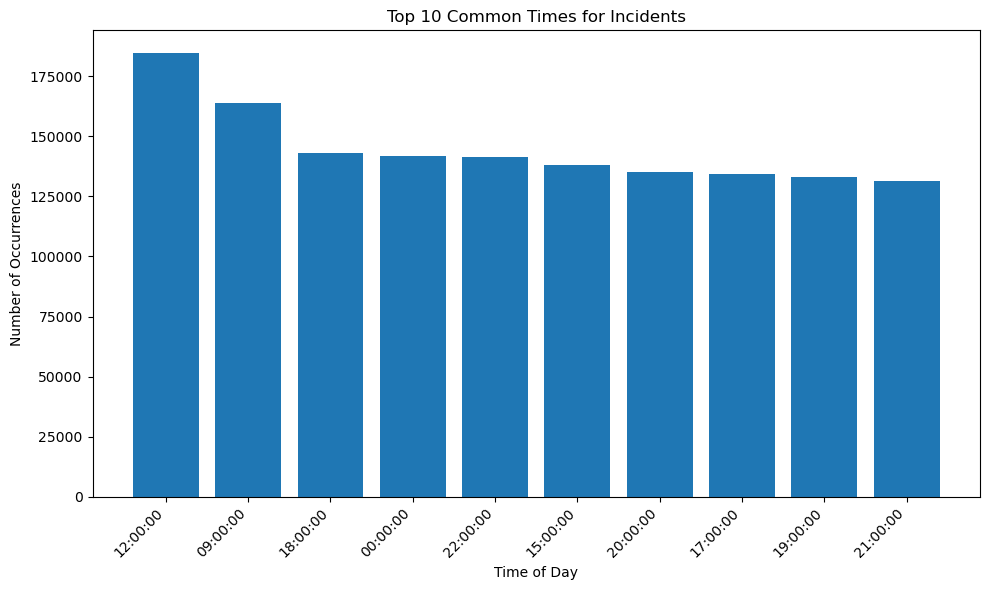

In [11]:
# Create a bar plot to visualize the top 10 common times
plt.figure(figsize=(10, 6))
plt.bar(top_10_common_times.index.astype(str), top_10_common_times.values)
plt.xlabel('Time of Day')
plt.ylabel('Number of Occurrences')
plt.title('Top 10 Common Times for Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Convert 'Date' column to datetime type
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract the time component from the datetime
crime_df_corr['Time'] = crime_df_corr['Date'].dt.time

# Filter data for rows where 'Primary Type' is 'NARCOTICS'
narcotics_data = crime_df_corr[crime_df_corr['Primary Type'] == 'NARCOTICS']

# Count the occurrences of each time for 'NARCOTICS' incidents
narcotics_time_counts = narcotics_data['Time'].value_counts()

# Get the top 5 common times and their counts for 'NARCOTICS' incidents
top_5_narcotics_times = narcotics_time_counts.nlargest(5)

print("Top 5 common times for NARCOTICS incidents:")
print(top_5_narcotics_times)

Top 5 common times for NARCOTICS incidents:
Time
21:00:00    5381
20:00:00    5153
20:30:00    5039
13:00:00    4994
14:00:00    4923
Name: count, dtype: int64


In [13]:
# Variable created to gather shape of crime_df
num_rows, num_cols = crime_df_corr.shape

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 7846809
Number of columns: 13


In [14]:
# columns_to_drop = ['ID', 'Case Number', 'Block', 'IUCR', 'Beat', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location', 'Community Area', 'Description']
# crime_df_corr.drop(columns=columns_to_drop, inplace=True)
# crime_df_corr.columns

In [15]:
# Variable created to gather shape of crime_df
num_rows, num_cols = crime_df_corr.shape

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 7846809
Number of columns: 13


In [16]:
crime_df_corr.head(2)

Date        Primary Type Location Description  Arrest  \
0 2018-09-01 00:01:00               THEFT            RESIDENCE   False   
1 2016-05-01 00:25:00  DECEPTIVE PRACTICE                  NaN   False   

   Domestic  District  Ward  Year  Month  Day  DayOfWeek Time_of_Day      Time  
0      True       6.0   8.0  2018      9    1          5          AM  00:01:00  
1     False       8.0  15.0  2016      5    1          6          AM  00:25:00

In [17]:
crimes_by_year = crime_df_corr.groupby('Year').size().reset_index(name='Total Crimes')
# crimes_by_year

In [18]:
# Convert 'Date' column to datetime type
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Group by 'Year' and calculate the total crimes for each year
crimes_by_year = crime_df_corr.groupby('Year').size().reset_index(name='Total Crimes')

# Calculate the percentage decrease for each year compared to the previous year
crimes_by_year['Percentage Change'] = crimes_by_year['Total Crimes'].pct_change() * 100

# Drop the NaN value resulting from the percentage change calculation for the first year
crimes_by_year = crimes_by_year.dropna()

# Calculate the mean of the percentage change
mean_percentage_change = crimes_by_year['Percentage Change'].mean()

print("Year-by-year Percentage Change Table:")
print(crimes_by_year)

# print("Mean Change:")
# print(mean_percentage_change)

Year-by-year Percentage Change Table:
    Year  Total Crimes  Percentage Change
1   2002        486805           0.189345
2   2003        475983          -2.223067
3   2004        469421          -1.378621
4   2005        453772          -3.333681
5   2006        448178          -1.232778
6   2007        437087          -2.474686
7   2008        427169          -2.269113
8   2009        392825          -8.039909
9   2010        370505          -5.681919
10  2011        351975          -5.001282
11  2012        336273          -4.461112
12  2013        307478          -8.562983
13  2014        275745         -10.320413
14  2015        264775          -3.978313
15  2016        269808           1.900859
16  2017        269092          -0.265374
17  2018        268811          -0.104425
18  2019        261290          -2.797877
19  2020        212170         -18.799036
20  2021        208733          -1.619927
21  2022        238712          14.362367
22  2023        134317         -43.732

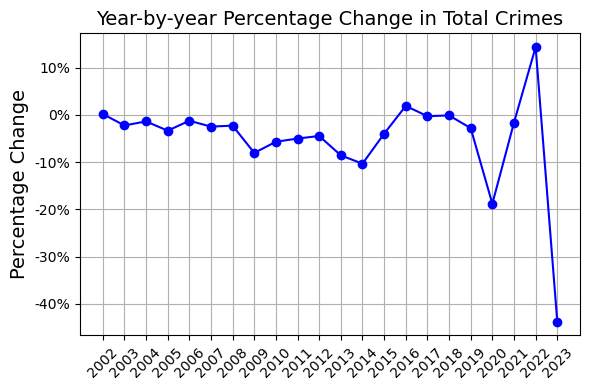

In [19]:
# Plotting the line plot
plt.figure(figsize=(6, 4))
plt.plot(crimes_by_year['Year'], crimes_by_year['Percentage Change'], marker='o', linestyle='-', color='b')
# plt.xlabel('Year', fontsize=14)  # Set fontsize for x-axis label
plt.ylabel('Percentage Change', fontsize=14)  # Set fontsize for y-axis label
plt.title('Year-by-year Percentage Change in Total Crimes', fontsize=14)  # Set fontsize for title
plt.grid(True)
plt.xticks(crimes_by_year['Year'], rotation=45)  # Rotate x-axis tick labels by 45 degrees

# Add percentage symbol to y-axis ticks
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.show()

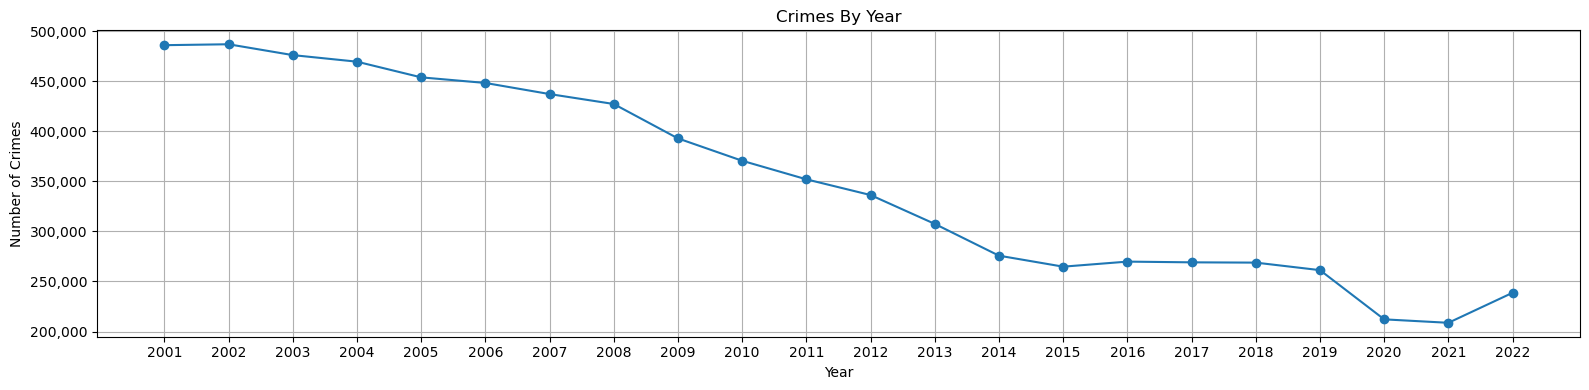

In [20]:
# Filter data for years up to 2022
crime_df_filtered = crime_df_corr[crime_df_corr['Year'] <= 2022]

# Group the filtered data by 'Year' and calculate the count of incidents for each year
yearly_incidents = crime_df_filtered.groupby('Year').size()

# Create a yearly graph
plt.figure(figsize=(16, 4))
plt.plot(yearly_incidents.index, yearly_incidents.values, marker='o', linestyle='-')
plt.xlabel('Year')  # Add the x-axis label
plt.ylabel('Number of Crimes')
plt.title('Crimes By Year')
plt.grid(True)

# Set custom y-axis ticks
y_ticks = [200000, 250000, 300000, 350000, 400000, 450000, 500000]
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.yticks(y_ticks)

# Set x-axis ticks for all years
plt.xticks(yearly_incidents.index)  

plt.tight_layout()
plt.show()

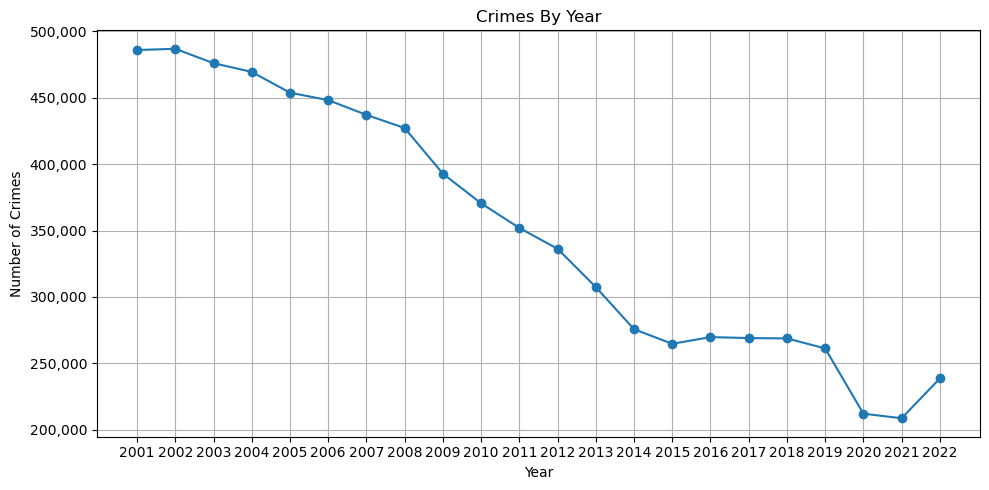

In [21]:
# Filter data for years up to 2022
crime_df_filtered = crime_df_corr[crime_df_corr['Year'] <= 2022]

# Group the filtered data by 'Year' and calculate the count of incidents for each year
yearly_incidents = crime_df_filtered.groupby('Year').size()

# Create a yearly graph
plt.figure(figsize=(10, 5))
plt.plot(yearly_incidents.index, yearly_incidents.values, marker='o', linestyle='-')
plt.xlabel('Year')  # Add the x-axis label
plt.ylabel('Number of Crimes')
plt.title('Crimes By Year')
plt.grid(True)

# Set custom y-axis ticks
y_ticks = [200000, 250000, 300000, 350000, 400000, 450000, 500000]
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.yticks(y_ticks)

# Set x-axis ticks for all years
plt.xticks(yearly_incidents.index)  

plt.tight_layout()
plt.show()

In [22]:
# Filter data for the year 2002 and 2022
crime_df_2002 = crime_df_corr[crime_df_corr['Year'] == 2002]
crime_df_2022 = crime_df_corr[crime_df_corr['Year'] == 2022]

# Calculate the total number of occurrences for each primary type in 2002
total_occurrences_2002 = crime_df_2002['Primary Type'].value_counts()

# Calculate the total number of occurrences for each primary type in 2022
total_occurrences_2022 = crime_df_2022['Primary Type'].value_counts()

# Create dataframes for each year's total occurrences
df_2002 = pd.DataFrame({'Total 2002': total_occurrences_2002})
df_2022 = pd.DataFrame({'Total 2022': total_occurrences_2022})

# Merge the two dataframes on the primary type
comparison_table = df_2002.merge(df_2022, left_index=True, right_index=True, how='outer')

# Fill NaN values with 0
comparison_table.fillna(0, inplace=True)

# Calculate the difference between the two years
comparison_table['Difference'] = comparison_table['Total 2022'] - comparison_table['Total 2002']

# Calculate the percentage difference and remove non-numerical values
comparison_table['PCT Change'] = ((comparison_table['Difference'] / comparison_table['Total 2002']) * 100).apply(lambda x: round(x, 2) if not pd.isna(x) else "")

# Sort the DataFrame based on Percentage Difference in descending order
comparison_table.sort_values(by='PCT Change', ascending=False, inplace=True)

# Remove rows for specified primary types
exclude_primary_types = ["NON-CRIMINAL", "CONCEALED CARRY LICENSE VIOLATION", "HUMAN TRAFFICKING"]
comparison_table = comparison_table[~comparison_table.index.isin(exclude_primary_types)]

# Display only the top 25 rows of the comparison table using tabulate
print(tabulate(comparison_table.head(25), headers='keys', tablefmt='psql'))

+----------------------------------+--------------+--------------+--------------+--------------+
| Primary Type                     |   Total 2002 |   Total 2022 |   Difference |   PCT Change |
|----------------------------------+--------------+--------------+--------------+--------------|
| CRIMINAL SEXUAL ASSAULT          |           27 |         1558 |         1531 |      5670.37 |
| STALKING                         |          200 |          443 |          243 |       121.5  |
| WEAPONS VIOLATION                |         4281 |         8766 |         4485 |       104.77 |
| OBSCENITY                        |           26 |           49 |           23 |        88.46 |
| OTHER NARCOTIC VIOLATION         |            5 |            7 |            2 |        40    |
| DECEPTIVE PRACTICE               |        13731 |        16331 |         2600 |        18.94 |
| HOMICIDE                         |          658 |          725 |           67 |        10.18 |
| INTERFERENCE WITH PUBLIC OFF

In [23]:
print(tabulate(comparison_table.tail(10), headers='keys', tablefmt='psql'))

+------------------------+--------------+--------------+--------------+--------------+
| Primary Type           |   Total 2002 |   Total 2022 |   Difference |   PCT Change |
|------------------------+--------------+--------------+--------------+--------------|
| CRIMINAL TRESPASS      |        13880 |         4224 |        -9656 |       -69.57 |
| BURGLARY               |        25623 |         7592 |       -18031 |       -70.37 |
| PUBLIC PEACE VIOLATION |         2457 |          710 |        -1747 |       -71.1  |
| LIQUOR LAW VIOLATION   |         1414 |          203 |        -1211 |       -85.64 |
| KIDNAPPING             |          829 |          117 |         -712 |       -85.89 |
| NARCOTICS              |        51789 |         4716 |       -47073 |       -90.89 |
| PROSTITUTION           |         6408 |          283 |        -6125 |       -95.58 |
| GAMBLING               |          971 |            9 |         -962 |       -99.07 |
| RITUALISM              |            2 |  

In [24]:
# Filter data for the year 2002 and 2011
crime_df_2002 = crime_df_corr[crime_df_corr['Year'] == 2002]
crime_df_2011 = crime_df_corr[crime_df_corr['Year'] == 2011]

# Calculate the total number of occurrences for each primary type in 2002
total_occurrences_2002 = crime_df_2002['Primary Type'].value_counts()

# Calculate the total number of occurrences for each primary type in 2011
total_occurrences_2011 = crime_df_2011['Primary Type'].value_counts()

# Create dataframes for each year's total occurrences
df_2002 = pd.DataFrame({'Total 2002': total_occurrences_2002})
df_2011 = pd.DataFrame({'Total 2011': total_occurrences_2011})

# Merge the two dataframes on the primary type
comparison_table = df_2002.merge(df_2011, left_index=True, right_index=True, how='outer')

# Fill NaN values with 0
comparison_table.fillna(0, inplace=True)

# Calculate the difference between the two years
comparison_table['Difference'] = comparison_table['Total 2011'] - comparison_table['Total 2002']

# Calculate the percentage difference and remove non-numerical values
comparison_table['PCT Change'] = ((comparison_table['Difference'] / comparison_table['Total 2002']) * 100).apply(lambda x: round(x, 2) if not pd.isna(x) else "")

# Sort the DataFrame based on Percentage Difference in descending order
comparison_table.sort_values(by='PCT Change', ascending=False, inplace=True)

# Remove rows for specified primary types
exclude_primary_types = ["NON-CRIMINAL", "CONCEALED CARRY LICENSE VIOLATION", "HUMAN TRAFFICKING"]
comparison_table = comparison_table[~comparison_table.index.isin(exclude_primary_types)]

# Display only the top 25 rows of the comparison table using tabulate
print(tabulate(comparison_table.head(25), headers='keys', tablefmt='psql'))

+----------------------------------+--------------+--------------+--------------+--------------+
| Primary Type                     |   Total 2002 |   Total 2011 |   Difference |   PCT Change |
|----------------------------------+--------------+--------------+--------------+--------------|
| INTERFERENCE WITH PUBLIC OFFICER |          361 |         1047 |          686 |       190.03 |
| CRIMINAL SEXUAL ASSAULT          |           27 |           46 |           19 |        70.37 |
| PUBLIC INDECENCY                 |            8 |           13 |            5 |        62.5  |
| OBSCENITY                        |           26 |           40 |           14 |        53.85 |
| PUBLIC PEACE VIOLATION           |         2457 |         3095 |          638 |        25.97 |
| BURGLARY                         |        25623 |        26620 |          997 |         3.89 |
| OTHER NARCOTIC VIOLATION         |            5 |            5 |            0 |         0    |
| OFFENSE INVOLVING CHILDREN  

In [25]:
# Filter data for the year 2012 and 2022
crime_df_2012 = crime_df_corr[crime_df_corr['Year'] == 2012]
crime_df_2022 = crime_df_corr[crime_df_corr['Year'] == 2022]

# Calculate the total number of occurrences for each primary type in 2002
total_occurrences_2012 = crime_df_2012['Primary Type'].value_counts()

# Calculate the total number of occurrences for each primary type in 2022
total_occurrences_2022 = crime_df_2022['Primary Type'].value_counts()

# Create dataframes for each year's total occurrences
df_2012 = pd.DataFrame({'Total 2012': total_occurrences_2012})
df_2022 = pd.DataFrame({'Total 2022': total_occurrences_2022})

# Merge the two dataframes on the primary type
comparison_table = df_2012.merge(df_2022, left_index=True, right_index=True, how='outer')

# Fill NaN values with 0
comparison_table.fillna(0, inplace=True)

# Calculate the difference between the two years
comparison_table['Difference'] = comparison_table['Total 2022'] - comparison_table['Total 2012']

# Calculate the percentage difference and remove non-numerical values
comparison_table['PCT Change'] = ((comparison_table['Difference'] / comparison_table['Total 2012']) * 100).apply(lambda x: round(x, 2) if not pd.isna(x) else "")

# Sort the DataFrame based on Percentage Difference in descending order
comparison_table.sort_values(by='PCT Change', ascending=False, inplace=True)

# Remove rows for specified primary types
exclude_primary_types = ["NON-CRIMINAL", "CONCEALED CARRY LICENSE VIOLATION", "HUMAN TRAFFICKING"]
comparison_table = comparison_table[~comparison_table.index.isin(exclude_primary_types)]

# Display only the top 25 rows of the comparison table using tabulate
print(tabulate(comparison_table.head(25), headers='keys', tablefmt='psql'))

+----------------------------------+--------------+--------------+--------------+--------------+
| Primary Type                     |   Total 2012 |   Total 2022 |   Difference |   PCT Change |
|----------------------------------+--------------+--------------+--------------+--------------|
| CRIMINAL SEXUAL ASSAULT          |           61 |         1558 |         1497 |      2454.1  |
| WEAPONS VIOLATION                |         3907 |         8766 |         4859 |       124.37 |
| STALKING                         |          207 |          443 |          236 |       114.01 |
| OBSCENITY                        |           26 |           49 |           23 |        88.46 |
| HOMICIDE                         |          515 |          725 |          210 |        40.78 |
| MOTOR VEHICLE THEFT              |        16492 |        21444 |         4952 |        30.03 |
| DECEPTIVE PRACTICE               |        13764 |        16331 |         2567 |        18.65 |
| OTHER NARCOTIC VIOLATION    

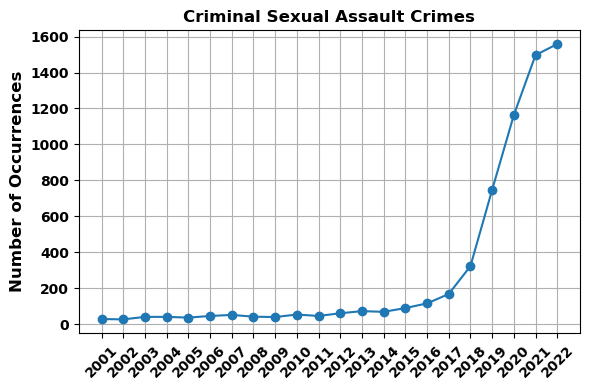

In [26]:
# Filter data for 'CRIMINAL SEXUAL ASSAULT'
data_criminal_sexual_assault = crime_df_corr[crime_df_corr['Primary Type'] == 'CRIMINAL SEXUAL ASSAULT']

# Count occurrences of 'CRIMINAL SEXUAL ASSAULT' for each year
occurrences_by_year = data_criminal_sexual_assault['Year'].value_counts().sort_index()

# Filter occurrences for the years 2001 to 2022
occurrences_by_year = occurrences_by_year[(occurrences_by_year.index >= 2001) & (occurrences_by_year.index <= 2022)]

# Create the line plot
plt.figure(figsize=(6, 4))
plt.plot(occurrences_by_year.index, occurrences_by_year.values, marker='o', linestyle='-')
# plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Occurrences', fontsize=12, fontweight='bold')
plt.title('Criminal Sexual Assault Crimes', fontsize=12, fontweight='bold')

# Modify y-axis
plt.tick_params(axis='y', labelsize=10)
plt.yticks(fontweight='bold')

# Modify x-axis
plt.tick_params(axis='x', labelsize=10)
plt.xticks(fontweight='bold')

plt.grid(True)
plt.xticks(occurrences_by_year.index, rotation=45)
plt.tight_layout()
plt.show()


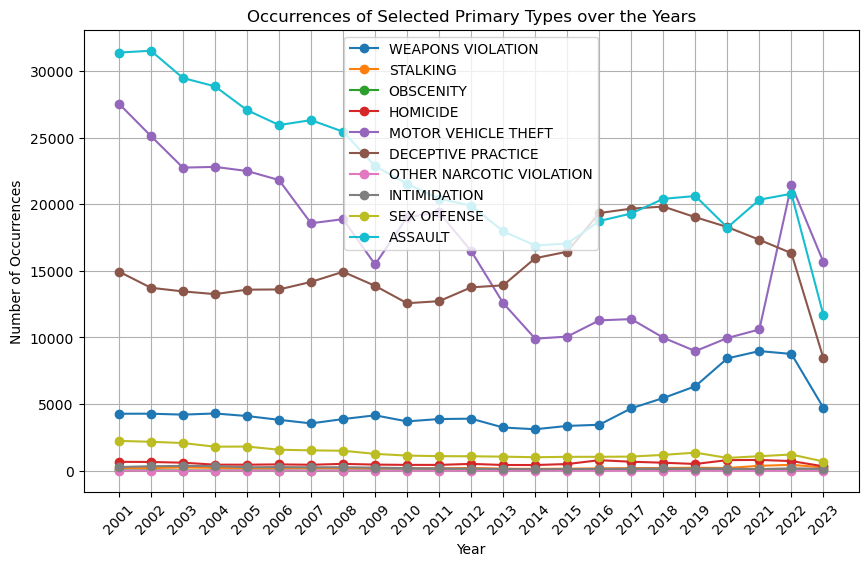

In [27]:
# List of selected primary types
selected_primary_types = ['WEAPONS VIOLATION', 'STALKING', 'OBSCENITY', 'HOMICIDE', 'MOTOR VEHICLE THEFT',
                          'DECEPTIVE PRACTICE', 'OTHER NARCOTIC VIOLATION', 'INTIMIDATION', 'SEX OFFENSE', 'ASSAULT']

# Filter data for the selected primary types
data_selected_primary_types = crime_df_corr[crime_df_corr['Primary Type'].isin(selected_primary_types)]

# Count occurrences of selected primary types for each year
occurrences_by_year = data_selected_primary_types['Year'].value_counts().sort_index()

# Create the line plot
plt.figure(figsize=(10, 6))
for primary_type in selected_primary_types:
    data_primary_type = data_selected_primary_types[data_selected_primary_types['Primary Type'] == primary_type]
    occurrences_by_year = data_primary_type['Year'].value_counts().sort_index()
    plt.plot(occurrences_by_year.index, occurrences_by_year.values, marker='o', linestyle='-', label=primary_type)

plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences of Selected Primary Types over the Years')
plt.grid(True)
plt.xticks(occurrences_by_year.index, rotation=45)
plt.legend()
plt.show()


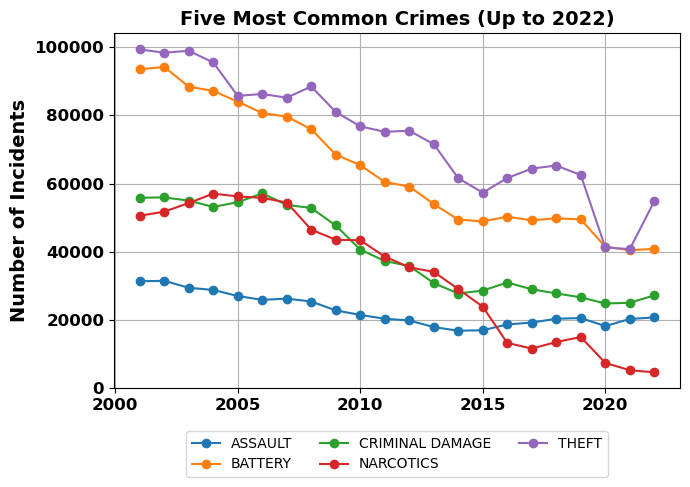

In [28]:
# Filter data for years up to 2022
crime_df_filtered = crime_df_corr[crime_df_corr['Year'] <= 2022]

# Get the top 5 most common primary types
top_5_primary_types = crime_df_filtered['Primary Type'].value_counts().head(5).index

# Group the filtered data by 'Year' and 'Primary Type' and calculate the count of incidents for each year and each primary type
yearly_primary_type_incidents = crime_df_filtered[crime_df_filtered['Primary Type'].isin(top_5_primary_types)].groupby(['Year', 'Primary Type']).size().unstack(fill_value=0)

plt.figure(figsize=(7, 5))
for primary_type in yearly_primary_type_incidents.columns:
    plt.plot(yearly_primary_type_incidents.index, yearly_primary_type_incidents[primary_type], marker='o', linestyle='-', label=primary_type)

# plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Incidents', fontsize=14, fontweight='bold')
plt.title('Five Most Common Crimes (Up to 2022)', fontsize=14, fontweight='bold')
plt.grid(True)

# Modify y-axis
plt.tick_params(axis='y', labelsize=12)
plt.yticks(fontweight='bold')

# Modify x-axis
plt.tick_params(axis='x', labelsize=12)
plt.xticks(fontweight='bold')

# Move the legend below the graph and remove gray fill
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, facecolor='none')

plt.tight_layout()
plt.show()

In [29]:
# Count yearly arrests
yearly_arrests_count = crime_df_corr[crime_df_corr['Arrest'] == True].groupby('Year')['Arrest'].sum().reset_index(name='Arrests')

print(yearly_arrests_count)

    Year  Arrests
0   2001   141934
1   2002   141563
2   2003   141588
3   2004   144700
4   2005   140924
5   2006   135418
6   2007   131879
7   2008   110014
8   2009   110825
9   2010   100541
10  2011    96286
11  2012    90663
12  2013    86537
13  2014    79631
14  2015    70040
15  2016    53027
16  2017    52646
17  2018    53867
18  2019    56215
19  2020    34097
20  2021    26342
21  2022    27702
22  2023    15803


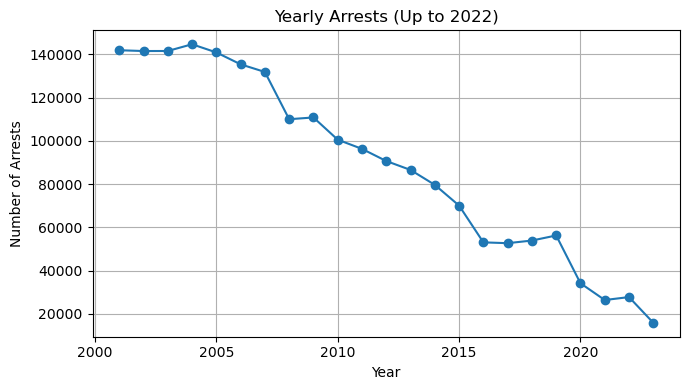

In [30]:
yearly_arrests = crime_df_corr[crime_df_corr['Arrest'] == True].groupby('Year').size().reset_index(name='Arrests')

# Plot the yearly arrests
plt.figure(figsize=(7, 4))
plt.plot(yearly_arrests['Year'], yearly_arrests['Arrests'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Arrests')
plt.title('Yearly Arrests (Up to 2022)')
plt.grid(True)
plt.tight_layout()
plt.show()

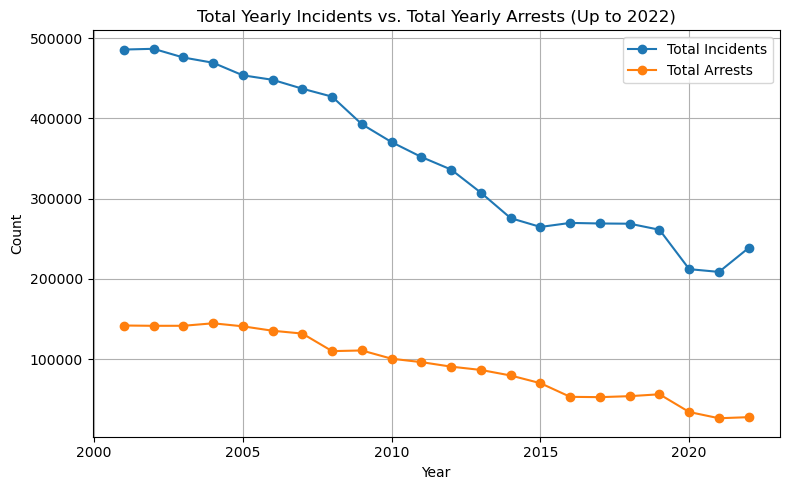

In [31]:
# Filter data for years up to 2022
crime_df_corr = crime_df_corr[crime_df_corr['Year'] <= 2022]

# Calculate total yearly incidents
total_yearly_incidents = crime_df_corr.groupby('Year').size().reset_index(name='Total Incidents')

# Calculate total yearly arrests
total_yearly_arrests = crime_df_corr[crime_df_corr['Arrest'] == True].groupby('Year').size().reset_index(name='Total Arrests')

# Plot the total yearly incidents and arrests
plt.figure(figsize=(8, 5))
plt.plot(total_yearly_incidents['Year'], total_yearly_incidents['Total Incidents'], marker='o', linestyle='-', label='Total Incidents')
plt.plot(total_yearly_arrests['Year'], total_yearly_arrests['Total Arrests'], marker='o', linestyle='-', label='Total Arrests')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Yearly Incidents vs. Total Yearly Arrests (Up to 2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

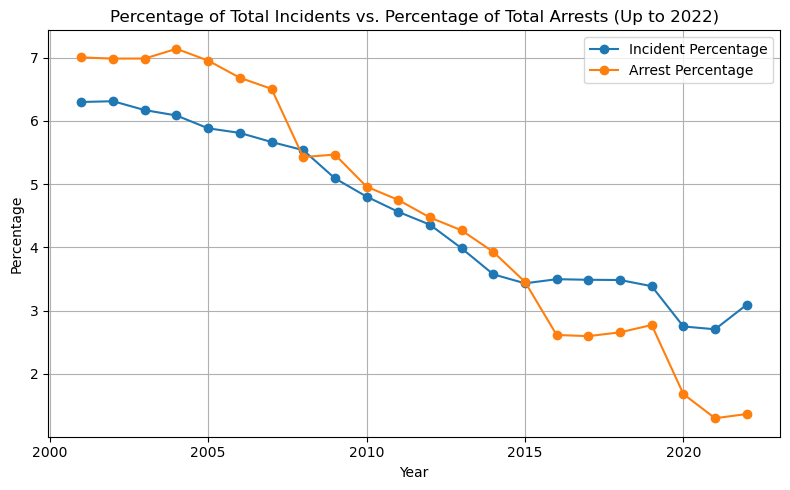

In [32]:
# Calculate total yearly incidents and arrests
total_yearly_incidents = crime_df_corr.groupby('Year').size().reset_index(name='Total Incidents')
total_yearly_arrests = crime_df_corr[crime_df_corr['Arrest'] == True].groupby('Year').size().reset_index(name='Total Arrests')

# Calculate percentages
total_incidents_sum = total_yearly_incidents['Total Incidents'].sum()
total_arrests_sum = total_yearly_arrests['Total Arrests'].sum()

total_yearly_incidents['Incident Percentage'] = (total_yearly_incidents['Total Incidents'] / total_incidents_sum) * 100
total_yearly_arrests['Arrest Percentage'] = (total_yearly_arrests['Total Arrests'] / total_arrests_sum) * 100

# Plot the percentages of total incidents and arrests
plt.figure(figsize=(8, 5))
plt.plot(total_yearly_incidents['Year'], total_yearly_incidents['Incident Percentage'], marker='o', linestyle='-', label='Incident Percentage')
plt.plot(total_yearly_arrests['Year'], total_yearly_arrests['Arrest Percentage'], marker='o', linestyle='-', label='Arrest Percentage')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of Total Incidents vs. Percentage of Total Arrests (Up to 2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### As you can see, both lines follow similar trends over the years, which is a good sign. This indicates that as the total incidents increased, the percentage of arrests also tended to increase. This might suggest that law enforcement has been effective in apprehending suspects in a significant portion of the reported incidents.

#### However, it's important to note that the arrest percentage is consistently lower than the incident percentage. This means that not all reported incidents lead to arrests, and there could be various factors contributing to this, such as lack of evidence, ongoing investigations, or the nature of certain crimes.

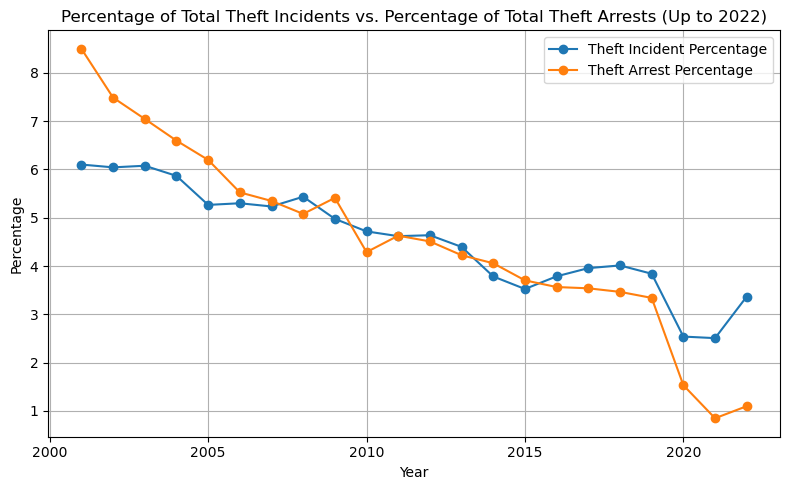

In [33]:
# Filter data for incidents where Primary Type is 'THEFT' and years up to 2022
theft_incidents_df = crime_df_corr[(crime_df_corr['Primary Type'] == 'THEFT') & (crime_df_corr['Year'] <= 2022)]

# Calculate total yearly theft incidents and arrests
total_yearly_incidents = theft_incidents_df.groupby('Year').size().reset_index(name='Total Theft Incidents')
total_yearly_arrests = theft_incidents_df[theft_incidents_df['Arrest'] == True].groupby('Year').size().reset_index(name='Total Theft Arrests')

# Calculate percentages
total_theft_incidents_sum = total_yearly_incidents['Total Theft Incidents'].sum()
total_theft_arrests_sum = total_yearly_arrests['Total Theft Arrests'].sum()

total_yearly_incidents['Theft Incident Percentage'] = (total_yearly_incidents['Total Theft Incidents'] / total_theft_incidents_sum) * 100
total_yearly_arrests['Theft Arrest Percentage'] = (total_yearly_arrests['Total Theft Arrests'] / total_theft_arrests_sum) * 100

# Plot the percentages of total theft incidents and theft arrests
plt.figure(figsize=(8, 5))
plt.plot(total_yearly_incidents['Year'], total_yearly_incidents['Theft Incident Percentage'], marker='o', linestyle='-', label='Theft Incident Percentage')
plt.plot(total_yearly_arrests['Year'], total_yearly_arrests['Theft Arrest Percentage'], marker='o', linestyle='-', label='Theft Arrest Percentage')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of Total Theft Incidents vs. Percentage of Total Theft Arrests (Up to 2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

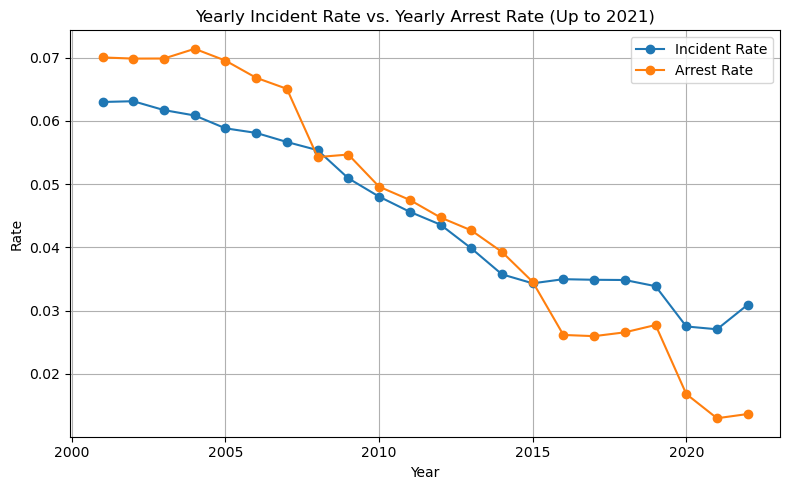

In [34]:
# Calculate total yearly incidents and arrests
total_yearly_incidents = crime_df_corr.groupby('Year').size().reset_index(name='Total Incidents')
total_yearly_arrests = crime_df_corr[crime_df_corr['Arrest'] == True].groupby('Year').size().reset_index(name='Total Arrests')

# Calculate yearly incident and arrest rates
total_yearly_incidents['Incident Rate'] = total_yearly_incidents['Total Incidents'] / (total_yearly_incidents['Total Incidents'].sum())
total_yearly_arrests['Arrest Rate'] = total_yearly_arrests['Total Arrests'] / (total_yearly_arrests['Total Arrests'].sum())

# Plot the yearly incident and arrest rates
plt.figure(figsize=(8, 5))
plt.plot(total_yearly_incidents['Year'], total_yearly_incidents['Incident Rate'], marker='o', linestyle='-', label='Incident Rate')
plt.plot(total_yearly_arrests['Year'], total_yearly_arrests['Arrest Rate'], marker='o', linestyle='-', label='Arrest Rate')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Yearly Incident Rate vs. Yearly Arrest Rate (Up to 2021)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Assuming 'Primary Type' is the column name for the Primary Type in your DataFrame 'crime_df_corr'

primary_type_counts = len(crime_df_corr['Primary Type'].unique())
print("Number of unique primary types:", primary_type_counts)

# Assuming 'Primary Type' is the column name for the Primary Type in your DataFrame 'crime_df_corr'

primary_type_counts = crime_df_corr['Primary Type'].value_counts()
print(primary_type_counts)


Number of unique primary types: 36
Primary Type
THEFT                                1626969
BATTERY                              1410866
CRIMINAL DAMAGE                       878910
NARCOTICS                             746149
ASSAULT                               501099
OTHER OFFENSE                         479025
BURGLARY                              422245
MOTOR VEHICLE THEFT                   366581
DECEPTIVE PRACTICE                    340752
ROBBERY                               289674
CRIMINAL TRESPASS                     212867
WEAPONS VIOLATION                     103905
PROSTITUTION                           69750
OFFENSE INVOLVING CHILDREN             55213
PUBLIC PEACE VIOLATION                 52085
SEX OFFENSE                            30337
CRIM SEXUAL ASSAULT                    27606
INTERFERENCE WITH PUBLIC OFFICER       18205
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13122
HOMICID

In [36]:
# Get the count of unique primary types
primary_type_counts = crime_df_corr['Primary Type'].value_counts()

# Get the top 5 most common primary types
top_5_most_common = primary_type_counts.head(5)

# Get the top 5 least common primary types
top_5_least_common = primary_type_counts.tail(5)

print("Top 5 most common primary types:")
print(top_5_most_common)

print("\nTop 5 least common primary types:")
print(top_5_least_common)


Top 5 most common primary types:
Primary Type
THEFT              1626969
BATTERY            1410866
CRIMINAL DAMAGE     878910
NARCOTICS           746149
ASSAULT             501099
Name: count, dtype: int64

Top 5 least common primary types:
Primary Type
HUMAN TRAFFICKING                   96
NON - CRIMINAL                      38
RITUALISM                           24
NON-CRIMINAL (SUBJECT SPECIFIED)     9
DOMESTIC VIOLENCE                    1
Name: count, dtype: int64


In [37]:
# Assuming 'Primary Type' is the column name for the Primary Type in your DataFrame 'crime_df_corr'

# Rename "Non-Criminal (Subject Specified)" to "Non-Criminal"
crime_df_corr['Primary Type'].replace("Non-Criminal (Subject Specified)", "Non-Criminal", inplace=True)

# Verify the changes
print(crime_df_corr['Primary Type'].unique())


['THEFT' 'DECEPTIVE PRACTICE' 'NARCOTICS' 'CRIMINAL DAMAGE'
 'OTHER OFFENSE' 'PUBLIC PEACE VIOLATION' 'BATTERY' 'CRIM SEXUAL ASSAULT'
 'BURGLARY' 'LIQUOR LAW VIOLATION' 'CRIMINAL SEXUAL ASSAULT'
 'OFFENSE INVOLVING CHILDREN' 'SEX OFFENSE' 'CRIMINAL TRESPASS'
 'WEAPONS VIOLATION' 'ROBBERY' 'MOTOR VEHICLE THEFT' 'ASSAULT' 'OBSCENITY'
 'INTERFERENCE WITH PUBLIC OFFICER' 'HUMAN TRAFFICKING' 'ARSON' 'GAMBLING'
 'PROSTITUTION' 'NON-CRIMINAL' 'INTIMIDATION' 'STALKING' 'KIDNAPPING'
 'CONCEALED CARRY LICENSE VIOLATION' 'HOMICIDE' 'OTHER NARCOTIC VIOLATION'
 'RITUALISM' 'PUBLIC INDECENCY' 'NON - CRIMINAL'
 'NON-CRIMINAL (SUBJECT SPECIFIED)' 'DOMESTIC VIOLENCE']


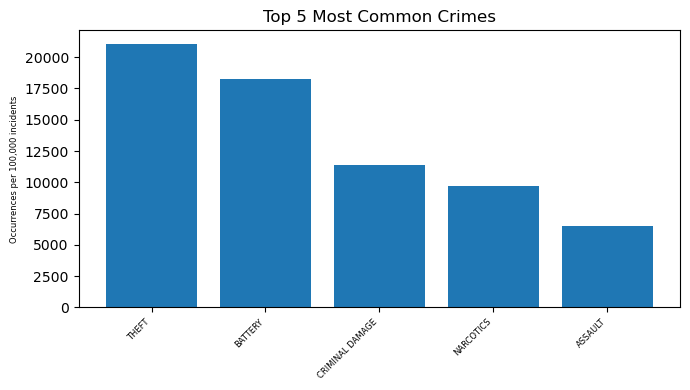

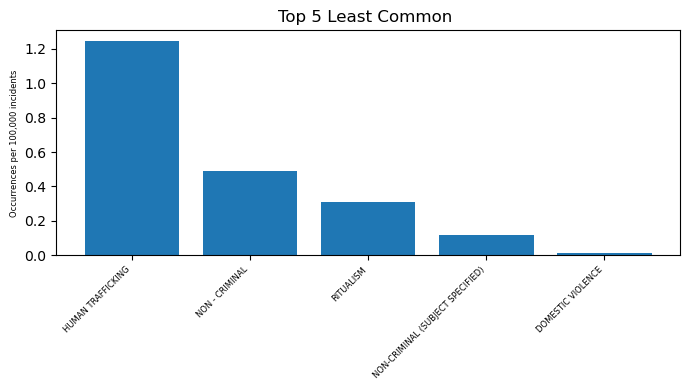

In [38]:
# Assuming 'Primary Type' is the column name for the Primary Type in your DataFrame 'crime_df_corr'

# Get the count of unique primary types
primary_type_counts = crime_df_corr['Primary Type'].value_counts()

# Calculate the total number of incidents
total_incidents = len(crime_df_corr)

# Get the top 5 most common primary types per 100,000 incidents
top_5_most_common = (primary_type_counts.head(5) / total_incidents) * 100000

# Get the top 5 least common primary types per 100,000 incidents
top_5_least_common = (primary_type_counts.tail(5) / total_incidents) * 100000

# Visualize the top 5 most common primary types per 100,000 incidents
plt.figure(figsize=(7, 4))  # Smaller figsize: width=7 inches, height=4 inches
plt.bar(top_5_most_common.index, top_5_most_common.values)
# plt.xlabel('Primary Type', fontsize=10)  # Smaller font size
plt.ylabel('Occurrences per 100,000 incidents', fontsize=6)  # Smaller font size
plt.title('Top 5 Most Common Crimes', fontsize=12)  # Smaller font size
plt.xticks(rotation=45, ha='right', fontsize=6)  # Smaller font size
plt.tight_layout()
plt.show()

# Visualize the top 5 least common primary types per 100,000 incidents
plt.figure(figsize=(7, 4))  # Smaller figsize: width=7 inches, height=4 inches
plt.bar(top_5_least_common.index, top_5_least_common.values)
# plt.xlabel('Primary Type', fontsize=10)  # Smaller font size
plt.ylabel('Occurrences per 100,000 incidents', fontsize=6)  # Smaller font size
plt.title('Top 5 Least Common ', fontsize=12)  # Smaller font size
plt.xticks(rotation=45, ha='right', fontsize=6)  # Smaller font size
plt.tight_layout()
plt.show()



In [39]:
# # Check the data type of the 'Date' column
# print(crime_df_corr['Date'].dtype)

# # Convert 'Date' column to datetime format
# crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# # Verify the data type after conversion
# print(crime_df_corr['Date'].dtype)


In [40]:
# # Save the modified DataFrame as a .pkl file
# crime_df_corr.to_pickle('crime_df_corr.pkl')

In [41]:
# Extract 'Year', 'Month', 'Day', and 'Day of Week' from 'Date' column
crime_df_corr['Year'] = crime_df_corr['Date'].dt.year
crime_df_corr['Month'] = crime_df_corr['Date'].dt.month
crime_df_corr['Day'] = crime_df_corr['Date'].dt.day
crime_df_corr['DayOfWeek'] = crime_df_corr['Date'].dt.dayofweek

# Extract 'AM' or 'PM' based on the hour of the 'Date' column
crime_df_corr['Time_of_Day'] = crime_df_corr['Date'].dt.strftime('%p')

# Check the updated dataframe with additional features
print(crime_df_corr.head())



                 Date        Primary Type Location Description  Arrest  \
0 2018-09-01 00:01:00               THEFT            RESIDENCE   False   
1 2016-05-01 00:25:00  DECEPTIVE PRACTICE                  NaN   False   
2 2018-07-31 13:30:00           NARCOTICS               STREET    True   
3 2018-12-19 16:30:00     CRIMINAL DAMAGE               STREET   False   
4 2015-02-02 10:00:00  DECEPTIVE PRACTICE                OTHER   False   

   Domestic  District  Ward  Year  Month  Day  DayOfWeek Time_of_Day      Time  
0      True       6.0   8.0  2018      9    1          5          AM  00:01:00  
1     False       8.0  15.0  2016      5    1          6          AM  00:25:00  
2     False       2.0   5.0  2018      7   31          1          PM  13:30:00  
3     False      25.0  31.0  2018     12   19          2          PM  16:30:00  
4     False       8.0  23.0  2015      2    2          0          AM  10:00:00  


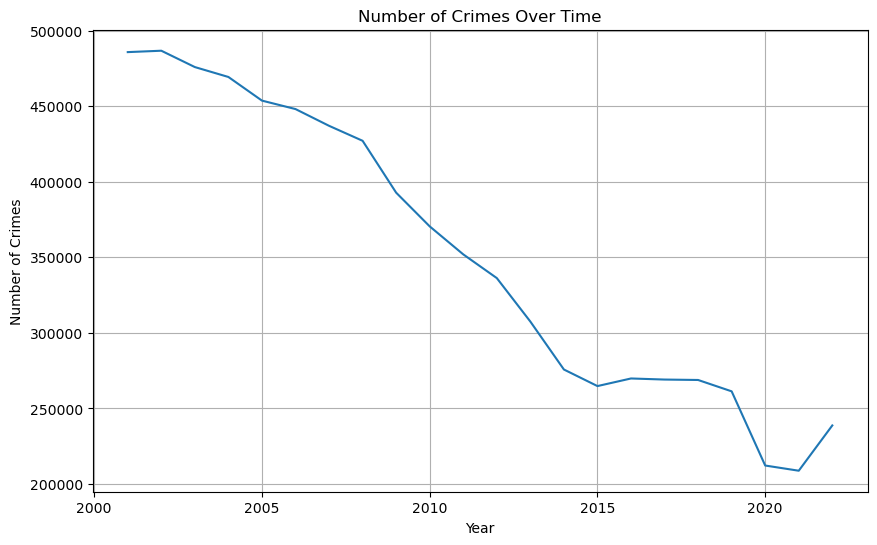

In [42]:
# Plot the Number of Crimes Over Time:

# Group the data by year and count the number of crimes in each year
crime_count_by_year = crime_df_corr['Year'].value_counts().sort_index()

# Plot the number of crimes over the years
plt.figure(figsize=(10, 6))
sns.lineplot(x=crime_count_by_year.index, y=crime_count_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Over Time')
plt.grid(True)
plt.show()


#### Determine the number of days, months, and years elapsed

In [43]:
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

In [44]:
min_date = crime_df_corr['Date'].min()
max_date = crime_df_corr['Date'].max()

print(max_date)
print(min_date)

2022-12-31 23:55:00
2001-01-01 00:00:00


In [45]:
# Convert 'Date' column to datetime type
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Find the minimum and maximum dates
min_date = crime_df_corr['Date'].min()
max_date = crime_df_corr['Date'].max()

# Calculate the time difference
time_elapsed = relativedelta(max_date, min_date)

print(f"Years elapsed: {time_elapsed.years} years")
print(f"Months elapsed: {time_elapsed.months} months")
print(f"Days elapsed: {time_elapsed.days} days")



Years elapsed: 21 years
Months elapsed: 11 months
Days elapsed: 30 days


In [46]:
# Convert 'Date' column to datetime type
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Find the first and last dates
first_date = crime_df_corr['Date'].min()
last_date = crime_df_corr['Date'].max()

# Extract day, month, and year from the first date
first_day = first_date.day
first_month = first_date.month
first_year = first_date.year

# Extract day, month, and year from the last date
last_day = last_date.day
last_month = last_date.month
last_year = last_date.year

print("First Date:")
print(f"Day: {first_day}")
print(f"Month: {first_month}")
print(f"Year: {first_year}")

print("\nLast Date:")
print(f"Day: {last_day}")
print(f"Month: {last_month}")
print(f"Year: {last_year}")


First Date:
Day: 1
Month: 1
Year: 2001

Last Date:
Day: 31
Month: 12
Year: 2022


In [47]:
crime_df_corr.head(10)

Date        Primary Type          Location Description  \
0 2018-09-01 00:01:00               THEFT                     RESIDENCE   
1 2016-05-01 00:25:00  DECEPTIVE PRACTICE                           NaN   
2 2018-07-31 13:30:00           NARCOTICS                        STREET   
3 2018-12-19 16:30:00     CRIMINAL DAMAGE                        STREET   
4 2015-02-02 10:00:00  DECEPTIVE PRACTICE                         OTHER   
5 2001-01-01 11:00:00  DECEPTIVE PRACTICE                     RESIDENCE   
6 2015-09-03 18:00:00     CRIMINAL DAMAGE                     RESIDENCE   
7 2017-12-04 00:00:00       OTHER OFFENSE  GOVERNMENT BUILDING/PROPERTY   
8 2018-01-01 08:00:00  DECEPTIVE PRACTICE                     RESIDENCE   
9 2018-12-20 16:00:00       OTHER OFFENSE                     RESIDENCE   

   Arrest  Domestic  District  Ward  Year  Month  Day  DayOfWeek Time_of_Day  \
0   False      True       6.0   8.0  2018      9    1          5          AM   
1   False     False       8.0  15.0  2016      5    1          6          AM   
2    True     False       2.0   5.0  2018      7   31          1          PM   
3   False     False      25.0  31.0  2018     12   19          2          PM   
4   False     False       8.0  23.0  2015      2    2          0          AM   
5   False     False       4.0   8.0  2001      1    1          0          AM   
6   False     False       2.0   4.0  2015      9    3          3          PM   
7    True     False       2.0   3.0  2017     12    4          0          AM   
8   False     False      25.0  30.0  2018      1    1          0          AM   
9   False     False      17.0  33.0  2018     12   20          3          PM   

       Time  
0  00:01:00  
1  00:25:00  
2  13:30:00  
3  16:30:00  
4  10:00:00  
5  11:00:00  
6  18:00:00  
7  00:00:00  
8  08:00:00  
9  16:00:00

In [48]:
unique_primary_types = crime_df_corr['Primary Type'].unique().tolist()
unique_location_descriptions = crime_df_corr['Location Description'].unique().tolist()
unique_districts = crime_df_corr['District'].unique().tolist()
unique_wards = crime_df_corr['Ward'].unique().tolist()

print("Unique Primary Types:", unique_primary_types)
print("Unique Location Descriptions:", unique_location_descriptions)
print("Unique Districts:", unique_districts)
print("Unique Wards:", unique_wards)


Unique Primary Types: ['THEFT', 'DECEPTIVE PRACTICE', 'NARCOTICS', 'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'PUBLIC PEACE VIOLATION', 'BATTERY', 'CRIM SEXUAL ASSAULT', 'BURGLARY', 'LIQUOR LAW VIOLATION', 'CRIMINAL SEXUAL ASSAULT', 'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'ROBBERY', 'MOTOR VEHICLE THEFT', 'ASSAULT', 'OBSCENITY', 'INTERFERENCE WITH PUBLIC OFFICER', 'HUMAN TRAFFICKING', 'ARSON', 'GAMBLING', 'PROSTITUTION', 'NON-CRIMINAL', 'INTIMIDATION', 'STALKING', 'KIDNAPPING', 'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE', 'OTHER NARCOTIC VIOLATION', 'RITUALISM', 'PUBLIC INDECENCY', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'DOMESTIC VIOLENCE']
Unique Location Descriptions: ['RESIDENCE', nan, 'STREET', 'OTHER', 'GOVERNMENT BUILDING/PROPERTY', 'POLICE FACILITY/VEH PARKING LOT', 'VACANT LOT/LAND', 'APARTMENT', 'SIDEWALK', 'HOTEL/MOTEL', 'RESIDENCE-GARAGE', 'BANK', 'PARKING LOT/GARAGE(NON.RESID.)', 'PARK PROPERTY', 'HOSPITAL BUILDING/

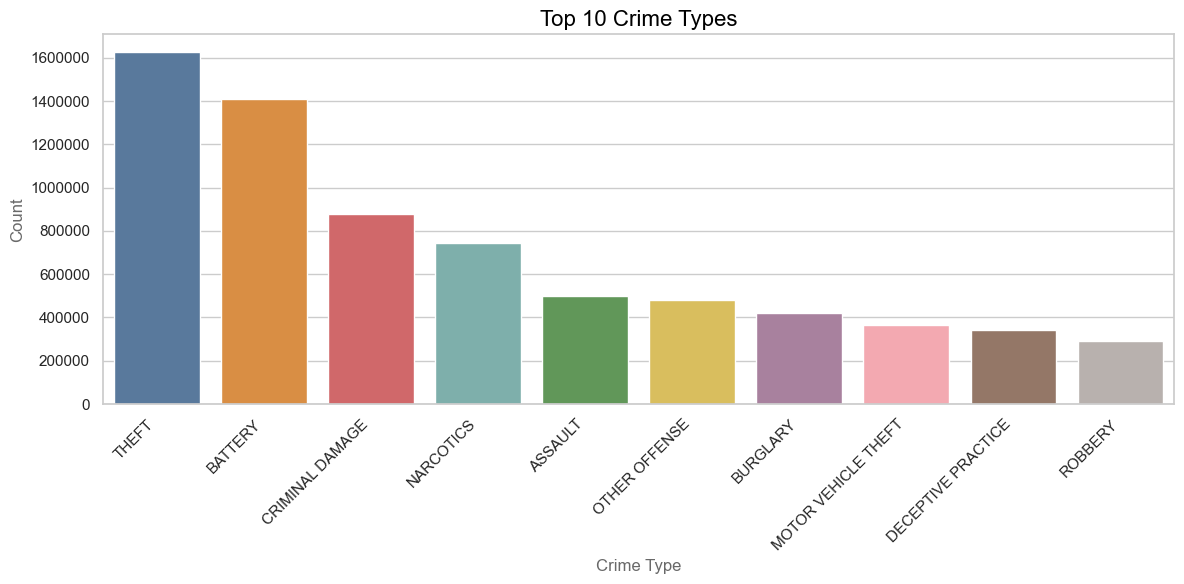

In [49]:
# Define a custom muted color palette for the top 15 crime types
custom_palette = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc949', '#af7aa1',
                  '#ff9da7', '#9c755f', '#bab0ac', '#ffbf79', '#d95f02', '#a4a4a4', '#000000', '#808080']

# Get the count of each type of crime
crime_counts = crime_df_corr['Primary Type'].value_counts()

# Get the top 15 crime types
top_10_crime_counts = crime_counts.head(10)

# Set up the seaborn style with the custom color palette
sns.set_theme(style="whitegrid", palette=custom_palette)

# Create the bar plot for the top 15 crime types with x-axis ticks at a 45-degree angle
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_crime_counts.index, y=top_10_crime_counts.values)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees and align them to the right
plt.xlabel('Crime Type', fontsize=12, color='dimgrey')  # Adding font size and changing label color to dimgrey
plt.ylabel('Count', fontsize=12, color='dimgrey')  # Adding font size and changing label color to dimgrey
plt.title('Top 10 Crime Types', fontsize=16, color='black')  # Adding font size and changing title color to black
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()



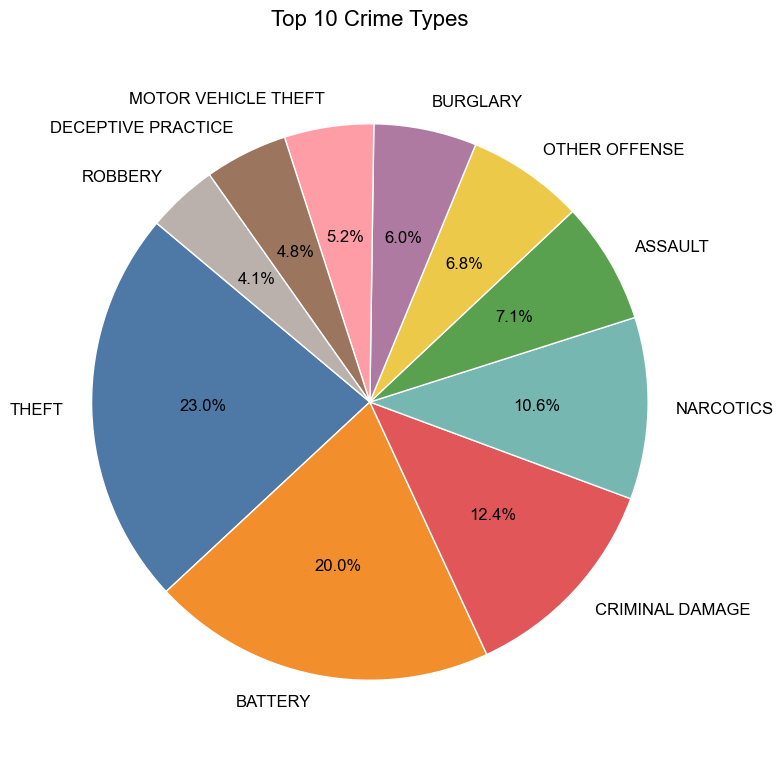

In [50]:
# Define a custom muted color palette for the top 15 crime types
custom_palette = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc949', '#af7aa1',
                  '#ff9da7', '#9c755f', '#bab0ac', '#ffbf79', '#d95f02', '#a4a4a4', '#000000', '#808080']

# Get the count of each type of crime
crime_counts = crime_df_corr['Primary Type'].value_counts()

# Get the top 10 crime types
top_10_crime_counts = crime_counts.head(10)

# Create a pie chart with the custom color palette
plt.figure(figsize=(8, 8))
plt.pie(top_10_crime_counts.values, labels=top_10_crime_counts.index, colors=custom_palette,
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12, 'color': 'black'})
plt.title('Top 10 Crime Types', fontsize=16, color='black')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()
plt.show()


In [51]:
# Get the count of each type of crime
crime_counts = crime_df_corr['Primary Type'].value_counts()

# Get the top 10 crime types
top_10_crime_counts = crime_counts.head(10)
top_10_crime_counts


Primary Type
THEFT                  1626969
BATTERY                1410866
CRIMINAL DAMAGE         878910
NARCOTICS               746149
ASSAULT                 501099
OTHER OFFENSE           479025
BURGLARY                422245
MOTOR VEHICLE THEFT     366581
DECEPTIVE PRACTICE      340752
ROBBERY                 289674
Name: count, dtype: int64

In [52]:
crime_df_corr

Date                Primary Type Location Description  \
0       2018-09-01 00:01:00                       THEFT            RESIDENCE   
1       2016-05-01 00:25:00          DECEPTIVE PRACTICE                  NaN   
2       2018-07-31 13:30:00                   NARCOTICS               STREET   
3       2018-12-19 16:30:00             CRIMINAL DAMAGE               STREET   
4       2015-02-02 10:00:00          DECEPTIVE PRACTICE                OTHER   
...                     ...                         ...                  ...   
7846797 2022-01-01 00:01:00               OTHER OFFENSE            APARTMENT   
7846798 2022-12-22 12:00:00          DECEPTIVE PRACTICE                  NaN   
7846799 2021-04-01 00:00:00          DECEPTIVE PRACTICE            RESIDENCE   
7846800 2015-11-03 12:00:00  OFFENSE INVOLVING CHILDREN            RESIDENCE   
7846801 2021-12-19 14:30:00          DECEPTIVE PRACTICE                  NaN   

         Arrest  Domestic  District  Ward  Year  Month  Day  DayOfWeek  \
0         False      True       6.0   8.0  2018      9    1          5   
1         False     False       8.0  15.0  2016      5    1          6   
2          True     False       2.0   5.0  2018      7   31          1   
3         False     False      25.0  31.0  2018     12   19          2   
4         False     False       8.0  23.0  2015      2    2          0   
...         ...       ...       ...   ...   ...    ...  ...        ...   
7846797   False     False      19.0  46.0  2022      1    1          5   
7846798   False     False      19.0  44.0  2022     12   22          3   
7846799   False     False       6.0  17.0  2021      4    1          3   
7846800   False     False      19.0  47.0  2015     11    3          1   
7846801   False     False      14.0  26.0  2021     12   19          6   

        Time_of_Day      Time  
0                AM  00:01:00  
1                AM  00:25:00  
2                PM  13:30:00  
3                PM  16:30:00  
4                AM  10:00:00  
...             ...       ...  
7846797          AM  00:01:00  
7846798          PM  12:00:00  
7846799          AM  00:00:00  
7846800          PM  12:00:00  
7846801          PM  14:30:00  

[7712492 rows x 13 columns]

In [53]:
# Filter for 'Theft' primary type
theft_occurrences = crime_df_corr[crime_df_corr['Primary Type'] == 'THEFT']

# Group by 'Year' and calculate total occurrences
theft_yearly_total = theft_occurrences.groupby('Year')['Primary Type'].count().reset_index()
theft_yearly_total.rename(columns={'Primary Type': 'Occurrence Count'}, inplace=True)

# Print the resulting table
print(theft_yearly_total)

    Year  Occurrence Count
0   2001             99277
1   2002             98332
2   2003             98876
3   2004             95463
4   2005             85684
5   2006             86240
6   2007             85156
7   2008             88435
8   2009             80975
9   2010             76757
10  2011             75153
11  2012             75466
12  2013             71534
13  2014             61568
14  2015             57350
15  2016             61621
16  2017             64383
17  2018             65287
18  2019             62491
19  2020             41320
20  2021             40795
21  2022             54806


In [54]:
# List to store results for each year
yearly_dataframes = []

# Iterate through years
for year in range(2001, 2023):
    # Filter for theft incidents in the current year
    theft_year = crime_df_corr[(crime_df_corr['Date'].dt.year == year) & (crime_df_corr['Primary Type'] == 'THEFT')]
    
    # Calculate daily total of theft
    daily_total = theft_year.resample('D', on='Date').size()
    
    # Create a dataframe for the current year
    year_df = pd.DataFrame({'Daily Total': daily_total})
    year_df.index.name = 'Date'
    year_df['Date'] = year_df.index
    
    # Add the year to the dataframe
    year_df['Year'] = year
    
    # Append the dataframe to the list
    yearly_dataframes.append(year_df)

# Concatenate all dataframes into a single dataframe
yearly_combined_df = pd.concat(yearly_dataframes)

In [55]:
yearly_combined_df

Daily Total       Date  Year
Date                                    
2001-01-01          412 2001-01-01  2001
2001-01-02          221 2001-01-02  2001
2001-01-03          226 2001-01-03  2001
2001-01-04          243 2001-01-04  2001
2001-01-05          265 2001-01-05  2001
...                 ...        ...   ...
2022-12-27          147 2022-12-27  2022
2022-12-28          112 2022-12-28  2022
2022-12-29          137 2022-12-29  2022
2022-12-30          125 2022-12-30  2022
2022-12-31          102 2022-12-31  2022

[8035 rows x 3 columns]

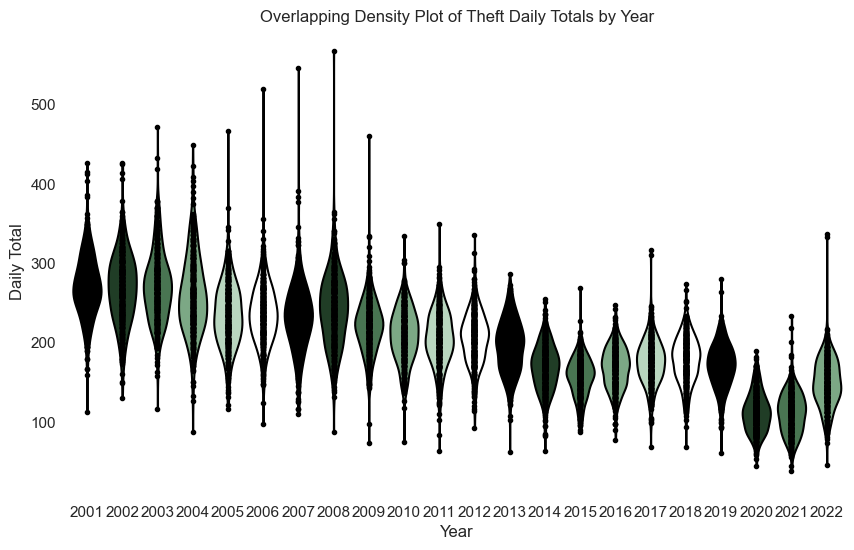

In [56]:
# Create an overlapping density plot (ridge plot)
plt.figure(figsize=(10, 6))
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = sns.cubehelix_palette(light=1, start=2, rot=0, dark=0, reverse=True)
sns.violinplot(x="Year", y="Daily Total", data=yearly_combined_df,
               inner="points", palette=palette, cut=0, scale="width")
sns.despine(left=True, bottom=True)
plt.title("Overlapping Density Plot of Theft Daily Totals by Year")
plt.xlabel("Year")
plt.ylabel("Daily Total")
plt.show()

In [57]:
# Pivot data to create a table of daily totals by year
daily_totals_pivot = crime_df_corr.pivot_table(index='Date', columns='Primary Type', aggfunc='size', fill_value=0)

# Create a stacked area plot using plotly
fig = px.area(daily_totals_pivot, x=daily_totals_pivot.index, y=daily_totals_pivot.columns, title="Horizontally Stacked Ridge-Like Plot of Theft Daily Totals by Year")
fig.update_layout(yaxis_title="Daily Total", xaxis_title="Date")
fig.show()

NameError: name 'px' is not defined

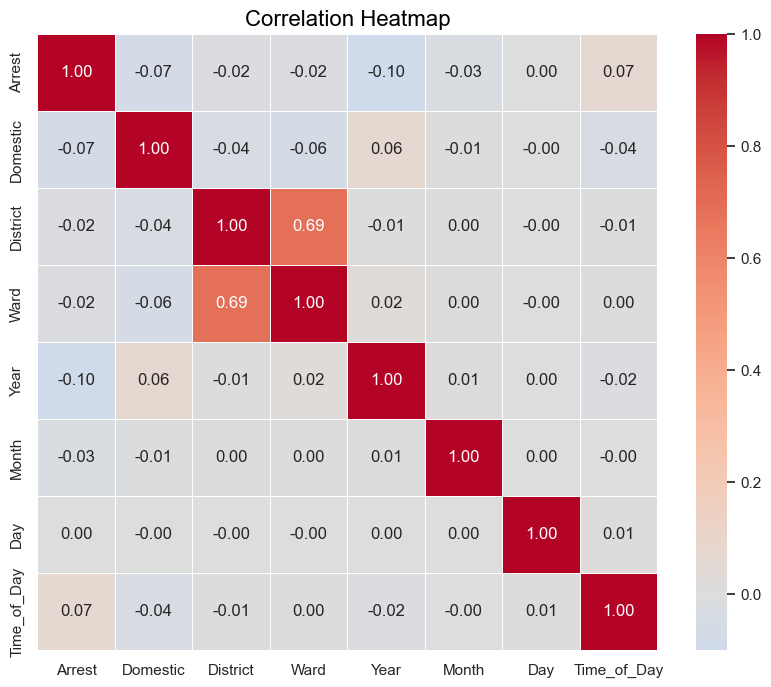

In [ ]:
# Extract the Year, Month, and Day from the 'Date' column
crime_df_corr['Year'] = crime_df_corr['Date'].dt.year
crime_df_corr['Month'] = crime_df_corr['Date'].dt.month
crime_df_corr['Day'] = crime_df_corr['Date'].dt.day

# Map 'Time_of_Day' to numerical values
time_mapping = {'AM': 0, 'PM': 1}
crime_df_corr['Time_of_Day'] = crime_df_corr['Time_of_Day'].map(time_mapping)

# Select relevant numerical columns for the heatmap
heatmap_data = crime_df_corr[['Arrest', 'Domestic', 'District', 'Ward', 'Year', 'Month', 'Day', 'Time_of_Day']]

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Set up the seaborn style
sns.set_theme(style="white")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16, color='black')
plt.show()


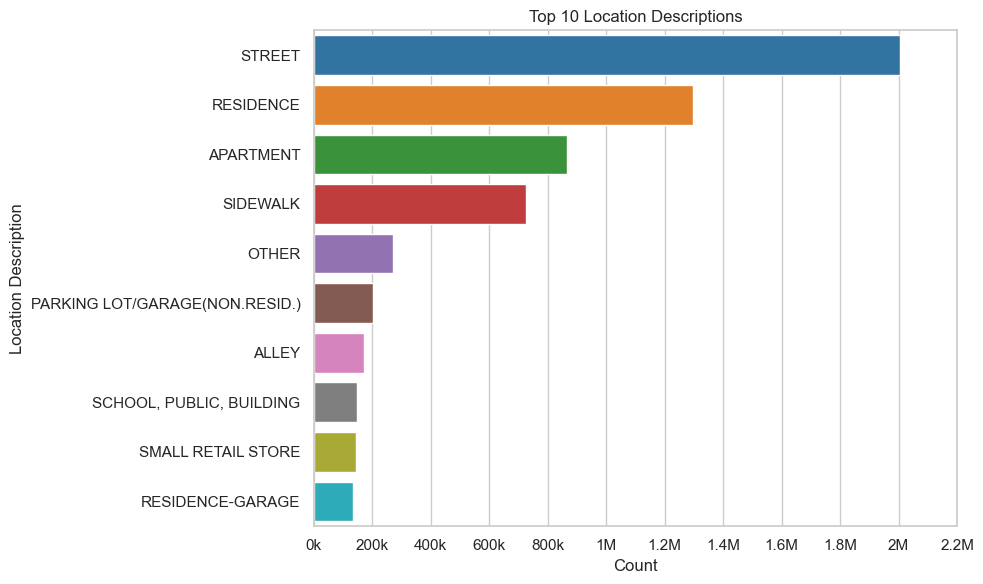

In [ ]:
# Your code to get the top 10 location descriptions
location_counts = crime_df_corr['Location Description'].value_counts()
top_10_location_counts = location_counts.head(10)

# Define your custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
                  "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Set up the seaborn style with the custom palette
sns.set_theme(style="whitegrid", palette=custom_palette)

# Create the horizontal bar plot for the top 10 location descriptions
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_location_counts.values, y=top_10_location_counts.index)

plt.xlabel('Count')
plt.ylabel('Location Description')
plt.title('Top 10 Location Descriptions')

# Manually set the tick positions and labels on the x-axis
tick_positions = [0, 200_000, 400_000, 600_000, 800_000, 1_000_000, 1_200_000, 1_400_000, 1_600_000, 1_800_000, 2_000_000, 2_200_000]
tick_labels = ['0k', '200k', '400k', '600k', '800k', '1M', '1.2M', '1.4M', '1.6M', '1.8M', '2M', '2.2M']

# Set the tick positions and labels on the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

plt.tight_layout()
plt.show()



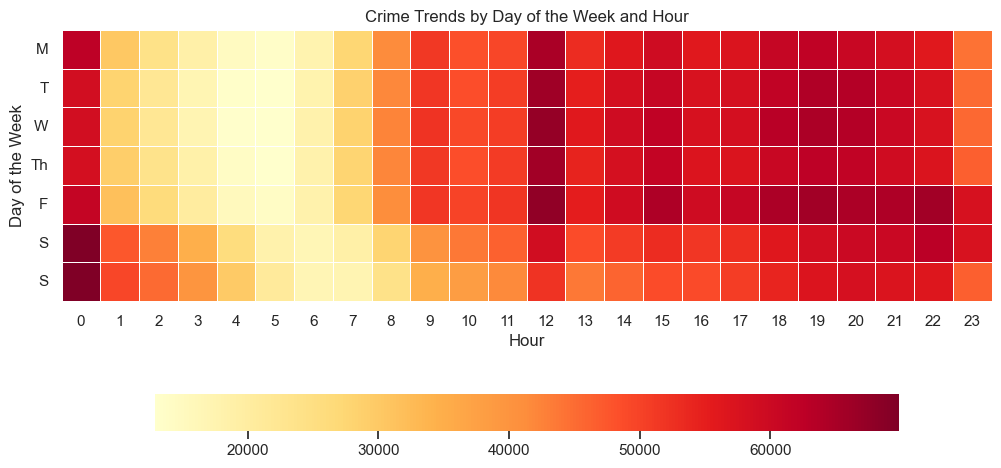

In [ ]:
# Convert the 'Date' column to a pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
crime_df_corr['DayOfWeek'] = crime_df_corr['Date'].dt.dayofweek
crime_df_corr['Hour'] = crime_df_corr['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of crimes for each group
crime_by_day_hour = crime_df_corr.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot heatmap
crime_heatmap = crime_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Create a heatmap plot with color gradient legend and square grid
plt.figure(figsize=(12, 6))
ax = sns.heatmap(crime_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Crime Trends by Day of the Week and Hour')
plt.show()



In [ ]:
# Assuming you have the crime_df_corr DataFrame with the data
# Filter data for the "Theft" crime type
theft_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'THEFT']
# Now the variable theft_crimes contains all the rows where 'Primary Type' is 'THEFT'
theft_crimes.head(1)


Date Primary Type Location Description  Arrest  Domestic  \
0 2018-09-01 00:01:00        THEFT            RESIDENCE   False      True   

   District  Ward  Year  Month  Day  DayOfWeek  Time_of_Day      Time  Hour  
0       6.0   8.0  2018      9    1          5            0  00:01:00     0

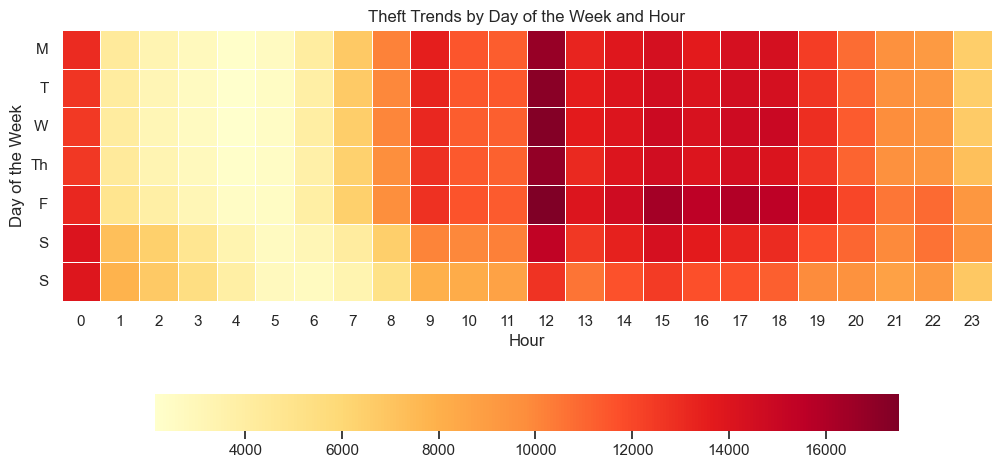

In [ ]:
# Create a copy of the DataFrame with only 'THEFT' crimes in the 'Primary Type' column
theft_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'THEFT'].copy()

# Convert the 'Date' column to a pandas datetime object
theft_crimes['Date'] = pd.to_datetime(theft_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
theft_crimes['DayOfWeek'] = theft_crimes['Date'].dt.dayofweek
theft_crimes['Hour'] = theft_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of theft crimes for each group
theft_by_day_hour = theft_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the theft heatmap
theft_heatmap = theft_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
theft_heatmap = theft_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "Theft" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(theft_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Theft Trends by Day of the Week and Hour')
plt.show()


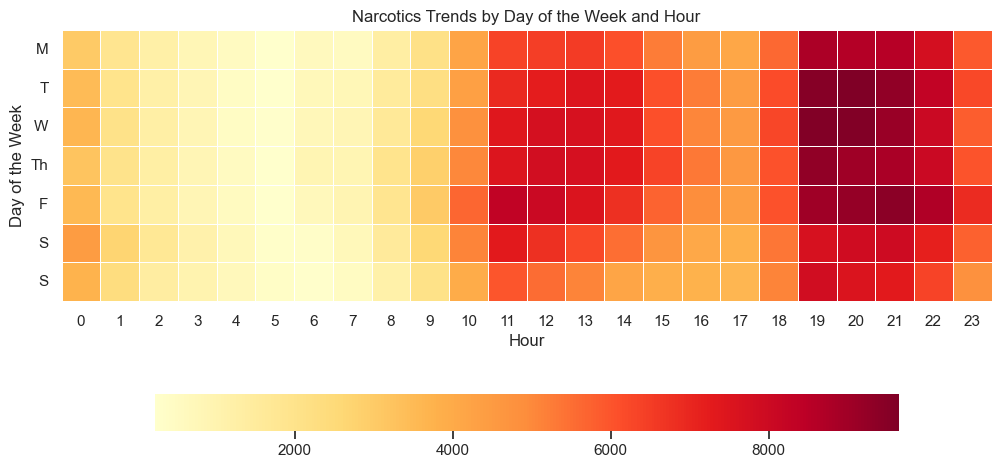

In [ ]:
# Create a copy of the DataFrame with only 'THEFT' crimes in the 'Primary Type' column
narcotics_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'NARCOTICS'].copy()

# Convert the 'Date' column to a pandas datetime object
narcotics_crimes['Date'] = pd.to_datetime(narcotics_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
narcotics_crimes['DayOfWeek'] = narcotics_crimes['Date'].dt.dayofweek
narcotics_crimes['Hour'] = narcotics_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of theft crimes for each group
narcotics_by_day_hour = narcotics_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the theft heatmap
narcotics_heatmap = narcotics_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
narcotics_heatmap = narcotics_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "Narcotics" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(narcotics_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Narcotics Trends by Day of the Week and Hour')
plt.show()


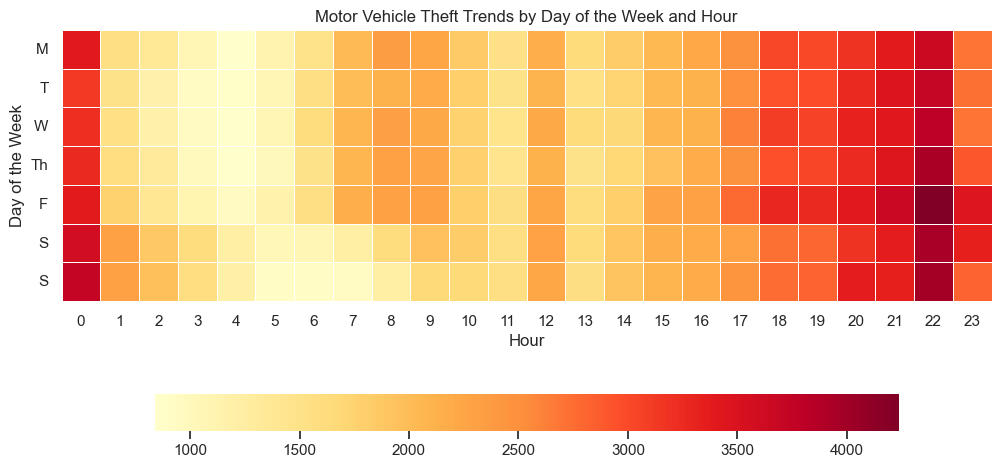

In [ ]:
# Create a copy of the DataFrame with only 'MOTOR VEHICLE THEFT' crimes in the 'Primary Type' column
motor_vehicle_theft_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'MOTOR VEHICLE THEFT'].copy()

# Convert the 'Date' column to a pandas datetime object
motor_vehicle_theft_crimes['Date'] = pd.to_datetime(motor_vehicle_theft_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
motor_vehicle_theft_crimes['DayOfWeek'] = motor_vehicle_theft_crimes['Date'].dt.dayofweek
motor_vehicle_theft_crimes['Hour'] = motor_vehicle_theft_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of theft crimes for each group
mvt_by_day_hour = motor_vehicle_theft_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the theft heatmap
mvt_heatmap = mvt_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
mvt_heatmap = mvt_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "MOTOR VEHICLE THEFT" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(mvt_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Motor Vehicle Theft Trends by Day of the Week and Hour')
plt.show()

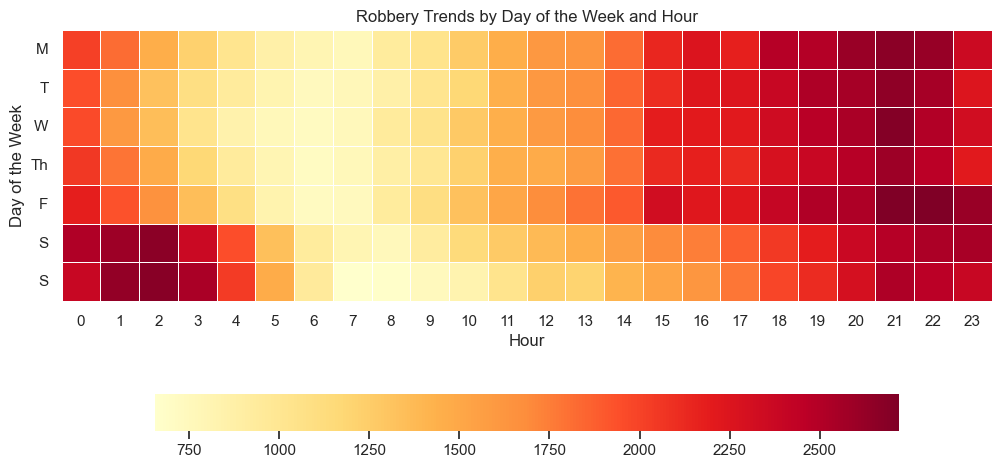

In [ ]:
# Create a copy of the DataFrame with only 'ROBBERY' crimes in the 'Primary Type' column
robbery_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'ROBBERY'].copy()

# Convert the 'Date' column to a pandas datetime object
robbery_crimes['Date'] = pd.to_datetime(robbery_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
robbery_crimes['DayOfWeek'] = robbery_crimes['Date'].dt.dayofweek
robbery_crimes['Hour'] = robbery_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of robbery crimes for each group
robbery_by_day_hour = robbery_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the robbery heatmap
robbery_heatmap = robbery_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
robbery_heatmap = robbery_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "ROBBERY" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(robbery_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Robbery Trends by Day of the Week and Hour')
plt.show()

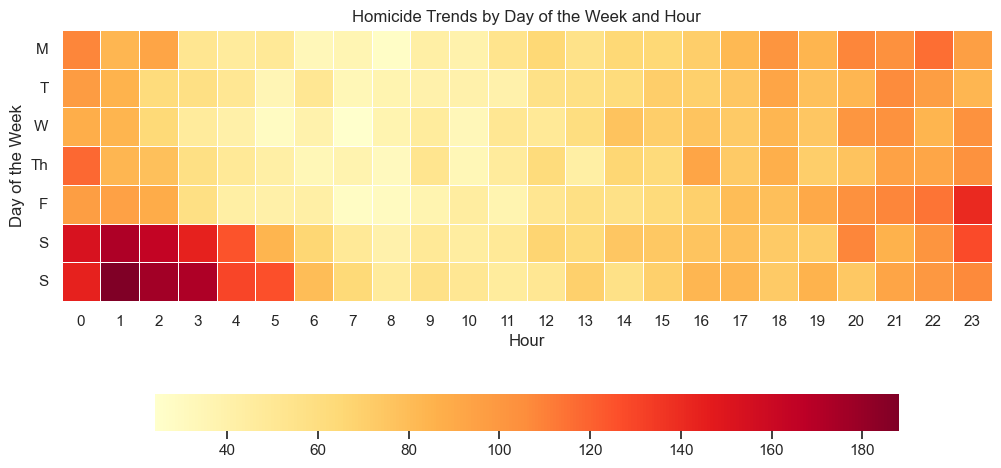

In [ ]:
# Create a copy of the DataFrame with only 'HOMICIDE' crimes in the 'Primary Type' column
homicide_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'HOMICIDE'].copy()

# Convert the 'Date' column to a pandas datetime object
homicide_crimes['Date'] = pd.to_datetime(homicide_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
homicide_crimes['DayOfWeek'] = homicide_crimes['Date'].dt.dayofweek
homicide_crimes['Hour'] = homicide_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of homicide crimes for each group
homicide_by_day_hour = homicide_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the homicide heatmap
homicide_heatmap = homicide_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
homicide_heatmap = homicide_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "HOMICIDE" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(homicide_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Homicide Trends by Day of the Week and Hour')
plt.show()

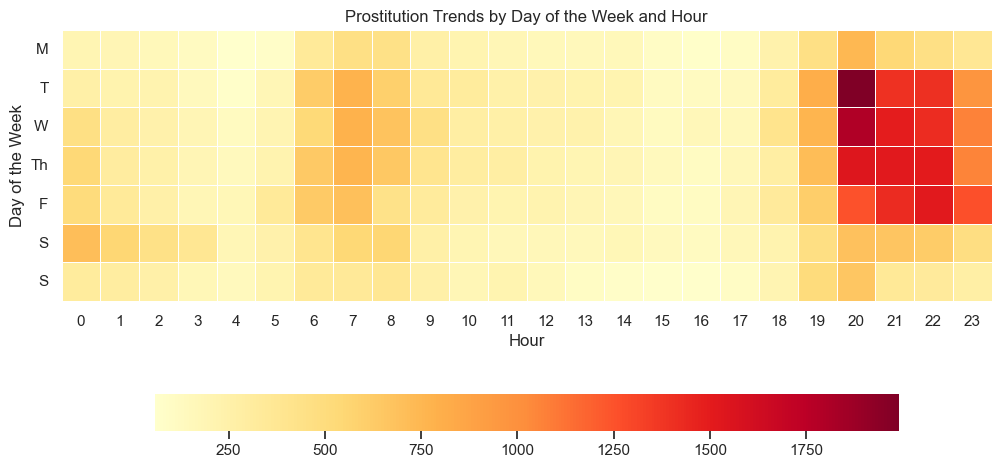

In [ ]:
# Create a copy of the DataFrame with only 'PROSTITUTION' crimes in the 'Primary Type' column
prostitution_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'PROSTITUTION'].copy()

# Convert the 'Date' column to a pandas datetime object
prostitution_crimes['Date'] = pd.to_datetime(prostitution_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
prostitution_crimes['DayOfWeek'] = prostitution_crimes['Date'].dt.dayofweek
prostitution_crimes['Hour'] = prostitution_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of PROSTITUTION crimes for each group
prostitution_by_day_hour = prostitution_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the PROSTITUTION heatmap
prostitution_heatmap = prostitution_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
prostitution_heatmap = prostitution_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "PROSTITUTION" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(prostitution_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Prostitution Trends by Day of the Week and Hour')
plt.show()

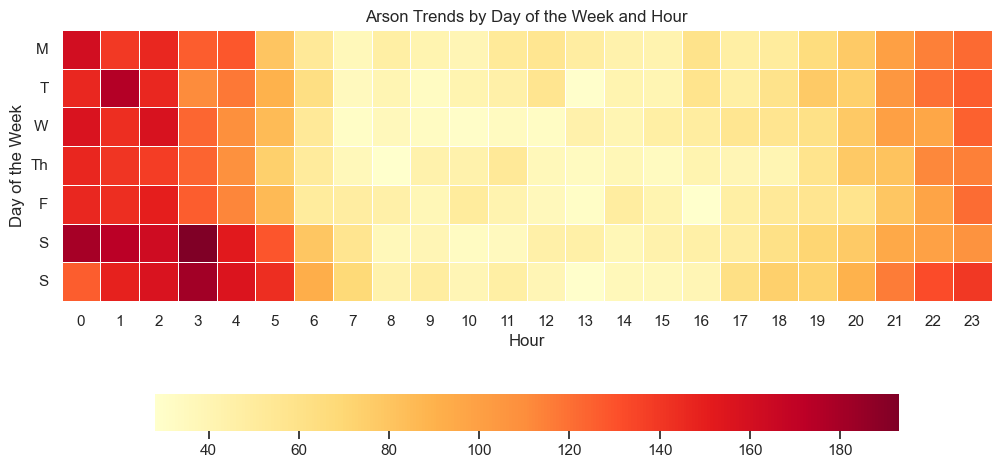

In [ ]:
# Create a copy of the DataFrame with only 'ARSON' crimes in the 'Primary Type' column
arson_crimes = crime_df_corr[crime_df_corr['Primary Type'] == 'ARSON'].copy()

# Convert the 'Date' column to a pandas datetime object
arson_crimes['Date'] = pd.to_datetime(arson_crimes['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
arson_crimes['DayOfWeek'] = arson_crimes['Date'].dt.dayofweek
arson_crimes['Hour'] = arson_crimes['Date'].dt.hour

# Group the data by day of the week and hour, and get the count of ARSON crimes for each group
arson_by_day_hour = arson_crimes.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')

# Reshape the data for a pivot table to plot the ARSON heatmap
arson_heatmap = arson_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Count', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
arson_heatmap = arson_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for the "ARSON" crime type
plt.figure(figsize=(12, 6))
ax = sns.heatmap(arson_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Arson Trends by Day of the Week and Hour')
plt.show()

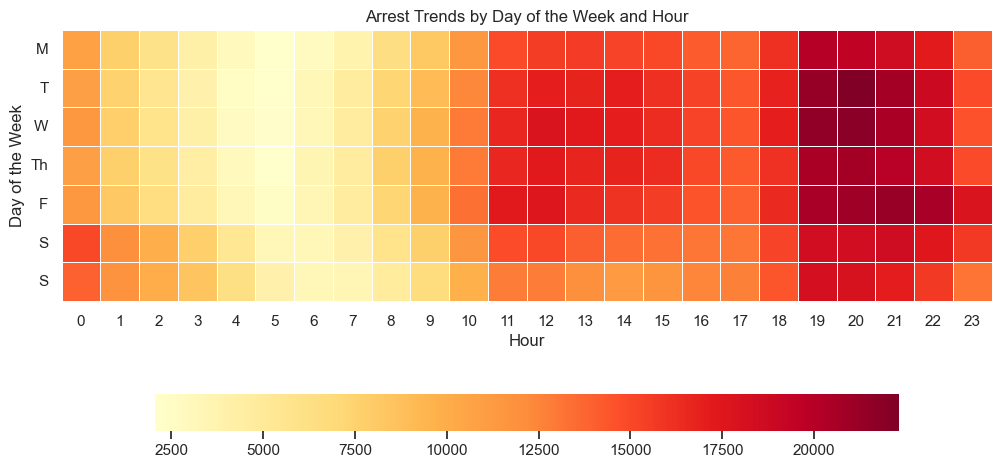

In [ ]:
# Convert 'Date' column to pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
crime_df_corr['DayOfWeek'] = crime_df_corr['Date'].dt.dayofweek
crime_df_corr['Hour'] = crime_df_corr['Date'].dt.hour

# Group the data by day of the week and hour, and calculate the sum of 'Arrest' for each group
arrest_by_day_hour = crime_df_corr.groupby(['DayOfWeek', 'Hour'])['Arrest'].sum().reset_index(name='ArrestCount')

# Reshape the data for a pivot table to plot the heatmap
arrest_heatmap = arrest_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='ArrestCount', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Reindex to ensure all combinations of Day of the Week and Hour are present
arrest_heatmap = arrest_heatmap.reindex(index=range(7), columns=range(24), fill_value=0)

# Create a heatmap for arrests by day of the week and hour
plt.figure(figsize=(12, 6))
ax = sns.heatmap(arrest_heatmap, cmap='YlOrRd', annot=False, fmt='d', cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Arrest Trends by Day of the Week and Hour')
plt.show()


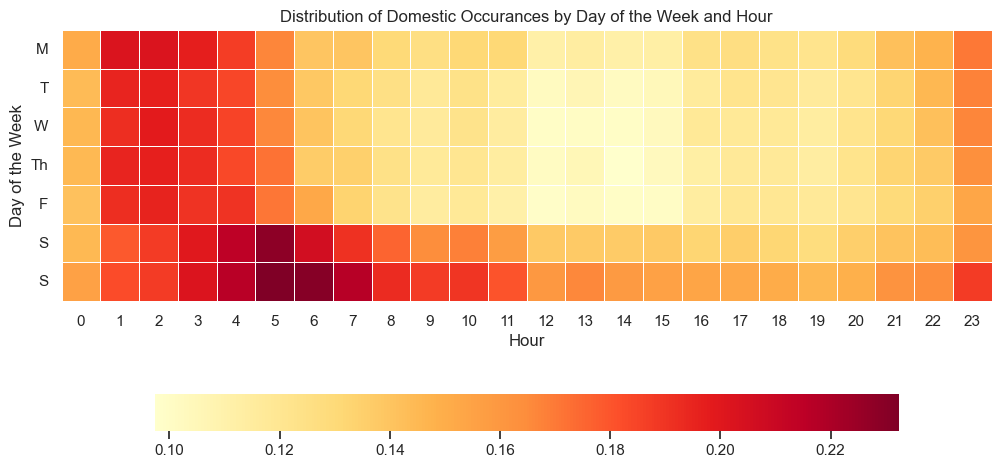

In [ ]:
# Convert the 'Date' column to a pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) and hour from the 'Date' column
crime_df_corr['DayOfWeek'] = crime_df_corr['Date'].dt.dayofweek
crime_df_corr['Hour'] = crime_df_corr['Date'].dt.hour

# Group the data by day of the week and hour, and calculate the percentage of True values for 'Domestic' in each group
crime_by_day_hour = crime_df_corr.groupby(['DayOfWeek', 'Hour'])['Domestic'].mean().reset_index(name='Percent True Domestic')

# Reshape the data for a pivot table to plot heatmap
crime_heatmap = crime_by_day_hour.pivot_table(index='DayOfWeek', columns='Hour', values='Percent True Domestic', fill_value=0)

# Custom abbreviated day labels for y-axis
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'S']

# Create a heatmap plot with color gradient legend and square grid
plt.figure(figsize=(12, 6))
ax = sns.heatmap(crime_heatmap, cmap='YlOrRd', annot=False, cbar=True, linewidths=0.5, square=True,
                 cbar_kws={"orientation": "horizontal", "pad": 0.2, "shrink": 0.8})
plt.xlabel('Hour')
ax.set_yticklabels(day_labels, rotation=0)
plt.ylabel('Day of the Week')
plt.title('Distribution of Domestic Occurances by Day of the Week and Hour')
plt.show()

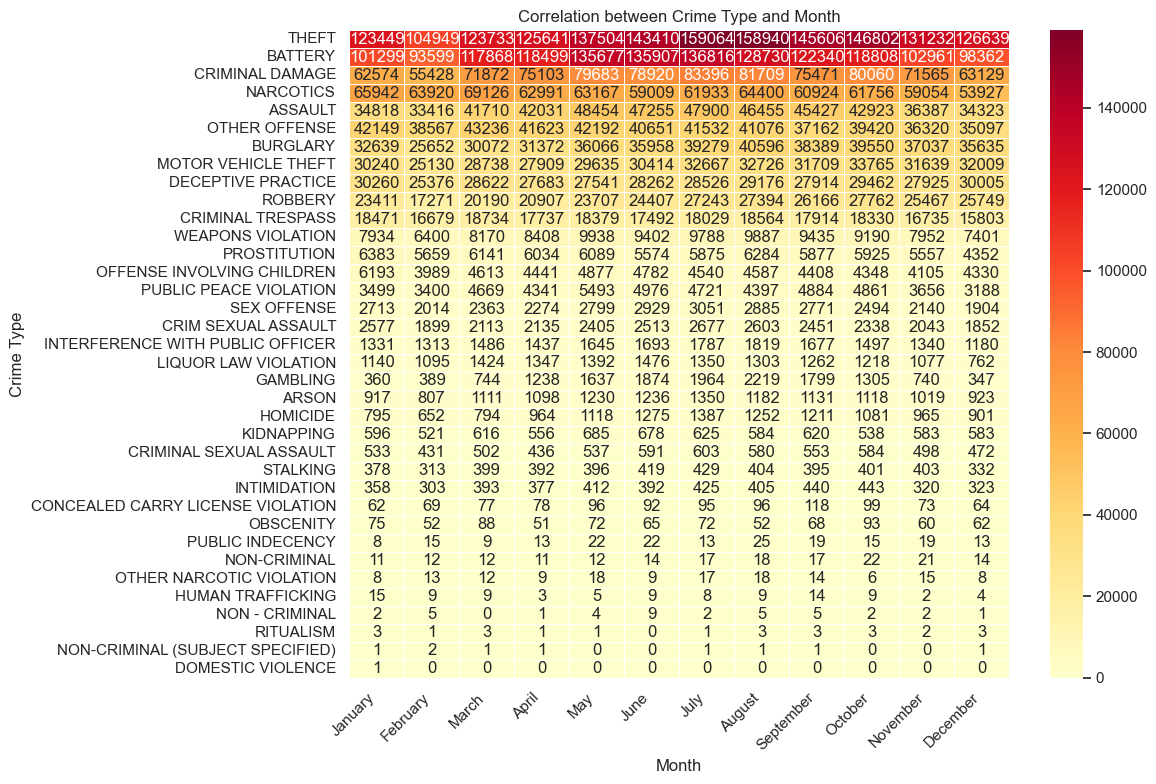

In [ ]:
# Convert 'Date' column to pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Extract month from the 'Date' column
crime_df_corr['Month'] = crime_df_corr['Date'].dt.month_name()

# Group the data by 'Primary Type' and 'Month', and calculate the count of crimes for each combination
crime_by_type_month = crime_df_corr.groupby(['Primary Type', 'Month']).size().reset_index(name='Count')

# Pivot the data for plotting the heatmap
crime_heatmap = crime_by_type_month.pivot_table(index='Primary Type', columns='Month', values='Count', fill_value=0)

# Reorder months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
crime_heatmap = crime_heatmap[month_order]

# Calculate the sum of crimes for each crime type and sort by most to least
crime_heatmap = crime_heatmap.reindex(crime_heatmap.sum(axis=1).sort_values(ascending=False).index)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crime_heatmap, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
plt.xlabel('Month')
plt.ylabel('Crime Type')
plt.title('Correlation between Crime Type and Month')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



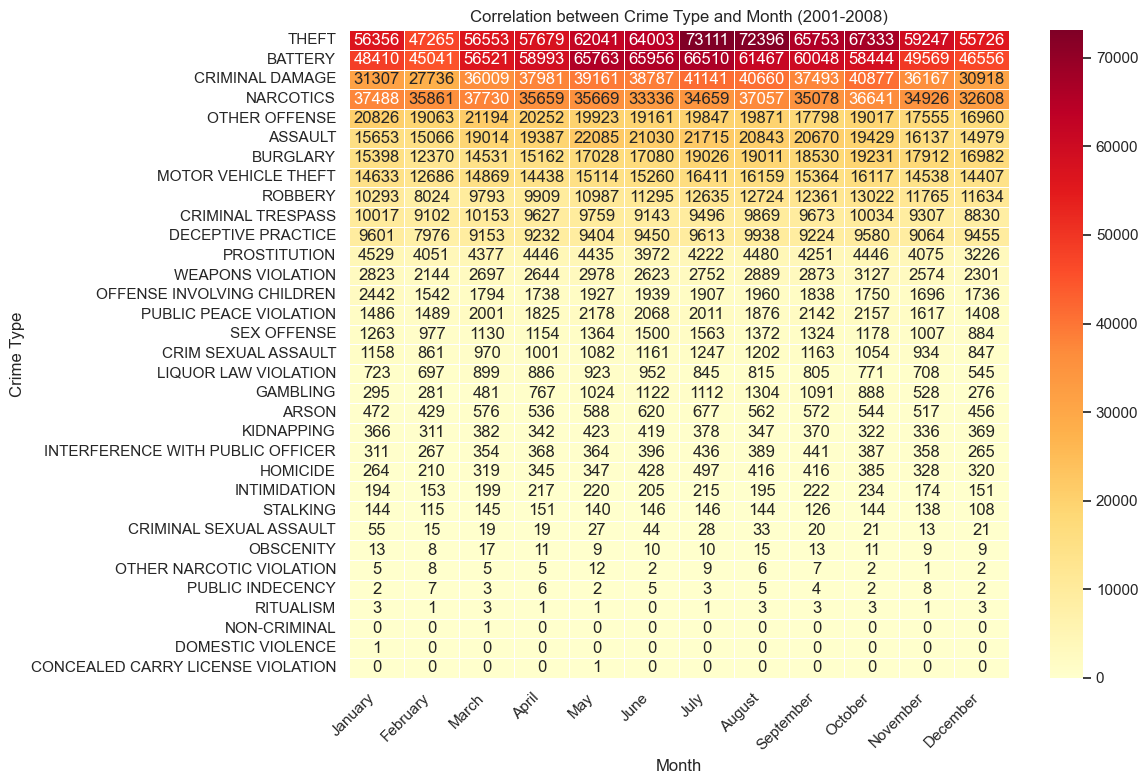

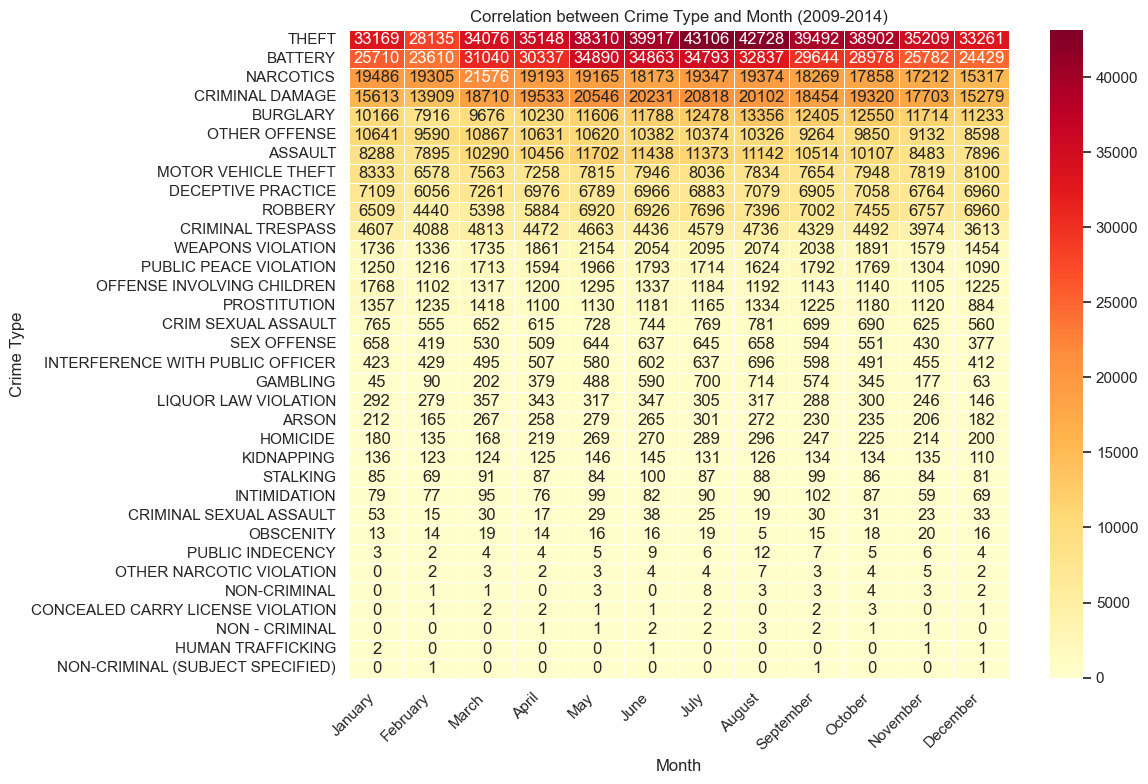

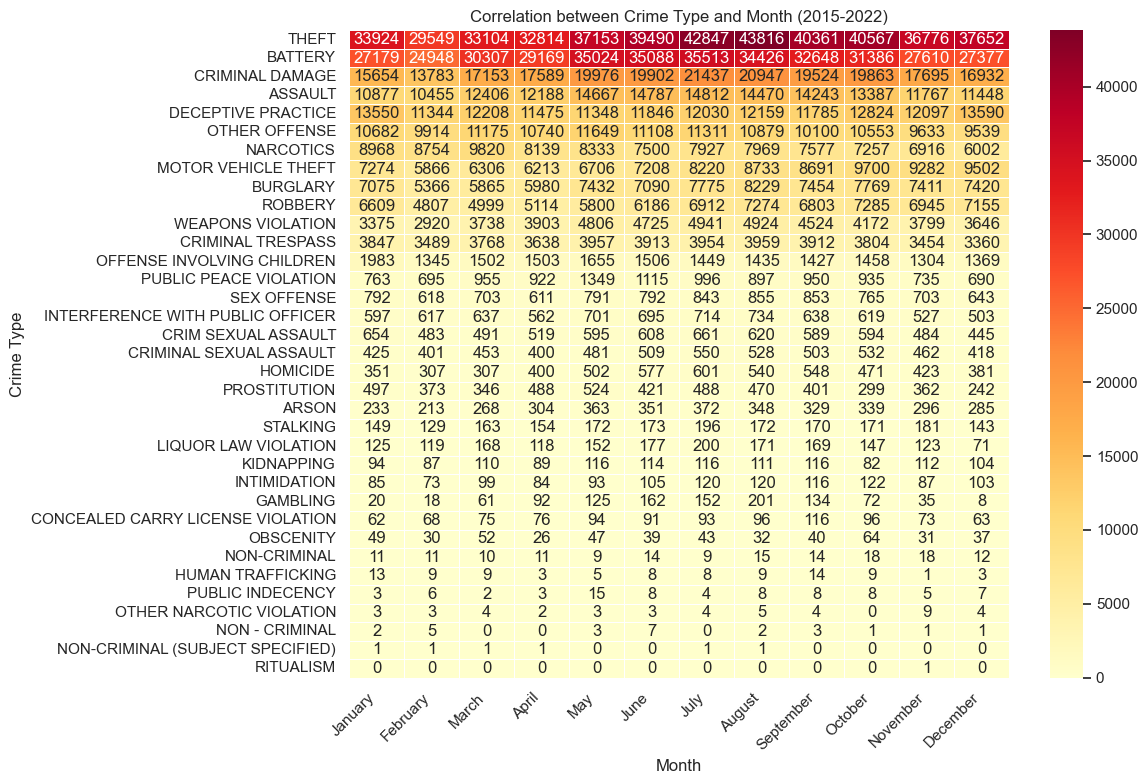

In [ ]:
# Convert 'Date' column to pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Define year ranges
year_ranges = [(2001, 2008), (2009, 2014), (2015, 2022)]

for start_year, end_year in year_ranges:
    # Filter the data for the current year range
    filtered_crimes = crime_df_corr[(crime_df_corr['Year'] >= start_year) & (crime_df_corr['Year'] <= end_year)]
    
    # Group the data by 'Primary Type' and 'Month', and calculate the count of crimes for each combination
    crime_by_type_month = filtered_crimes.groupby(['Primary Type', 'Month']).size().reset_index(name='Count')
    
    # Pivot the data for plotting the heatmap
    crime_heatmap = crime_by_type_month.pivot_table(index='Primary Type', columns='Month', values='Count', fill_value=0)
    
    # Reorder months chronologically
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    crime_heatmap = crime_heatmap[month_order]
    
    # Calculate the sum of crimes for each crime type and sort by most to least
    crime_heatmap = crime_heatmap.reindex(crime_heatmap.sum(axis=1).sort_values(ascending=False).index)
    
    # Create the heatmap for the current year range
    plt.figure(figsize=(12, 8))
    sns.heatmap(crime_heatmap, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
    plt.xlabel('Month')
    plt.ylabel('Crime Type')
    plt.title(f'Correlation between Crime Type and Month ({start_year}-{end_year})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


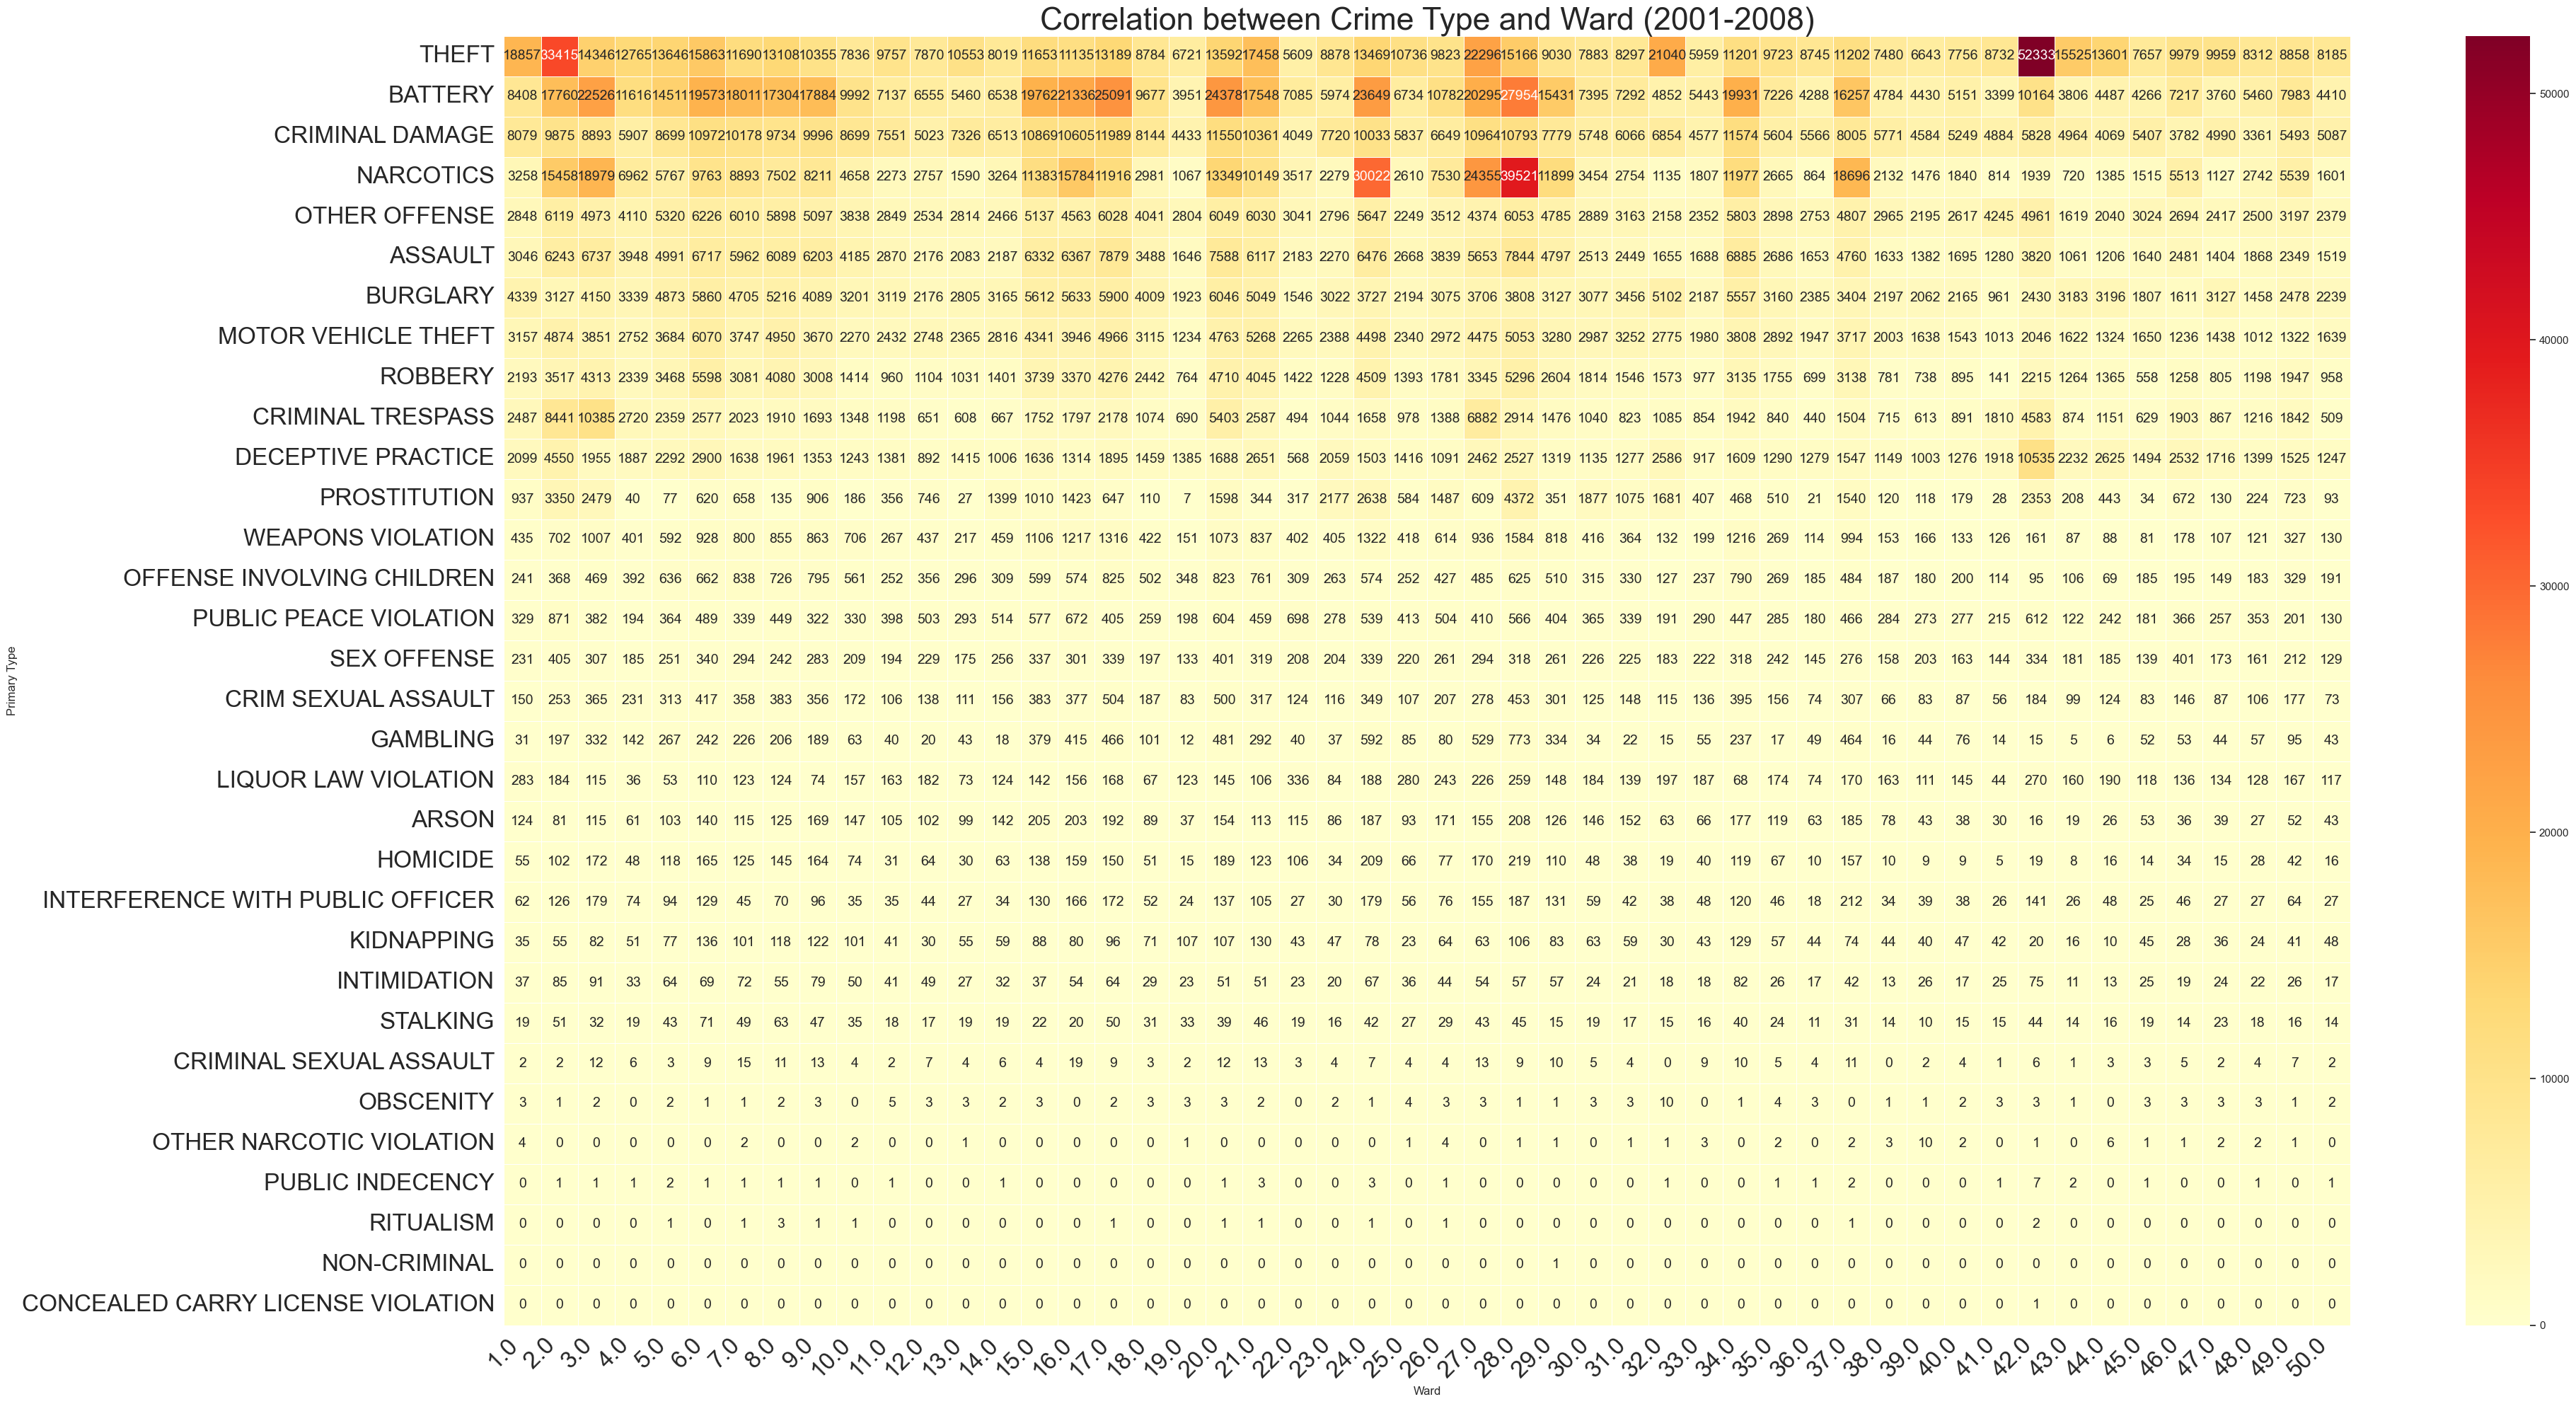

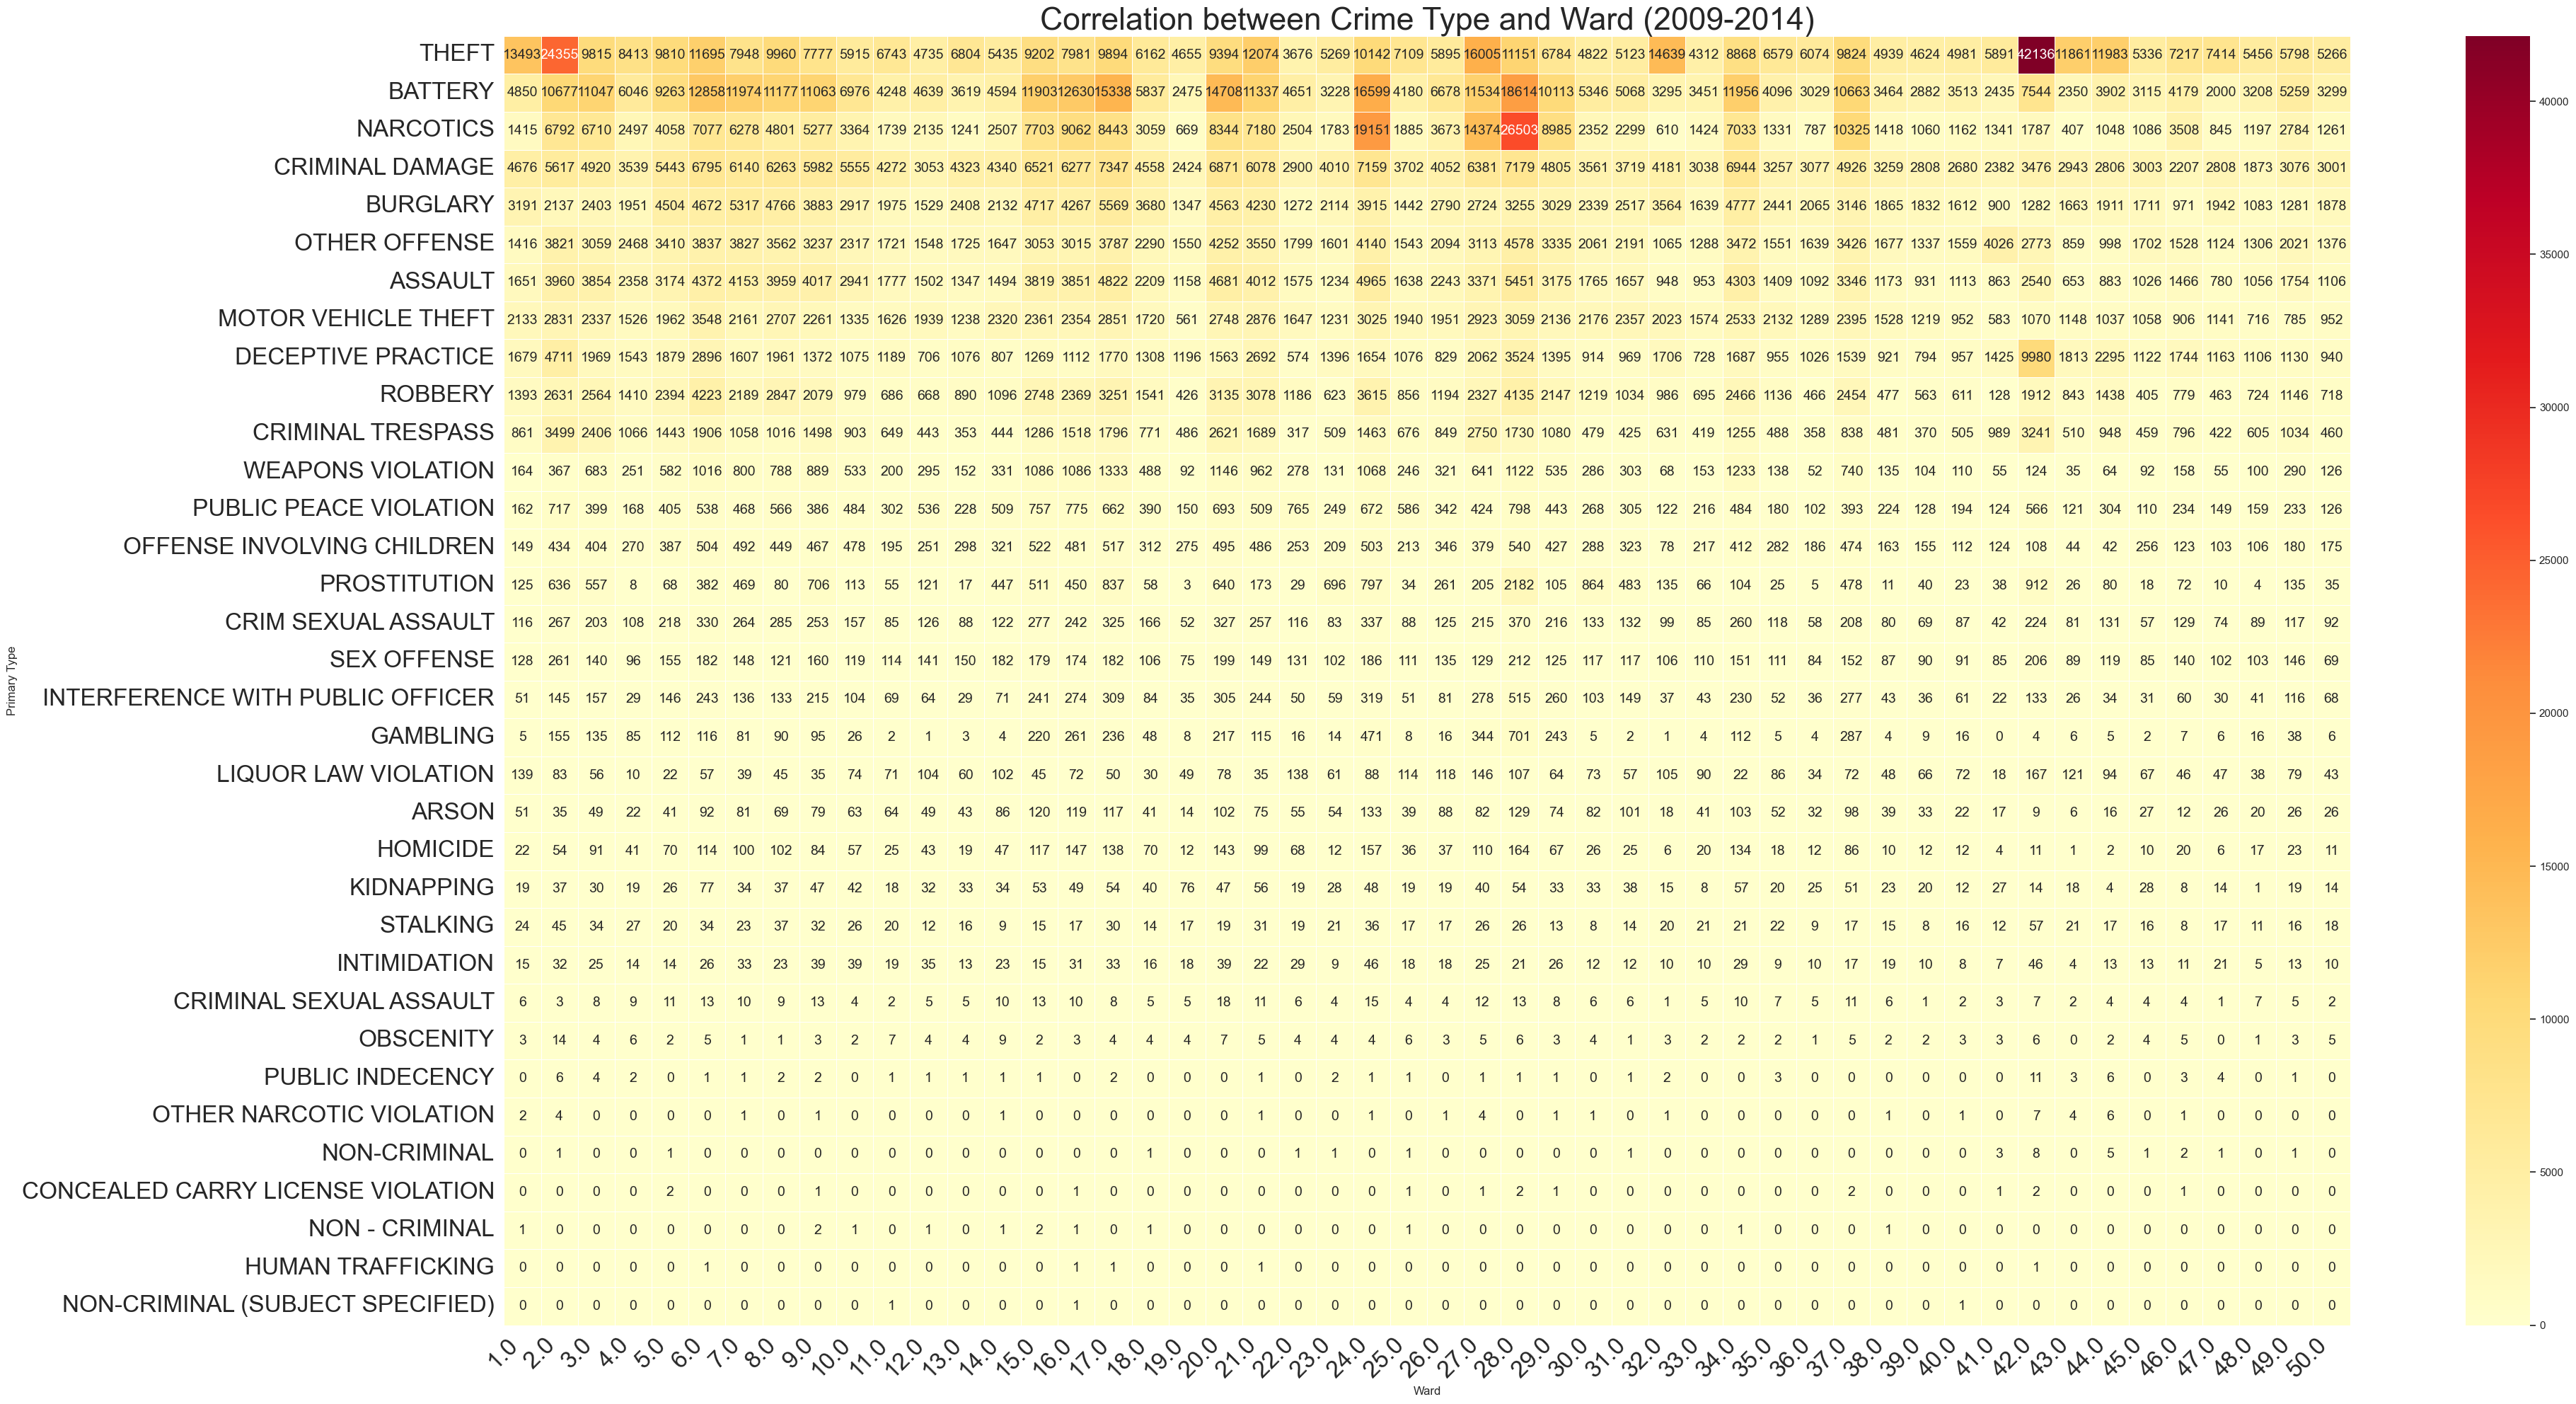

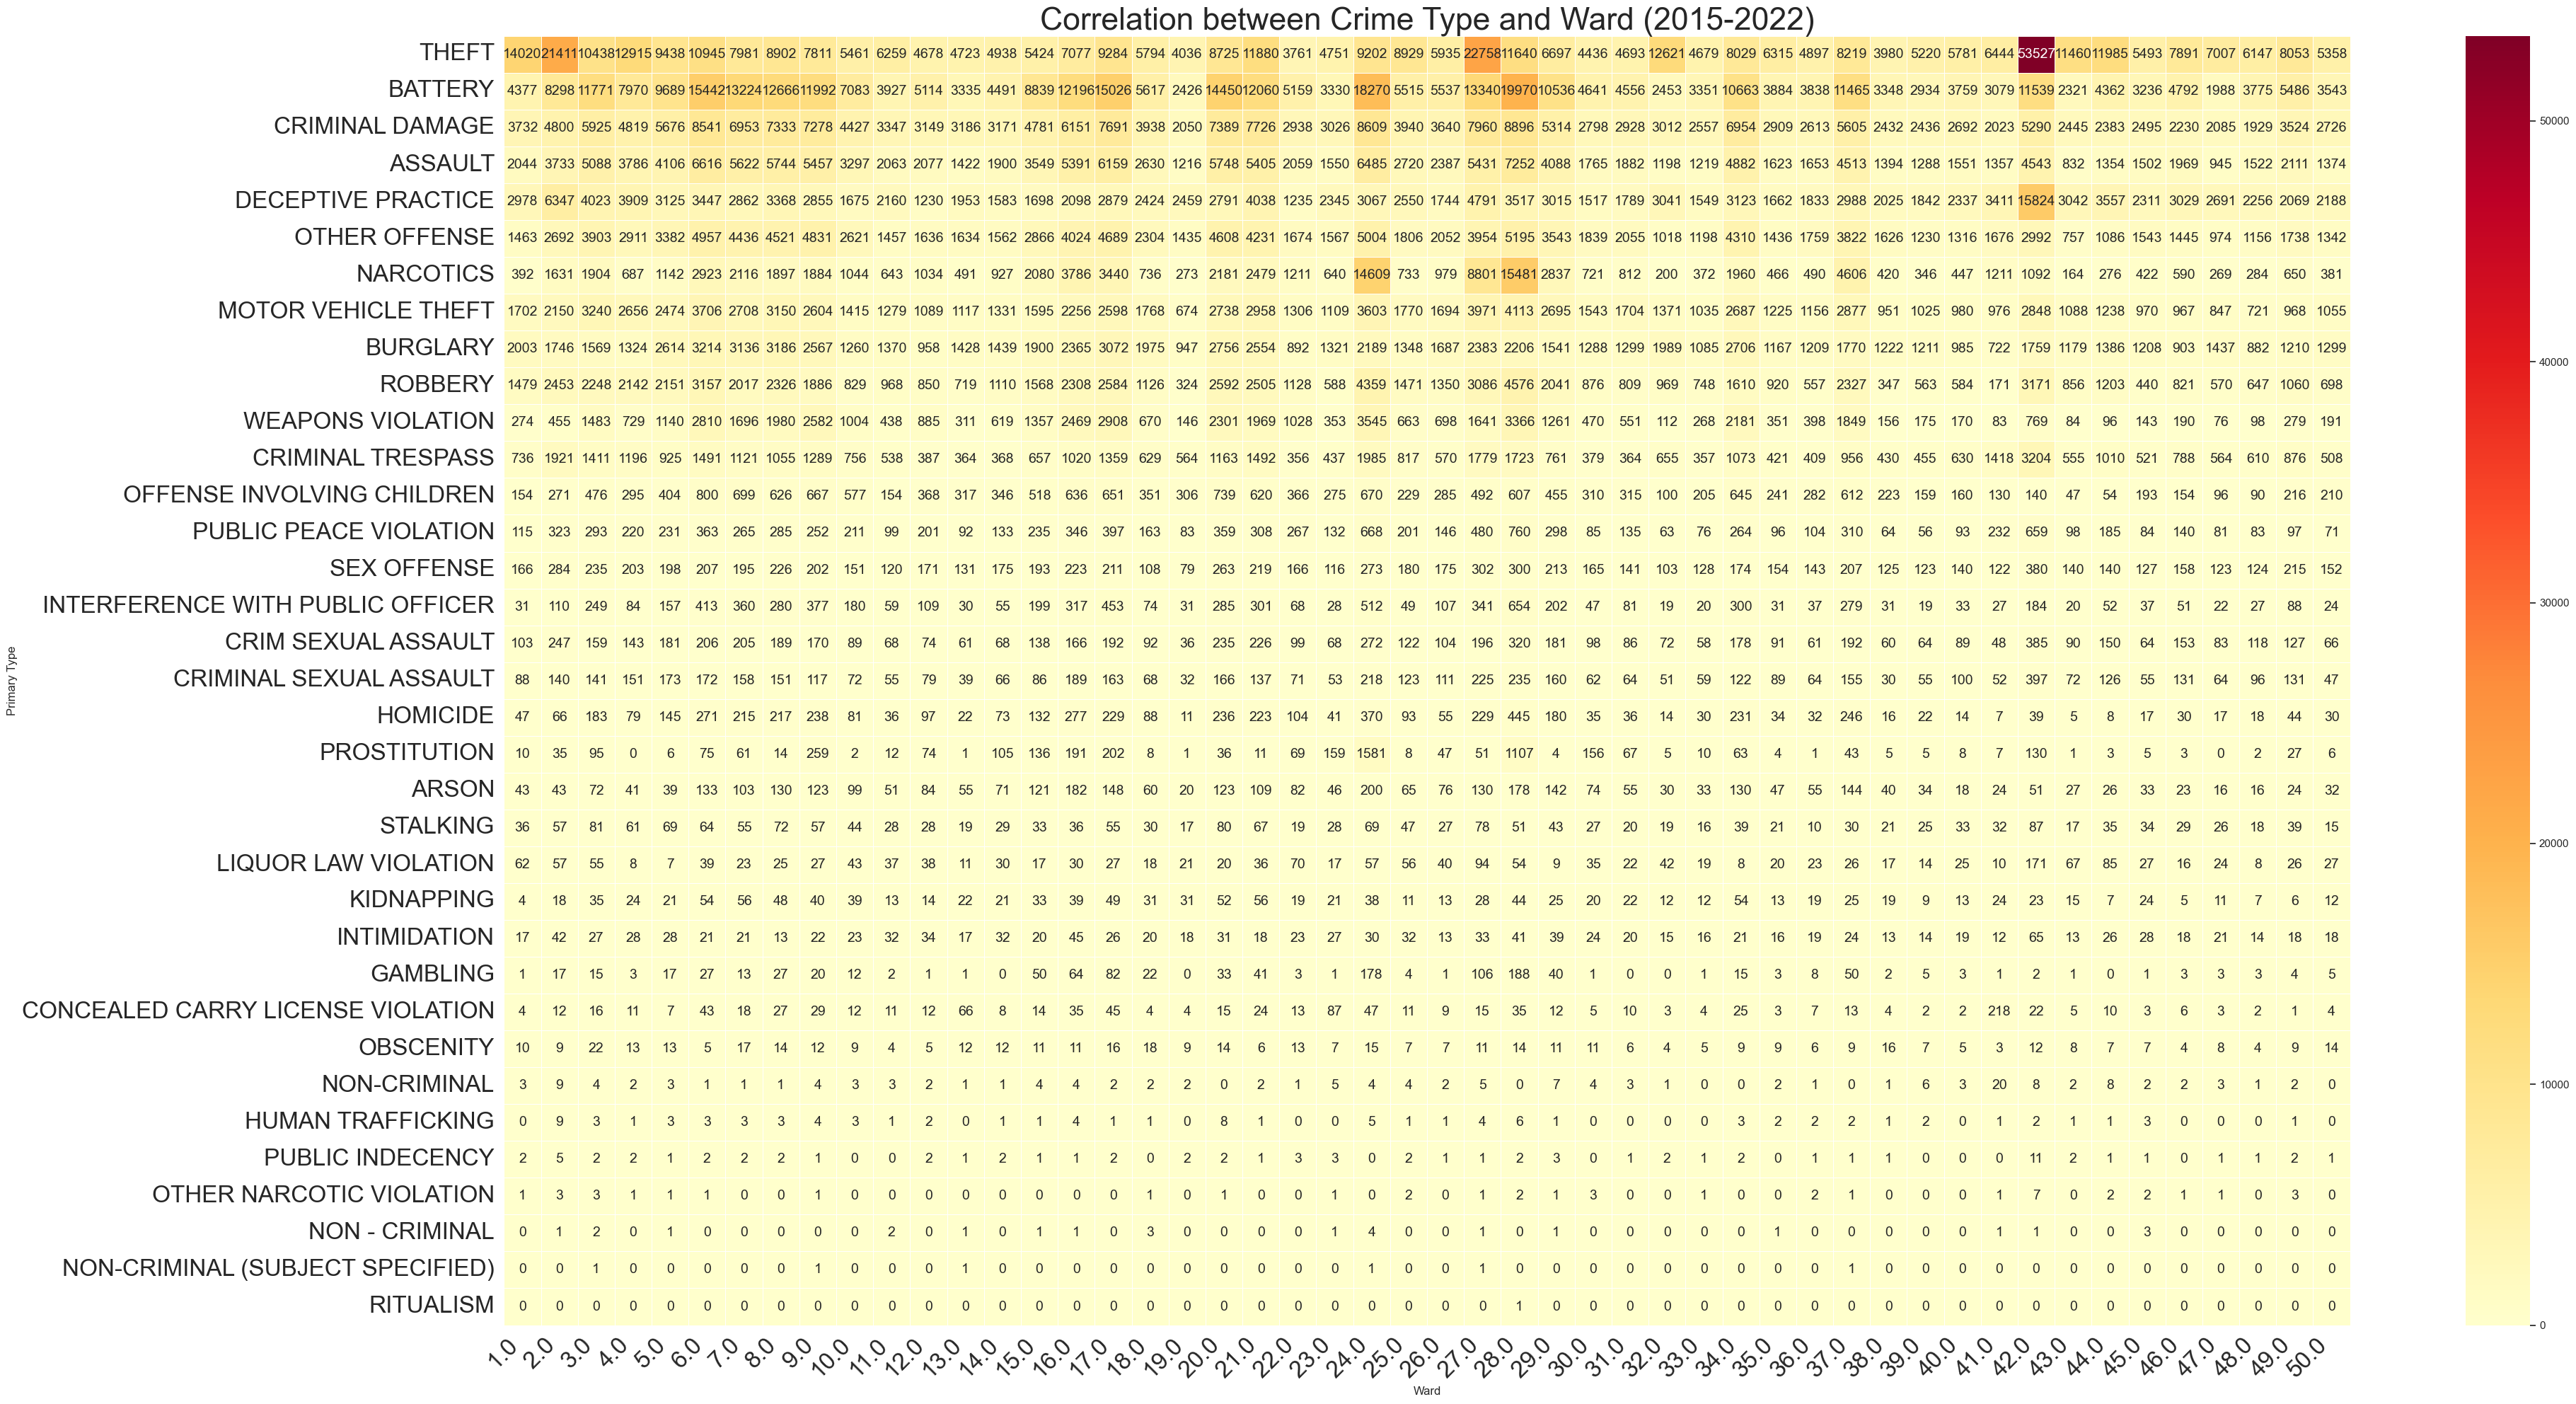

In [ ]:
# Convert 'Date' column to pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Define year ranges
year_ranges = [(2001, 2008), (2009, 2014), (2015, 2022)]

for start_year, end_year in year_ranges:
    # Filter the data for the current year range
    filtered_crimes = crime_df_corr[(crime_df_corr['Year'] >= start_year) & (crime_df_corr['Year'] <= end_year)]
    
    # Group the data by 'Primary Type' and 'Ward', and calculate the count of crimes for each combination
    crime_by_type_ward = filtered_crimes.groupby(['Primary Type', 'Ward']).size().reset_index(name='Count')
    
    # Pivot the data for plotting the heatmap
    crime_heatmap = crime_by_type_ward.pivot_table(index='Primary Type', columns='Ward', values='Count', fill_value=0)
    
    # Calculate the sum of crimes for each crime type and sort by most to least
    crime_heatmap = crime_heatmap.reindex(crime_heatmap.sum(axis=1).sort_values(ascending=False).index)
    
   # Create the heatmap for the current year range
    plt.figure(figsize=(40, 20))
    sns.heatmap(crime_heatmap, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5, annot_kws={'fontsize': 14})
    # plt.xlabel('Ward', fontsize=24)
    # plt.ylabel('Crime Type', fontsize=24)
    plt.title(f'Correlation between Crime Type and Ward ({start_year}-{end_year})', fontsize=32)
    plt.xticks(rotation=45, ha='right', fontsize=24)
    plt.yticks(fontsize=24)
    plt.tight_layout()
    plt.show()


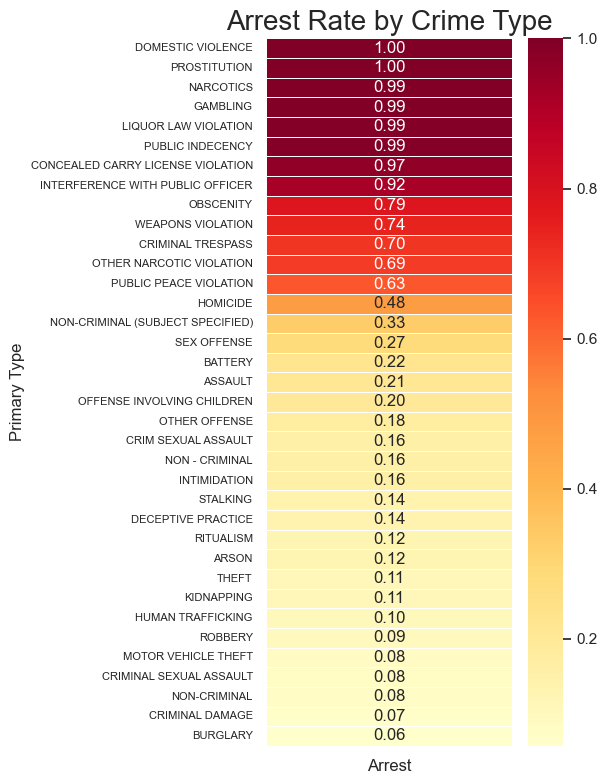

In [ ]:
# Convert 'Date' column to pandas datetime object
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])

# Calculate the arrest rate for each crime type
crime_arrest_rate = crime_df_corr.groupby('Primary Type')['Arrest'].mean().reset_index()

# Pivot the data for plotting the heatmap
crime_heatmap_arrest = crime_arrest_rate.pivot_table(index='Primary Type', values='Arrest', fill_value=0)

# Calculate the sum of arrests for each crime type and sort by highest arrest rate
crime_heatmap_arrest = crime_heatmap_arrest.reindex(crime_heatmap_arrest.mean(axis=1).sort_values(ascending=False).index)

# Create the heatmap for the arrest rate by crime type
plt.figure(figsize=(6, 8))
sns.heatmap(crime_heatmap_arrest, cmap='YlOrRd', annot=True, fmt='.2f', linewidths=0.5, annot_kws={'fontsize': 12})
# plt.xlabel('Arrest Rate', fontsize=16)
# plt.ylabel('Crime Type', fontsize=16)
plt.title('Arrest Rate by Crime Type', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
top_15_primary_type_counts = crime_df_corr['Primary Type'].value_counts().head(15)

print(top_15_primary_type_counts)


Primary Type
THEFT                         1626969
BATTERY                       1410866
CRIMINAL DAMAGE                878910
NARCOTICS                      746149
ASSAULT                        501099
OTHER OFFENSE                  479025
BURGLARY                       422245
MOTOR VEHICLE THEFT            366581
DECEPTIVE PRACTICE             340752
ROBBERY                        289674
CRIMINAL TRESPASS              212867
WEAPONS VIOLATION              103905
PROSTITUTION                    69750
OFFENSE INVOLVING CHILDREN      55213
PUBLIC PEACE VIOLATION          52085
Name: count, dtype: int64


In [ ]:
top_15_location_counts = crime_df_corr['Location Description'].value_counts().head(15)

print(top_15_location_counts)

Location Description
STREET                            2005150
RESIDENCE                         1297045
APARTMENT                          865554
SIDEWALK                           725870
OTHER                              270017
PARKING LOT/GARAGE(NON.RESID.)     202985
ALLEY                              171237
SCHOOL, PUBLIC, BUILDING           146387
SMALL RETAIL STORE                 145206
RESIDENCE-GARAGE                   135543
RESTAURANT                         125734
RESIDENCE PORCH/HALLWAY            124208
VEHICLE NON-COMMERCIAL             123084
GROCERY FOOD STORE                  97970
DEPARTMENT STORE                    97483
Name: count, dtype: int64


In [ ]:
top_15_primary_type_counts = crime_df_corr['Primary Type'].value_counts().head(15)
top_15_location_counts = crime_df_corr['Location Description'].value_counts().head(15)

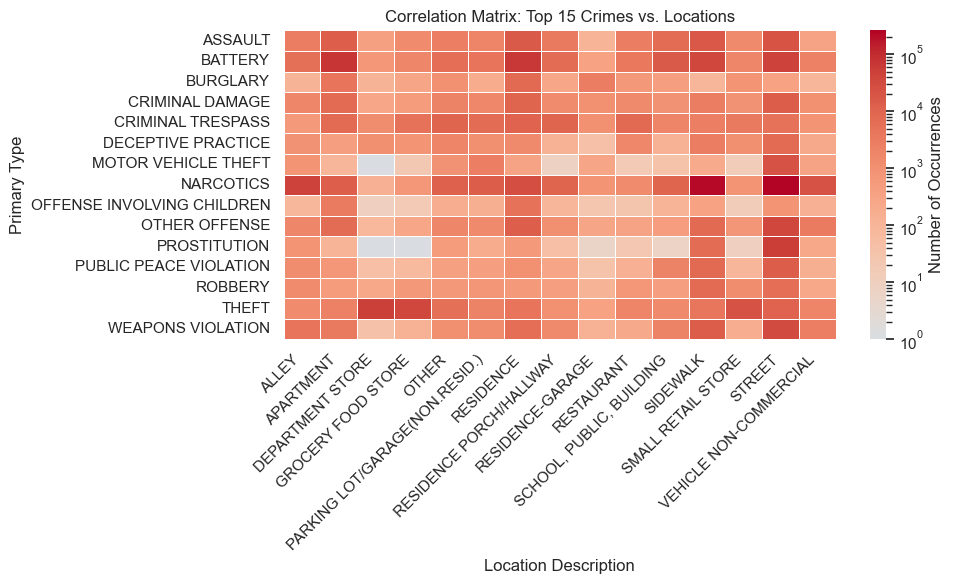

In [ ]:
from matplotlib.colors import LogNorm

# Assuming you have a DataFrame called 'crime_df_corr'
top_15_primary_type_counts = crime_df_corr['Primary Type'].value_counts().head(15)
top_15_location_counts = crime_df_corr['Location Description'].value_counts().head(15)

# Filter the DataFrame to include only the top 15 primary types and top 15 locations
filtered_df = crime_df_corr[
    crime_df_corr['Primary Type'].isin(top_15_primary_type_counts.index) &
    crime_df_corr['Location Description'].isin(top_15_location_counts.index)
]

# Create a pivot table to calculate the frequency of each primary type at each location
correlation_matrix = pd.pivot_table(
    filtered_df,
    index='Primary Type',
    columns='Location Description',
    values='Arrest',
    aggfunc='sum',
    fill_value=0
)

# Create a custom color palette for more pronounced color variation
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create a heatmap using Seaborn with the custom color palette
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    cmap=cmap,
    annot=False,  # Remove values in the squares
    linewidths=0.5,
    cbar_kws={'label': 'Number of Occurrences'},  # Add a colorbar label
    norm=LogNorm(),  # Use logarithmic scale for color map
    cbar=True,
    center=correlation_matrix.values.mean()  # Adjust the center to enhance contrast
)
plt.title('Correlation Matrix: Top 15 Crimes vs. Locations')
plt.xlabel('Location Description')
plt.ylabel('Primary Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



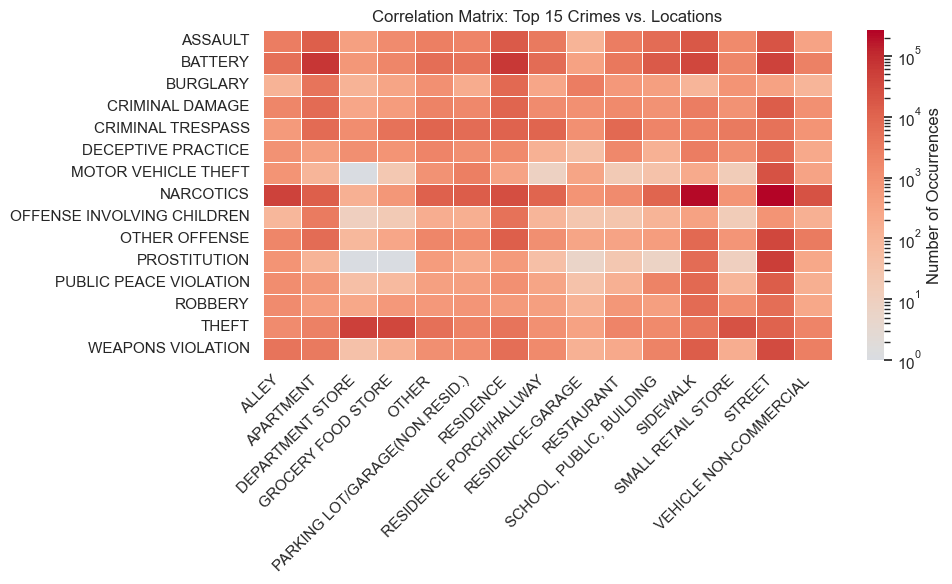

In [ ]:
from matplotlib.colors import LogNorm

# Assuming you have a DataFrame called 'crime_df_corr'
top_15_primary_type_counts = crime_df_corr['Primary Type'].value_counts().head(15)
top_15_location_counts = crime_df_corr['Location Description'].value_counts().head(15)

# Filter the DataFrame to include only the top 15 primary types and top 15 locations
filtered_df = crime_df_corr[
    crime_df_corr['Primary Type'].isin(top_15_primary_type_counts.index) &
    crime_df_corr['Location Description'].isin(top_15_location_counts.index)
]

# Create a pivot table to calculate the frequency of each primary type at each location
correlation_matrix = pd.pivot_table(
    filtered_df,
    index='Primary Type',
    columns='Location Description',
    values='Arrest',
    aggfunc='sum',
    fill_value=0
)

# Create a custom color palette for more pronounced color variation
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create a heatmap using Seaborn with the custom color palette
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    cmap=cmap,
    annot=False,  # Remove values in the squares
    linewidths=0.5,
    cbar_kws={'label': 'Number of Occurrences'},  # Add a colorbar label
    norm=LogNorm(),  # Use logarithmic scale for color map
    cbar=True,
    center=correlation_matrix.values.mean()  # Adjust the center to enhance contrast
)
plt.title('Correlation Matrix: Top 15 Crimes vs. Locations')
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
crime_df_corr.head(1)

Date Primary Type Location Description  Arrest  Domestic  \
0 2018-09-01 00:01:00        THEFT            RESIDENCE   False      True   

   District  Ward  Year      Month  Day  DayOfWeek  Time_of_Day      Time  \
0       6.0   8.0  2018  September    1          5            0  00:01:00   

   Hour  Time of Day  
0     0            0

<Figure size 1000x600 with 0 Axes>

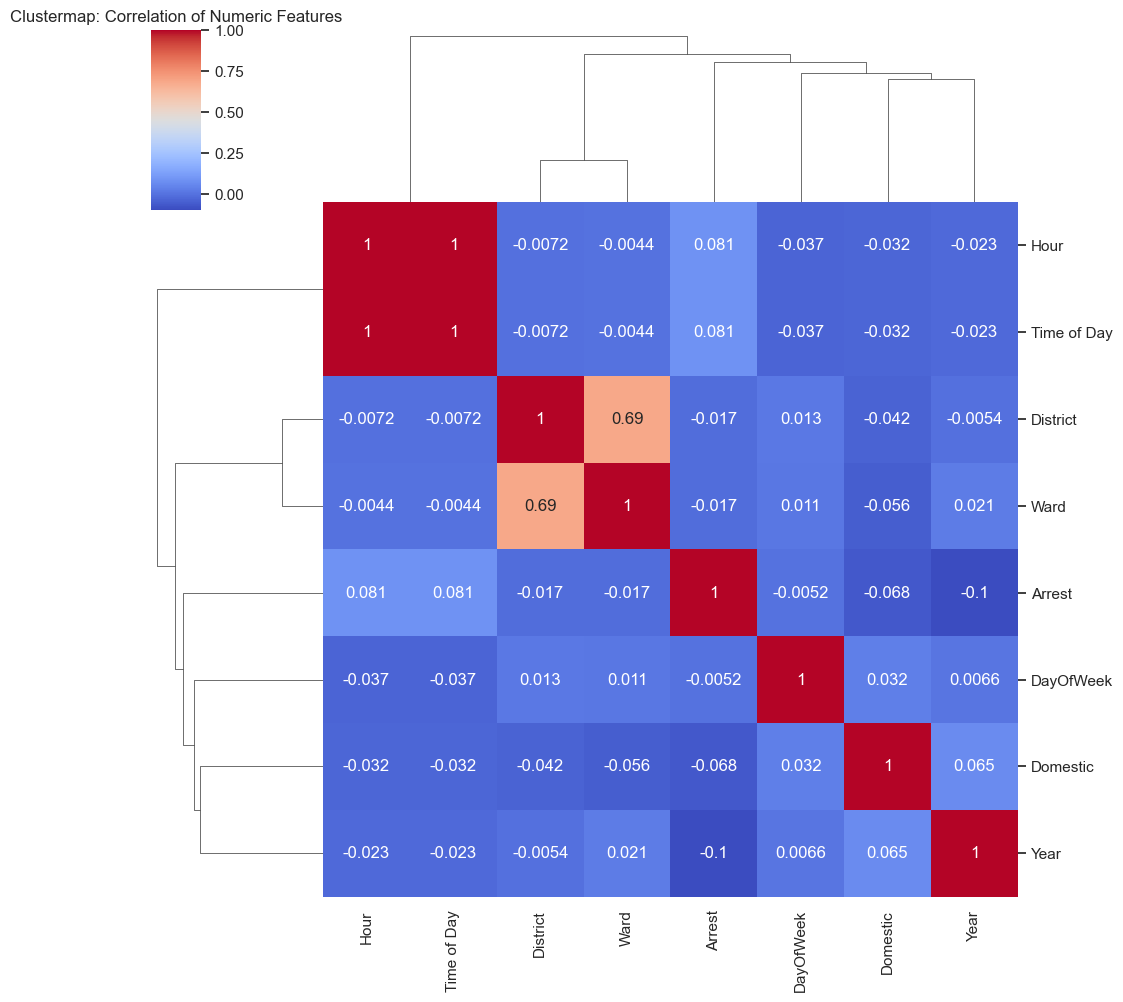

In [ ]:
# Drop non-numeric columns for clustering
numeric_columns = ['Arrest', 'Domestic', 'District', 'Ward', 'Year', 'DayOfWeek', 'Hour', 'Time of Day']
numeric_data = crime_df_corr[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a clustermap
plt.figure(figsize=(10, 6))
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Clustermap: Correlation of Numeric Features')
plt.show()

In [ ]:
# Group the data by 'Primary Type' and count the occurrences of each type
primary_type_counts = crime_df_corr['Primary Type'].value_counts()

# Get the top ten highest unique values in 'Primary Type'
top_ten_primary_types = primary_type_counts.nlargest(10).index

# Create a DataFrame containing only the top ten primary types
top_ten_crimes = crime_df_corr[crime_df_corr['Primary Type'].isin(top_ten_primary_types)]

# Group the data by 'Primary Type' and 'Arrest' and count the occurrences of each combination
arrest_counts = top_ten_crimes.groupby(['Primary Type', 'Arrest']).size().reset_index(name='Count')

# Pivot the data to get 'True' and 'False' arrests as separate columns
arrest_counts_pivot = arrest_counts.pivot(index='Primary Type', columns='Arrest', values='Count').reset_index()

# Fill NaN values with 0 (occurs when a combination is not present in the data)
arrest_counts_pivot = arrest_counts_pivot.fillna(0)

arrest_counts_pivot = arrest_counts_pivot.rename(columns={False: 'Not Arrested', True: 'Arrested'})

# Print the resulting DataFrame showing the total number of True and False arrests for each top ten primary type
print(arrest_counts_pivot)


Arrest         Primary Type  Not Arrested  Arrested
0                   ASSAULT        393923    107176
1                   BATTERY       1099604    311262
2                  BURGLARY        398073     24172
3           CRIMINAL DAMAGE        819607     59303
4        DECEPTIVE PRACTICE        294605     46147
5       MOTOR VEHICLE THEFT        335840     30741
6                 NARCOTICS          4475    741674
7             OTHER OFFENSE        394745     84280
8                   ROBBERY        262410     27264
9                     THEFT       1444050    182919


In [ ]:
crime_df_corr

Date                Primary Type Location Description  \
0       2018-09-01 00:01:00                       THEFT            RESIDENCE   
1       2016-05-01 00:25:00          DECEPTIVE PRACTICE                  NaN   
2       2018-07-31 13:30:00                   NARCOTICS               STREET   
3       2018-12-19 16:30:00             CRIMINAL DAMAGE               STREET   
4       2015-02-02 10:00:00          DECEPTIVE PRACTICE                OTHER   
...                     ...                         ...                  ...   
7846797 2022-01-01 00:01:00               OTHER OFFENSE            APARTMENT   
7846798 2022-12-22 12:00:00          DECEPTIVE PRACTICE                  NaN   
7846799 2021-04-01 00:00:00          DECEPTIVE PRACTICE            RESIDENCE   
7846800 2015-11-03 12:00:00  OFFENSE INVOLVING CHILDREN            RESIDENCE   
7846801 2021-12-19 14:30:00          DECEPTIVE PRACTICE                  NaN   

         Arrest  Domestic  District  Ward  Year      Month  Day  DayOfWeek  \
0         False      True       6.0   8.0  2018  September    1          5   
1         False     False       8.0  15.0  2016        May    1          6   
2          True     False       2.0   5.0  2018       July   31          1   
3         False     False      25.0  31.0  2018   December   19          2   
4         False     False       8.0  23.0  2015   February    2          0   
...         ...       ...       ...   ...   ...        ...  ...        ...   
7846797   False     False      19.0  46.0  2022    January    1          5   
7846798   False     False      19.0  44.0  2022   December   22          3   
7846799   False     False       6.0  17.0  2021      April    1          3   
7846800   False     False      19.0  47.0  2015   November    3          1   
7846801   False     False      14.0  26.0  2021   December   19          6   

         Time_of_Day      Time  Hour  Time of Day  
0                  0  00:01:00     0            0  
1                  0  00:25:00     0            0  
2                  1  13:30:00    13           13  
3                  1  16:30:00    16           16  
4                  0  10:00:00    10           10  
...              ...       ...   ...          ...  
7846797            0  00:01:00     0            0  
7846798            1  12:00:00    12           12  
7846799            0  00:00:00     0            0  
7846800            1  12:00:00    12           12  
7846801            1  14:30:00    14           14  

[7712492 rows x 15 columns]

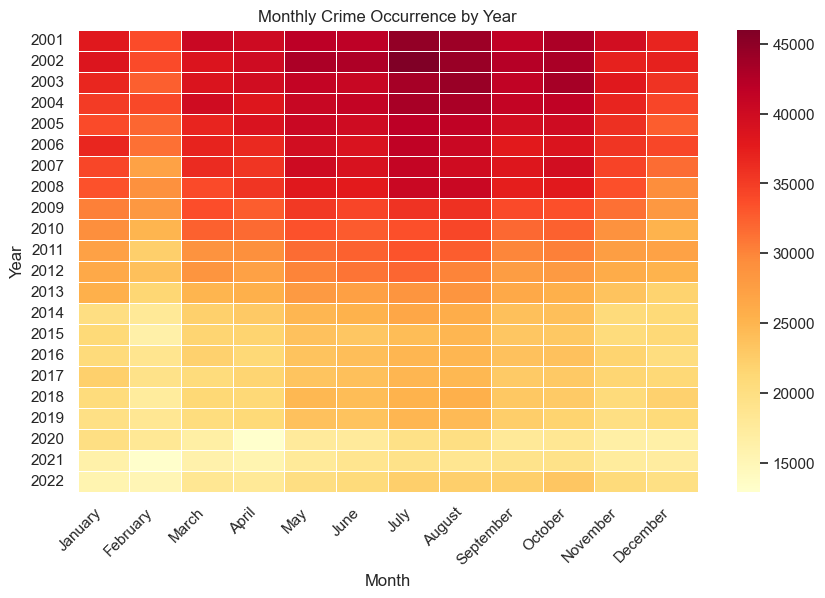

In [ ]:
# Convert 'Year' and 'Month' columns to datetime format
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])
crime_df_corr['Year'] = crime_df_corr['Date'].dt.year
crime_df_corr['Month'] = crime_df_corr['Date'].dt.month_name()

# Group the data by 'Year' and 'Month' and count the occurrences of crimes
crime_by_month = crime_df_corr.groupby(['Year', 'Month']).size().unstack().fillna(0)

# Reorder the columns to be in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
crime_by_month = crime_by_month[month_order]

# Create the heatmap with full month names on the y-axis
plt.figure(figsize=(10, 6))
sns.heatmap(crime_by_month, cmap='YlOrRd', annot=False, fmt='d', linewidths=0.5, xticklabels=True, yticklabels=True)
plt.title('Monthly Crime Occurrence by Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

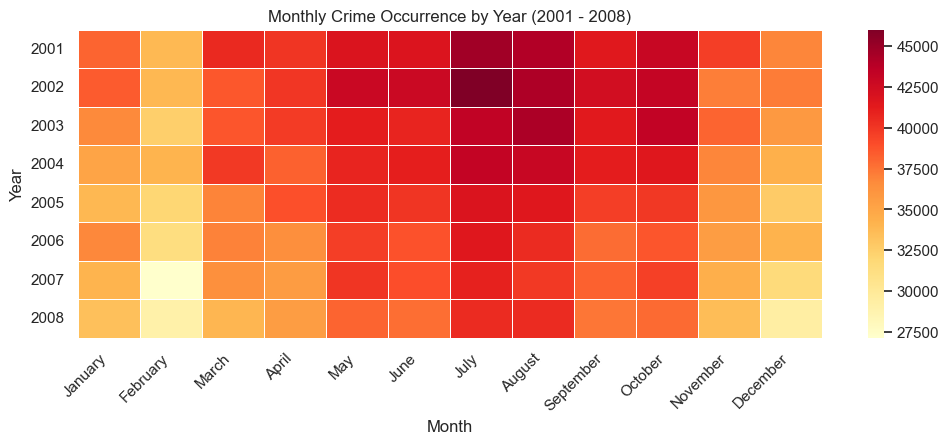

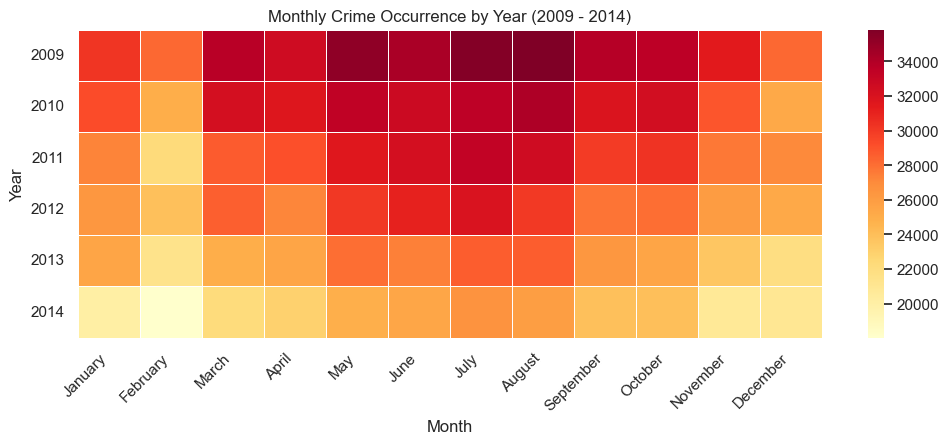

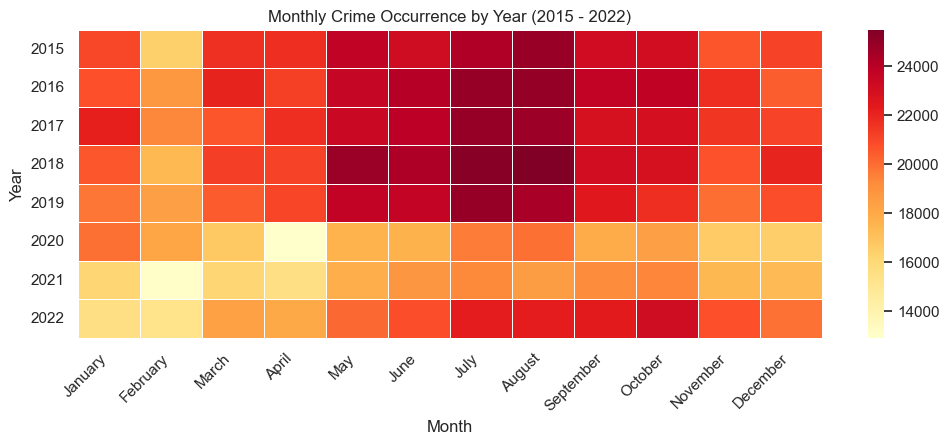

In [ ]:
# Convert 'Year' and 'Month' columns to datetime format
crime_df_corr['Date'] = pd.to_datetime(crime_df_corr['Date'])
crime_df_corr['Year'] = crime_df_corr['Date'].dt.year
crime_df_corr['Month'] = crime_df_corr['Date'].dt.month_name()

# Define year ranges
year_ranges = [(2001, 2008), (2009, 2014), (2015, 2022)]

# Loop through year ranges and create separate heatmaps
for start_year, end_year in year_ranges:
    filtered_crime_df = crime_df_corr[(crime_df_corr['Year'] >= start_year) & (crime_df_corr['Year'] <= end_year)]
    
    # Group the data by 'Year' and 'Month' and count the occurrences of crimes
    crime_by_month = filtered_crime_df.groupby(['Year', 'Month']).size().unstack().fillna(0)
    
    # Reorder the columns to be in chronological order
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    crime_by_month = crime_by_month[month_order]
    
    # Create the heatmap with full month names on the y-axis
    plt.figure(figsize=(12, 4))
    sns.heatmap(crime_by_month, cmap='YlOrRd', annot=False, fmt='d', linewidths=0.5, xticklabels=True, yticklabels=True)
    plt.title(f'Monthly Crime Occurrence by Year ({start_year} - {end_year})')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()


In [ ]:
# Count the occurrences of each time in 'Time_of_Day' column
time_counts = crime_df_corr['Time_of_Day'].value_counts()

# Get the most common time
most_common_time = time_counts.idxmax()

print("The most common time for an incident to occur is:", most_common_time)

The most common time for an incident to occur is: 1


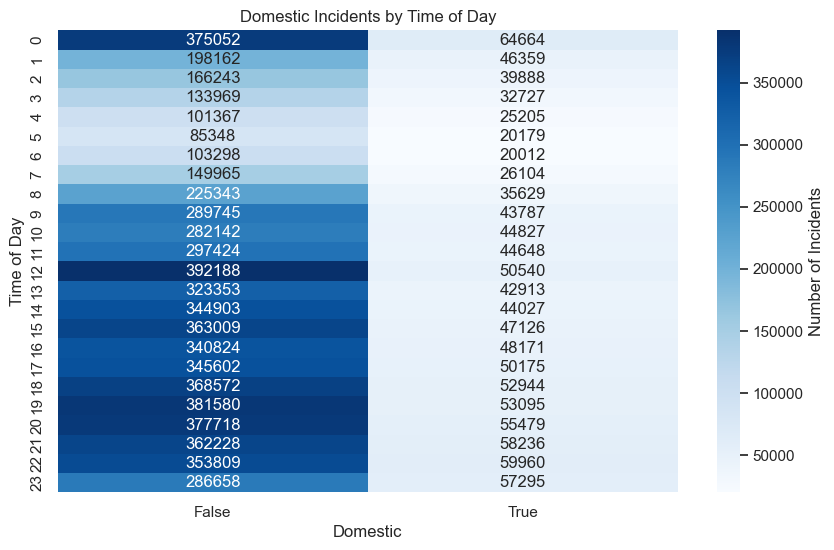

In [ ]:
# Assuming your 'crime_df_corr' DataFrame contains a 'Date' column representing the date and time of each crime
# You may need to extract the time of day from the 'Date' column, if it's not already available in the DataFrame
# For example, you can do this:
crime_df_corr['Time of Day'] = crime_df_corr['Date'].dt.hour

# Create a pivot table to get the count of 'Domestic' occurrences for each time of day
domestic_pivot = crime_df_corr.pivot_table(index='Time of Day', columns='Domestic', values='Date', aggfunc='count', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(domestic_pivot, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Incidents'})
plt.xlabel('Domestic')
plt.ylabel('Time of Day')
plt.title('Domestic Incidents by Time of Day')
plt.show()


In [ ]:
# Assuming your 'crime_df_corr' DataFrame contains the 'Domestic' column
true_count = crime_df_corr['Domestic'].sum()
print("Total number of True values in 'Domestic':", true_count)

Total number of True values in 'Domestic': 1063990


In [ ]:
# Create a cross-tabulation (crosstab) between 'Primary Type' and 'Domestic'
domestic_crosstab = pd.crosstab(crime_df_corr['Primary Type'], crime_df_corr['Domestic'])

# Rename the columns to be more descriptive
domestic_crosstab = domestic_crosstab.rename(columns={False: 'False (Not Domestic)', True: 'True (Domestic)'})

# Add a third column for the percentage of True values in 'Domestic'
domestic_crosstab['Percent True'] = round((domestic_crosstab['True (Domestic)'] / (domestic_crosstab['True (Domestic)'] + domestic_crosstab['False (Not Domestic)'])) * 100, 2)

# Sort the DataFrame by the values in the 'Percent True' column in descending order
domestic_crosstab_sorted = domestic_crosstab.sort_values(by='Percent True', ascending=False)

# Remove the rows with the primary types 'DOMESTIC VIOLENCE' and 'NON-CRIMINAL (SUBJECT SPECIFIED)' (as they are always 100%)
domestic_crosstab_sorted = domestic_crosstab_sorted.drop(['DOMESTIC VIOLENCE', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], axis=0)

# Print the filtered result (top 15 primary types with the highest True values in 'Domestic' along with the percentage)
print("Top 15 primary types with the highest True values in 'Domestic' and their percentage:")
print(tabulate(domestic_crosstab_sorted.head(15), headers='keys', tablefmt='psql'))




Top 15 primary types with the highest True values in 'Domestic' and their percentage:
+----------------------------+------------------------+-------------------+----------------+
| Primary Type               |   False (Not Domestic) |   True (Domestic) |   Percent True |
|----------------------------+------------------------+-------------------+----------------|
| OFFENSE INVOLVING CHILDREN |                  25086 |             30127 |          54.57 |
| BATTERY                    |                 793824 |            617042 |          43.73 |
| STALKING                   |                   2681 |              1980 |          42.48 |
| OTHER OFFENSE              |                 335304 |            143721 |          30    |
| KIDNAPPING                 |                   5205 |              1980 |          27.56 |
| RITUALISM                  |                     18 |                 6 |          25    |
| ASSAULT                    |                 386656 |            114443 |  

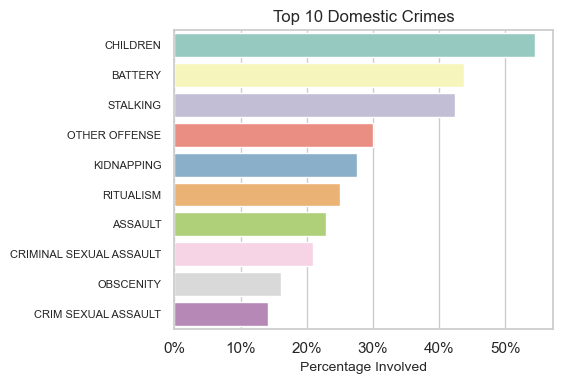

In [ ]:
# Replace the y-axis tick labels directly
domestic_crosstab_sorted.index = domestic_crosstab_sorted.index.where(
    ~domestic_crosstab_sorted.index.isin(['OFFENSE INVOLVING CHILDREN']), 'CHILDREN')
domestic_crosstab_sorted.index = domestic_crosstab_sorted.index.where(
    ~domestic_crosstab_sorted.index.isin(['CRIMINAL SEXUAL ACTIVITY']), 'SEXUAL ASSAULT')

# Create a bar plot for the top 10 primary types
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=domestic_crosstab_sorted['Percent True'].head(10), y=domestic_crosstab_sorted.index[:10], palette='Set3')

# Format the x-axis tick labels to display percentages
formatter = ticker.PercentFormatter(xmax=100)
ax.xaxis.set_major_formatter(formatter)

plt.xlabel('Percentage Involved', fontsize=10)

# Update y-axis tick labels font size
plt.yticks(fontsize=8)

plt.title('Top 10 Domestic Crimes', fontsize=12)
plt.tight_layout()

# Hide the y-axis label
ax.set(ylabel='')

# Show the plot
plt.show()

In [ ]:
# Create a cross-tabulation (crosstab) between 'Primary Type' and 'Domestic'
domestic_crosstab = pd.crosstab(crime_df_corr['Primary Type'], crime_df_corr['Domestic'])

# Rename the columns to be more descriptive
domestic_crosstab = domestic_crosstab.rename(columns={False: 'False (Not Domestic)', True: 'True (Domestic)'})

# Add a third column for the percentage of True values in 'Domestic'
domestic_crosstab['Percent True'] = round((domestic_crosstab['True (Domestic)'] / (domestic_crosstab['True (Domestic)'] + domestic_crosstab['False (Not Domestic)'])) * 100, 2)

# Sort the DataFrame by the values in the 'Percent True' column in descending order
domestic_crosstab_sorted = domestic_crosstab.sort_values(by='Percent True', ascending=False)

# Remove the rows with the primary types 'DOMESTIC VIOLENCE' and 'NON-CRIMINAL (SUBJECT SPECIFIED)' (as they are always 100%)
domestic_crosstab_sorted = domestic_crosstab_sorted.drop(['DOMESTIC VIOLENCE', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], axis=0)

# Sort the DataFrame by the values in the 'True (Domestic)' column in descending order
domestic_crosstab_sorted = domestic_crosstab_sorted.sort_values(by='True (Domestic)', ascending=False)

# Print the filtered result (top 10 primary types with the highest True values in 'Domestic' along with the percentage)
print("Top 10 primary types with the highest True values in 'Domestic' and their percentage:")
print(tabulate(domestic_crosstab_sorted.head(10), headers='keys', tablefmt='psql'))


Top 10 primary types with the highest True values in 'Domestic' and their percentage:
+----------------------------+------------------------+-------------------+----------------+
| Primary Type               |   False (Not Domestic) |   True (Domestic) |   Percent True |
|----------------------------+------------------------+-------------------+----------------|
| BATTERY                    |       793824           |            617042 |          43.73 |
| OTHER OFFENSE              |       335304           |            143721 |          30    |
| ASSAULT                    |       386656           |            114443 |          22.84 |
| CRIMINAL DAMAGE            |       804208           |             74702 |           8.5  |
| THEFT                      |            1.58322e+06 |             43748 |           2.69 |
| OFFENSE INVOLVING CHILDREN |        25086           |             30127 |          54.57 |
| CRIMINAL TRESPASS          |       205268           |              7599 |  

In [ ]:
# Create a cross-tabulation (crosstab) between 'Primary Type' and 'Domestic'
domestic_crosstab = pd.crosstab(crime_df_corr['Primary Type'], crime_df_corr['Domestic'])

# Rename the columns to be more descriptive
domestic_crosstab = domestic_crosstab.rename(columns={False: 'False (Not Domestic)', True: 'True (Domestic)'})

# Add a third column for the percentage of True values in 'Domestic'
domestic_crosstab['Percent True'] = round((domestic_crosstab['True (Domestic)'] / (domestic_crosstab['True (Domestic)'] + domestic_crosstab['False (Not Domestic)'])) * 100, 2)

# Sort the DataFrame by the values in the 'Percent True' column in descending order
domestic_crosstab_sorted = domestic_crosstab.sort_values(by='Percent True', ascending=False)

# Remove the rows with the primary types 'DOMESTIC VIOLENCE' and 'NON-CRIMINAL (SUBJECT SPECIFIED)' (as they are always 100%)
domestic_crosstab_sorted = domestic_crosstab_sorted.drop(['DOMESTIC VIOLENCE', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], axis=0)

# Get the top 10 primary types with the highest True values in 'Domestic'
top_10_primary_types = domestic_crosstab_sorted.head(10).copy()

# Create a new column to store the count of True values in the 'Arrest' column
top_10_primary_types['True Arrest Count'] = top_10_primary_types.apply(lambda row: crime_df_corr.loc[(crime_df_corr['Primary Type'] == row.name) & (crime_df_corr['Domestic'] == True), 'Arrest'].sum(), axis=1)

# Calculate the percentage of True Arrest Count for each primary type
top_10_primary_types['Percent True Arrest'] = round((top_10_primary_types['True Arrest Count'] / top_10_primary_types['True (Domestic)']) * 100, 2)

# Sort the table by the highest percentage of True values in the 'Arrest' column
top_10_primary_types_sorted = top_10_primary_types.sort_values(by='Percent True Arrest', ascending=False)

# Generate the table and print it
table = tabulate(top_10_primary_types_sorted, headers='keys', tablefmt='grid')
print(table)



+----------------------------+------------------------+-------------------+----------------+---------------------+-----------------------+
| Primary Type               |   False (Not Domestic) |   True (Domestic) |   Percent True |   True Arrest Count |   Percent True Arrest |
+============================+========================+===================+================+=====================+=======================+
| OBSCENITY                  |                    679 |               131 |          16.17 |                  93 |                 70.99 |
+----------------------------+------------------------+-------------------+----------------+---------------------+-----------------------+
| CRIM SEXUAL ASSAULT        |                  23703 |              3903 |          14.14 |                 983 |                 25.19 |
+----------------------------+------------------------+-------------------+----------------+---------------------+-----------------------+
| BATTERY                  

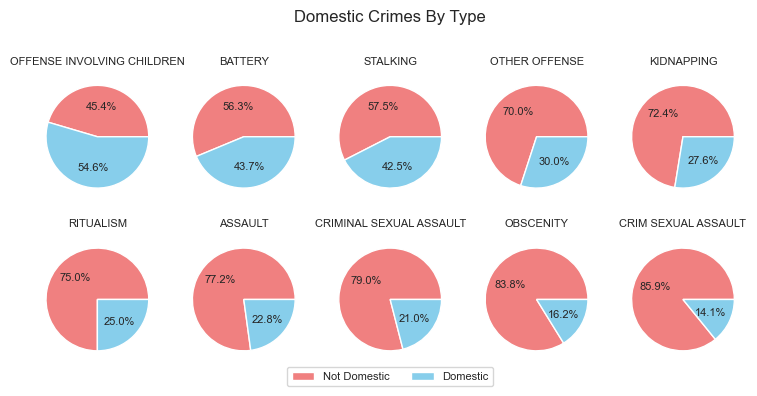

In [ ]:
# Create a cross-tabulation (crosstab) between 'Primary Type' and 'Domestic'
domestic_crosstab = pd.crosstab(crime_df_corr['Primary Type'], crime_df_corr['Domestic'])

# Rename the columns to be more descriptive
domestic_crosstab = domestic_crosstab.rename(columns={False: 'False (Not Domestic)', True: 'True (Domestic)'})

# Add a third column for the percentage of True values in 'Domestic'
domestic_crosstab['Percent True'] = round((domestic_crosstab['True (Domestic)'] / (domestic_crosstab['True (Domestic)'] + domestic_crosstab['False (Not Domestic)'])) * 100, 2)

# Sort the DataFrame by the values in the 'Percent True' column in descending order
domestic_crosstab_sorted = domestic_crosstab.sort_values(by='Percent True', ascending=False)

# Remove the rows with the primary types 'DOMESTIC VIOLENCE' and 'NON-CRIMINAL (SUBJECT SPECIFIED)' (as they are always 100%)
domestic_crosstab_sorted = domestic_crosstab_sorted.drop(['DOMESTIC VIOLENCE', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], axis=0)

# Get the top 10 primary types with the highest True values in 'Domestic'
top_10_primary_types = domestic_crosstab_sorted.head(10).index

# Create a figure with multiple subplots for the pie charts
fig, axs = plt.subplots(2, 5, figsize=(7.5, 4))

# Generate pie charts for each of the top 10 primary types
for i, primary_type in enumerate(top_10_primary_types):
    values = domestic_crosstab_sorted.loc[primary_type, ['False (Not Domestic)', 'True (Domestic)']]
    axs[i // 5, i % 5].pie(values, autopct='%1.1f%%', textprops={'fontsize': 8}, colors=['lightcoral', 'skyblue'])
    axs[i // 5, i % 5].set_title(primary_type, fontsize=8)
    axs[i // 5, i % 5].set_aspect('equal')  # Equal aspect ratio to avoid stretching

# Create a single legend for all pie charts
legend_labels = ['Not Domestic', 'Domestic']
fig.legend(legend_labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, .1), fontsize=8)

# Remove the individual labels for each pie chart
# fig.text(0.5, 0.04, 'Prevalence of Domestic Crimes', ha='center', fontsize=8)
# fig.text(0.04, 0.5, 'Percentage', va='center', rotation='vertical', fontsize=8)

plt.suptitle("Domestic Crimes By Type", fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
# Filter the DataFrame to include only rows where 'Domestic' is True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Group the data by 'Location Description' and calculate the count of occurrences for each group
domestic_true_counts_by_location = domestic_true_df.groupby('Location Description').size().reset_index(name='Count')

# Sort the DataFrame by the 'Count' column in descending order
domestic_true_counts_by_location_sorted = domestic_true_counts_by_location.sort_values(by='Count', ascending=False)

# Get the top 10 locations where 'Domestic' is True
top_10_locations = domestic_true_counts_by_location_sorted.head(10)

# Print the result (top 10 locations where 'Domestic' is True)
print("Top 10 locations where 'Domestic' is True:")
print(top_10_locations)


Top 10 locations where 'Domestic' is True:
               Location Description   Count
122                       RESIDENCE  395055
17                        APARTMENT  340157
148                          STREET  129307
143                        SIDEWALK   64246
126         RESIDENCE PORCH/HALLWAY   17686
108                           OTHER   13720
161          VEHICLE NON-COMMERCIAL   12906
34                    CHA APARTMENT   12110
15                            ALLEY   12087
116  PARKING LOT/GARAGE(NON.RESID.)    7962


In [ ]:
# Filter the DataFrame to include only rows where 'Domestic' is True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Group the data by 'Ward' and calculate the count of occurrences where 'Domestic' is True for each group
domestic_true_counts_by_ward = domestic_true_df.groupby('Ward').size().reset_index(name='Count')

# Sort the DataFrame by the 'Count' column in descending order
domestic_true_counts_by_ward_sorted = domestic_true_counts_by_ward.sort_values(by='Count', ascending=False)

# Get the top 10 wards with the highest amount of 'Domestic' set to True
top_10_wards = domestic_true_counts_by_ward_sorted.head(10)

# Print the result (top 10 wards with the highest amount of 'Domestic' set to True)
print("Top 10 wards with the highest amount of 'Domestic' set to True:")
print(top_10_wards)


Top 10 wards with the highest amount of 'Domestic' set to True:
    Ward  Count
27  28.0  49235
16  17.0  49131
23  24.0  46644
19  20.0  44620
5    6.0  42940
33  34.0  37177
20  21.0  36419
15  16.0  36187
8    9.0  36166
6    7.0  35728


In [ ]:
# Filter the DataFrame to include only rows where 'Domestic' is True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Group the data by 'DayOfWeek' and calculate the count of occurrences where 'Domestic' is True for each group
domestic_true_counts_by_day = domestic_true_df.groupby('DayOfWeek').size().reset_index(name='Count')

# Sort the DataFrame by the 'Count' column in descending order
domestic_true_counts_by_day_sorted = domestic_true_counts_by_day.sort_values(by='Count', ascending=False)

# Get the day of the week where 'Domestic' is most common (the one with the highest count)
most_common_day_of_week = domestic_true_counts_by_day_sorted.iloc[0]['DayOfWeek']

# Print the result (day of the week where 'Domestic' is most common)
print("Day of the week where 'Domestic' is most common:", most_common_day_of_week)


Day of the week where 'Domestic' is most common: 6


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assuming you have the crime_df_corr DataFrame with columns: 'Domestic' and 'Arrest'

# Step 1: Prepare the data
X = crime_df_corr[['Domestic']].values
y = crime_df_corr['Arrest'].values

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 4: Access the coefficients
coefficient = model.coef_[0][0]

# Print the coefficient
print(f"Coefficient of likelihood for Arrest=True given Domestic=True: {coefficient:.2f}")


Coefficient of likelihood for Arrest=True given Domestic=True: -0.49


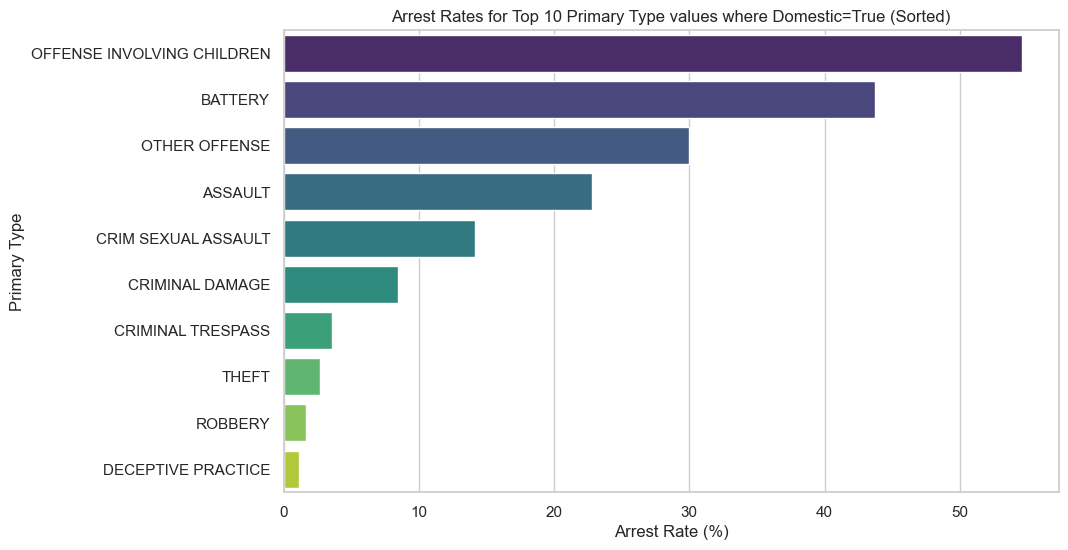

In [ ]:
# Step 1: Filter rows where Domestic=True
domestic_arrests_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Step 2: Get the top 10 unique Primary Type values based on occurrence frequency
top_10_primary_types = domestic_arrests_df['Primary Type'].value_counts().nlargest(10).index

# Step 3: Calculate the arrest rate for each of the top 10 Primary Type values
arrest_rates = {}
for primary_type in top_10_primary_types:
    total_arrests = len(domestic_arrests_df[domestic_arrests_df['Primary Type'] == primary_type])
    total_incidents = len(crime_df_corr[crime_df_corr['Primary Type'] == primary_type])
    arrest_rate = (total_arrests / total_incidents) * 100  # Calculate as a percentage
    arrest_rates[primary_type] = arrest_rate

# Convert the results to a DataFrame and sort by arrest rate in descending order
arrest_rates_df = pd.DataFrame.from_dict(arrest_rates, orient='index', columns=['Arrest Rate (%)'])
arrest_rates_df.index.name = 'Primary Type'
arrest_rates_df.reset_index(inplace=True)
arrest_rates_df.sort_values(by='Arrest Rate (%)', ascending=False, inplace=True)

# Display or visualize the results in a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Arrest Rate (%)', y='Primary Type', data=arrest_rates_df, palette='viridis')
plt.xlabel('Arrest Rate (%)')
plt.ylabel('Primary Type')
plt.title('Arrest Rates for Top 10 Primary Type values where Domestic=True (Sorted)')
plt.show()



In [ ]:
crime_df_corr

Date                Primary Type Location Description  \
0       2018-09-01 00:01:00                       THEFT            RESIDENCE   
1       2016-05-01 00:25:00          DECEPTIVE PRACTICE                  NaN   
2       2018-07-31 13:30:00                   NARCOTICS               STREET   
3       2018-12-19 16:30:00             CRIMINAL DAMAGE               STREET   
4       2015-02-02 10:00:00          DECEPTIVE PRACTICE                OTHER   
...                     ...                         ...                  ...   
7846797 2022-01-01 00:01:00               OTHER OFFENSE            APARTMENT   
7846798 2022-12-22 12:00:00          DECEPTIVE PRACTICE                  NaN   
7846799 2021-04-01 00:00:00          DECEPTIVE PRACTICE            RESIDENCE   
7846800 2015-11-03 12:00:00  OFFENSE INVOLVING CHILDREN            RESIDENCE   
7846801 2021-12-19 14:30:00          DECEPTIVE PRACTICE                  NaN   

         Arrest  Domestic  District  Ward  Year      Month  Day  DayOfWeek  \
0         False      True       6.0   8.0  2018  September    1          5   
1         False     False       8.0  15.0  2016        May    1          6   
2          True     False       2.0   5.0  2018       July   31          1   
3         False     False      25.0  31.0  2018   December   19          2   
4         False     False       8.0  23.0  2015   February    2          0   
...         ...       ...       ...   ...   ...        ...  ...        ...   
7846797   False     False      19.0  46.0  2022    January    1          5   
7846798   False     False      19.0  44.0  2022   December   22          3   
7846799   False     False       6.0  17.0  2021      April    1          3   
7846800   False     False      19.0  47.0  2015   November    3          1   
7846801   False     False      14.0  26.0  2021   December   19          6   

         Time_of_Day      Time  Hour  Time of Day  
0                  0  00:01:00     0            0  
1                  0  00:25:00     0            0  
2                  1  13:30:00    13           13  
3                  1  16:30:00    16           16  
4                  0  10:00:00    10           10  
...              ...       ...   ...          ...  
7846797            0  00:01:00     0            0  
7846798            1  12:00:00    12           12  
7846799            0  00:00:00     0            0  
7846800            1  12:00:00    12           12  
7846801            1  14:30:00    14           14  

[7712492 rows x 15 columns]

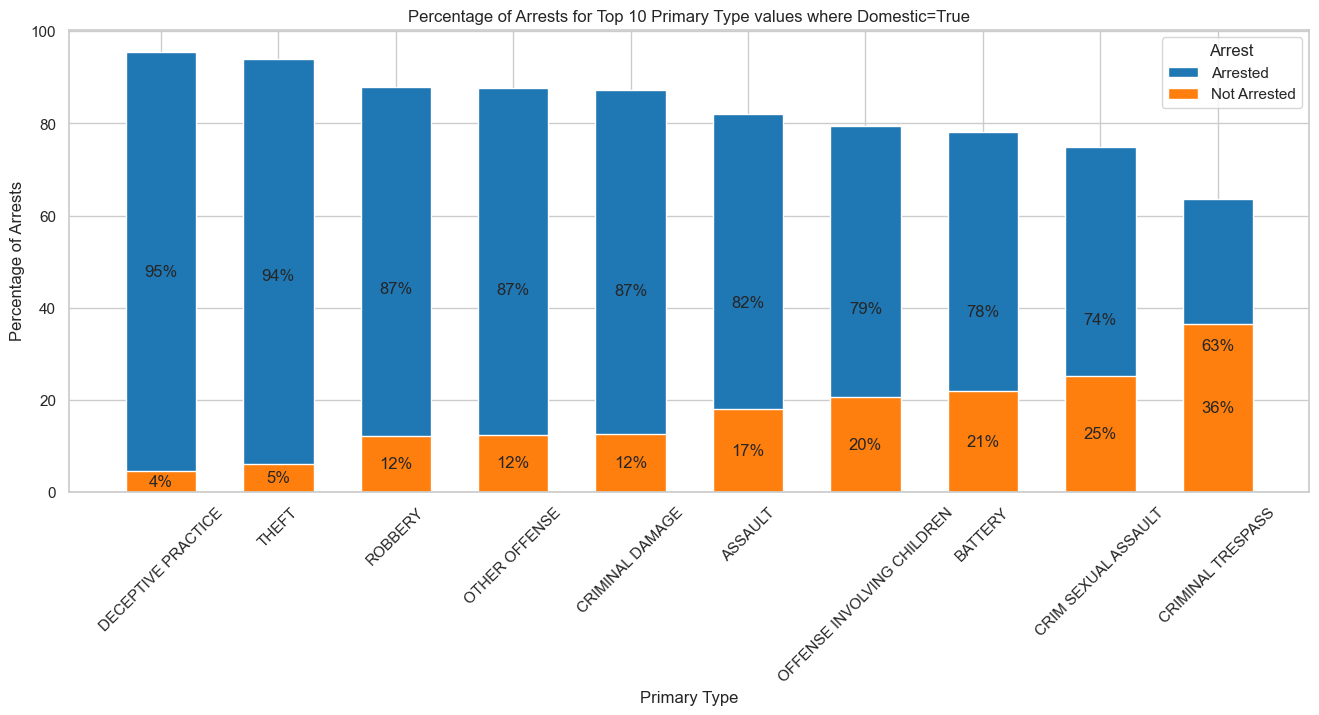

In [ ]:

# Filter rows where Domestic=True
domestic_arrests_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Get the top 10 unique Primary Type values based on occurrence frequency
top_10_primary_types = domestic_arrests_df['Primary Type'].value_counts().nlargest(10).index

# Create a list to store the data for each Primary Type
stacked_data = []

for primary_type in top_10_primary_types:
    # Count the number of Arrest=True and Arrest=False for each Primary Type
    counts = domestic_arrests_df[domestic_arrests_df['Primary Type'] == primary_type]['Arrest'].value_counts()
    total_incidents = len(domestic_arrests_df[domestic_arrests_df['Primary Type'] == primary_type])
    
    # Calculate the percentage of arrests for each Primary Type
    percentage_arrest_false = (counts.get(False, 0) / total_incidents) * 100
    percentage_arrest_true = (counts.get(True, 0) / total_incidents) * 100
    
    # Append the percentages as a dictionary to the stacked_data list
    stacked_data.append({'Primary Type': primary_type, 'Arrested': percentage_arrest_false, 'Not Arrested': percentage_arrest_true})

# Convert the list to a DataFrame
stacked_df = pd.DataFrame(stacked_data)

# Set 'Primary Type' column as the index for plotting
stacked_df.set_index('Primary Type', inplace=True)

# Sort the DataFrame by the "Arrested" column in descending order
stacked_df.sort_values(by='Arrested', ascending=False, inplace=True)

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(16, 6))
width = 0.6
bottom = np.zeros(len(top_10_primary_types))

for arrest_type in ['Arrested', 'Not Arrested']:
    p = ax.bar(stacked_df.index, stacked_df[arrest_type], width, label=arrest_type)
    bottom += stacked_df[arrest_type]

    ax.bar_label(p, label_type='center', labels=[f"{int(val)}%" for val in stacked_df[arrest_type]])

ax.set_xlabel('Primary Type')
ax.set_ylabel('Percentage of Arrests')
ax.set_title('Percentage of Arrests for Top 10 Primary Type values where Domestic=True')
ax.legend(title='Arrest')

plt.xticks(rotation=45)
plt.show()

In [ ]:
# Filter the rows where Domestic=True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Get the top 10 unique Primary Type values based on occurrence frequency
top_10_primary_types = domestic_true_df['Primary Type'].value_counts().nlargest(10)

# Create a custom DataFrame for the top 10 crimes where Domestic=True
top_10_domestic_true_crimes = pd.DataFrame({
    'Primary Type': top_10_primary_types.index,
    'Domestic Crimes': top_10_primary_types.values
})

# Add another column for Arrests where Arrest=True
arrests = []
not_arrested = []
for primary_type in top_10_primary_types.index:
    arrests_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == True)])
    not_arrested_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == False)])
    arrests.append(arrests_count)
    not_arrested.append(not_arrested_count)

top_10_domestic_true_crimes['Arrests'] = arrests
top_10_domestic_true_crimes['Not Arrested'] = not_arrested

# Calculate the arrest rate as a percentage for each crime
top_10_domestic_true_crimes['Arrest Rate (%)'] = (top_10_domestic_true_crimes['Arrests'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100
top_10_domestic_true_crimes['Not Arrested Rate (%)'] = (top_10_domestic_true_crimes['Not Arrested'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100

# Sort the DataFrame by 'Arrest Rate (%)' column in descending order
top_10_domestic_true_crimes.sort_values(by='Arrest Rate (%)', ascending=False, inplace=True)

# Display the custom DataFrame in a tabulated format
print(tabulate(top_10_domestic_true_crimes, headers='keys', tablefmt='psql'))



+----+----------------------------+-------------------+-----------+----------------+-------------------+-------------------------+
|    | Primary Type               |   Domestic Crimes |   Arrests |   Not Arrested |   Arrest Rate (%) |   Not Arrested Rate (%) |
|----+----------------------------+-------------------+-----------+----------------+-------------------+-------------------------|
|  6 | CRIMINAL TRESPASS          |              7599 |      2771 |           4828 |          36.4653  |                 63.5347 |
|  8 | CRIM SEXUAL ASSAULT        |              3903 |       983 |           2920 |          25.1858  |                 74.8142 |
|  0 | BATTERY                    |            617042 |    134943 |         482099 |          21.8693  |                 78.1307 |
|  5 | OFFENSE INVOLVING CHILDREN |             30127 |      6181 |          23946 |          20.5165  |                 79.4835 |
|  2 | ASSAULT                    |            114443 |     20529 |          93914 

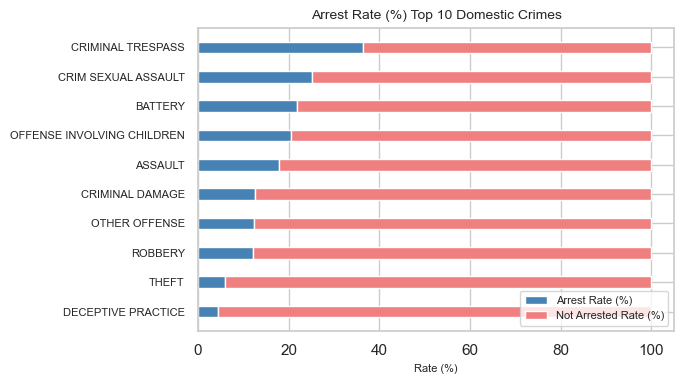

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'crime_df_corr' with the relevant data

# Filter the rows where Domestic=True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Get the top 10 unique Primary Type values based on occurrence frequency
top_10_primary_types = domestic_true_df['Primary Type'].value_counts().nlargest(10)

# Create a custom DataFrame for the top 10 crimes where Domestic=True
top_10_domestic_true_crimes = pd.DataFrame({
    'Primary Type': top_10_primary_types.index,
    'Domestic Crimes': top_10_primary_types.values
})

# Add another column for Arrests where Arrest=True
arrests = []
not_arrested = []
for primary_type in top_10_primary_types.index:
    arrests_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == True)])
    not_arrested_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == False)])
    arrests.append(arrests_count)
    not_arrested.append(not_arrested_count)

top_10_domestic_true_crimes['Arrests'] = arrests
top_10_domestic_true_crimes['Not Arrested'] = not_arrested

# Calculate the arrest rate as a percentage for each crime
top_10_domestic_true_crimes['Arrest Rate (%)'] = (top_10_domestic_true_crimes['Arrests'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100
top_10_domestic_true_crimes['Not Arrested Rate (%)'] = (top_10_domestic_true_crimes['Not Arrested'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100

# Sort the DataFrame by 'Arrest Rate (%)' column in ascending order (from highest to lowest)
top_10_domestic_true_crimes.sort_values(by='Arrest Rate (%)', ascending=True, inplace=True)

# Calculate the difference between "Arrest Rate (%)" and "Not Arrested Rate (%)"
top_10_domestic_true_crimes['Difference'] = top_10_domestic_true_crimes['Arrest Rate (%)'] - top_10_domestic_true_crimes['Not Arrested Rate (%)']

# Create a horizontal bar chart to display the differences
fig, ax = plt.subplots(figsize=(7, 4))  # Set the figsize to half the size

# Bar positions
y_pos = range(len(top_10_domestic_true_crimes))
# Bar widths
width = 0.4

# Plot Arrest Rate (%) bars
ax.barh(y_pos, top_10_domestic_true_crimes['Arrest Rate (%)'], width, label='Arrest Rate (%)', color='steelblue')
# Plot Not Arrested Rate (%) bars
ax.barh(y_pos, top_10_domestic_true_crimes['Not Arrested Rate (%)'], width, label='Not Arrested Rate (%)', color='lightcoral', left=top_10_domestic_true_crimes['Arrest Rate (%)'])

# Set y-axis labels as the Primary Type
ax.set_yticks(y_pos)
ax.set_yticklabels(top_10_domestic_true_crimes['Primary Type'], fontsize=8)  # Smaller font size for y-axis tick labels
# Set the x-axis label and font size
ax.set_xlabel('Rate (%)', fontsize=8)
# Set the title and font size
ax.set_title('Arrest Rate (%) Top 10 Domestic Crimes', fontsize=10)
# Display the legend with smaller font size
ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()



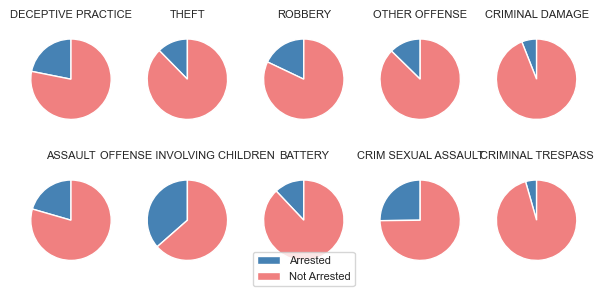

In [ ]:
# Filter the rows where Domestic=True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Get the top 10 unique Primary Type values based on occurrence frequency
top_10_primary_types = domestic_true_df['Primary Type'].value_counts().nlargest(10)

# Create a custom DataFrame for the top 10 crimes where Domestic=True
top_10_domestic_true_crimes = pd.DataFrame({
    'Primary Type': top_10_primary_types.index,
    'Domestic Crimes': top_10_primary_types.values
})

# Add another column for Arrests where Arrest=True
arrests = []
not_arrested = []
for primary_type in top_10_primary_types.index:
    arrests_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == True)])
    not_arrested_count = len(domestic_true_df[(domestic_true_df['Primary Type'] == primary_type) & (domestic_true_df['Arrest'] == False)])
    arrests.append(arrests_count)
    not_arrested.append(not_arrested_count)

top_10_domestic_true_crimes['Arrests'] = arrests
top_10_domestic_true_crimes['Not Arrested'] = not_arrested

# Calculate the arrest rate as a percentage for each crime
top_10_domestic_true_crimes['Arrest Rate (%)'] = (top_10_domestic_true_crimes['Arrests'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100
top_10_domestic_true_crimes['Not Arrested Rate (%)'] = (top_10_domestic_true_crimes['Not Arrested'] / top_10_domestic_true_crimes['Domestic Crimes']) * 100

# Sort the DataFrame by 'Arrest Rate (%)' column in ascending order (from highest to lowest)
top_10_domestic_true_crimes.sort_values(by='Arrest Rate (%)', ascending=True, inplace=True)

# Create a 2x5 grid of pie charts to display the differences
fig, axs = plt.subplots(2, 5, figsize=(6, 3))

# Flatten the 2D array of subplots to access each subplot individually
axs = axs.flatten()

# Colors for the pie charts
colors = ['steelblue', 'lightcoral']

for i, crime_type in enumerate(top_10_domestic_true_crimes['Primary Type']):
    data = [top_10_domestic_true_crimes.loc[i, 'Arrest Rate (%)'], top_10_domestic_true_crimes.loc[i, 'Not Arrested Rate (%)']]
    axs[i].pie(data, colors=colors, startangle=90, autopct='')
    axs[i].set_title(crime_type, fontsize=8)
    axs[i].axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Remove pie slice labels and extra spacing between subplots
for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_aspect('equal')
    ax.margins(0)

# Create a master legend for the pie charts at the bottom
fig.legend(['Arrested', 'Not Arrested'], bbox_to_anchor=(0.5, 0), loc='lower center', fontsize=8)

# Remove empty subplots
for i in range(len(top_10_primary_types), len(axs)):
    fig.delaxes(axs[i])

# Adjust subplot parameters to make space for the legend at the bottom
plt.subplots_adjust(bottom=0.1)

plt.tight_layout()
plt.show()




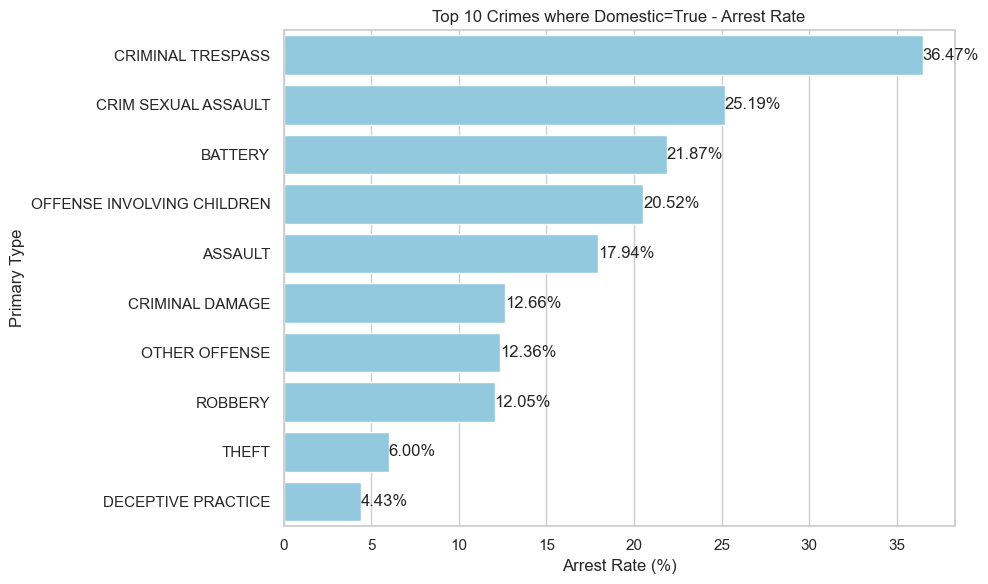

In [ ]:
# Sort the DataFrame by 'Arrest Rate (%)' column in descending order
top_10_domestic_true_crimes.sort_values(by='Arrest Rate (%)', ascending=False, inplace=True)

# Create a horizontal bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Arrest Rate (%)', y='Primary Type', data=top_10_domestic_true_crimes, color='skyblue')

# Add the arrest rate as labels inside the bars
for i, rate in enumerate(top_10_domestic_true_crimes['Arrest Rate (%)']):
    plt.text(rate, i, f'{rate:.2f}%', va='center')

# Add labels and title
plt.xlabel('Arrest Rate (%)')
plt.ylabel('Primary Type')
plt.title('Top 10 Crimes where Domestic=True - Arrest Rate')

plt.tight_layout()
plt.show()


In [ ]:
# Filter the rows where Domestic is True
domestic_true_df = crime_df_corr[crime_df_corr['Domestic'] == True]

# Group by Primary Type and calculate the count of occurrences
domestic_true_counts_by_type = domestic_true_df.groupby('Primary Type').size().reset_index(name='Domestic Incidents')

# Sort the DataFrame by 'Domestic Incidents' column in descending order
domestic_true_counts_by_type = domestic_true_counts_by_type.sort_values(by='Domestic Incidents', ascending=False)

# Print the DataFrame showing the count of occurrences for each Primary Type
print(domestic_true_counts_by_type)


                         Primary Type  Domestic Incidents
2                             BATTERY              617042
25                      OTHER OFFENSE              143721
1                             ASSAULT              114443
6                     CRIMINAL DAMAGE               74702
33                              THEFT               43748
23         OFFENSE INVOLVING CHILDREN               30127
8                   CRIMINAL TRESPASS                7599
30                            ROBBERY                4897
5                 CRIM SEXUAL ASSAULT                3903
9                  DECEPTIVE PRACTICE                3901
3                            BURGLARY                3652
31                        SEX OFFENSE                3266
28             PUBLIC PEACE VIOLATION                2383
18                MOTOR VEHICLE THEFT                2191
16                         KIDNAPPING                1980
32                           STALKING                1980
7             

In [ ]:
# Get the top 10 crime categories based on occurrence frequency
top_10_crimes = crime_df_corr['Primary Type'].value_counts().nlargest(10)

# Calculate the total number of crimes in the dataset
total_crimes = len(crime_df_corr)

# Calculate the total number of crimes for the top 10 crime categories
total_top_10_crimes = top_10_crimes.sum()

# Calculate the percentage that the top 10 crimes represent
percentage_top_10_crimes = (total_top_10_crimes / total_crimes) * 100

print(f"The top 10 crimes represent {percentage_top_10_crimes:.2f}% of all crimes.")


The top 10 crimes represent 91.57% of all crimes.


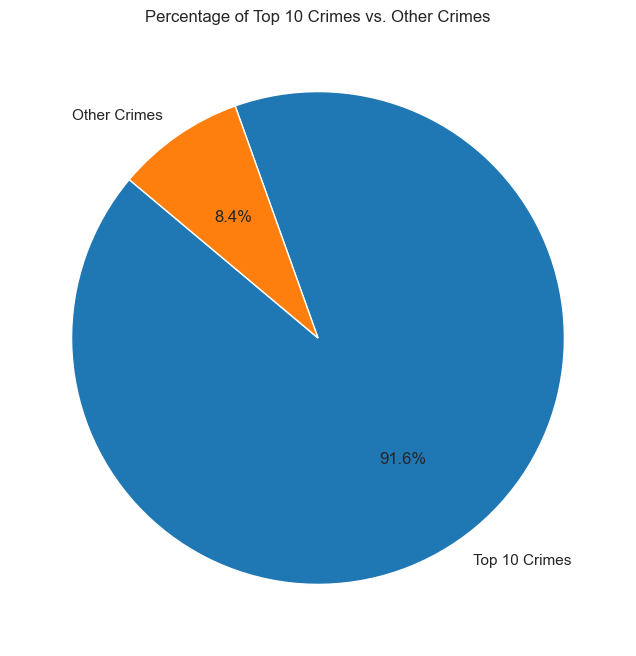

In [ ]:
# Data for the pie chart
labels = ['Top 10 Crimes', 'Other Crimes']
sizes = [percentage_top_10_crimes, 100 - percentage_top_10_crimes]

# Custom colors for the pie chart
colors = ['#1f77b4', '#ff7f0e']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Percentage of Top 10 Crimes vs. Other Crimes')

# Show the pie chart
plt.show()


Top 10 Most Frequent Crimes and Their Percentages:
                       Count  Percentage
Primary Type                            
THEFT                1626969   21.095244
BATTERY              1410866   18.293257
CRIMINAL DAMAGE       878910   11.395928
NARCOTICS             746149    9.674551
ASSAULT               501099    6.497239
OTHER OFFENSE         479025    6.211028
BURGLARY              422245    5.474819
MOTOR VEHICLE THEFT   366581    4.753081
DECEPTIVE PRACTICE    340752    4.418183
ROBBERY               289674    3.755907


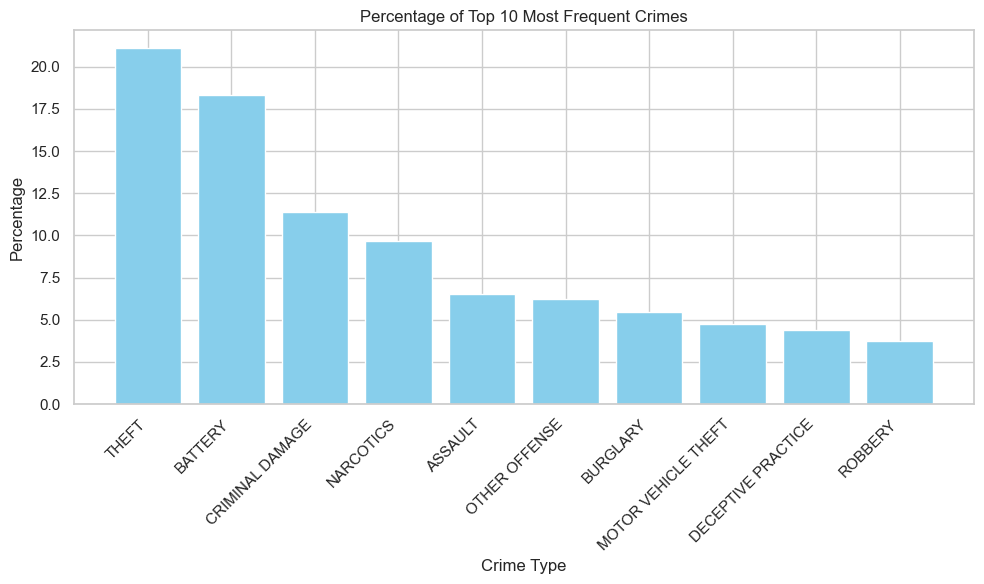

In [ ]:
# Get the top 10 most frequent crimes
top_10_crimes = crime_df_corr['Primary Type'].value_counts().nlargest(10)

# Calculate the total number of crimes
total_crimes = len(crime_df_corr)

# Calculate the percentage each crime represents
percentages = (top_10_crimes / total_crimes) * 100

# Print the top 10 crimes and their percentages
print("Top 10 Most Frequent Crimes and Their Percentages:")
print(pd.concat([top_10_crimes, percentages], axis=1, keys=['Count', 'Percentage']))

# Create a bar plot to visualize the percentages
plt.figure(figsize=(10, 6))
plt.bar(top_10_crimes.index, percentages, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Crime Type')
plt.ylabel('Percentage')
plt.title('Percentage of Top 10 Most Frequent Crimes')
plt.tight_layout()
plt.show()


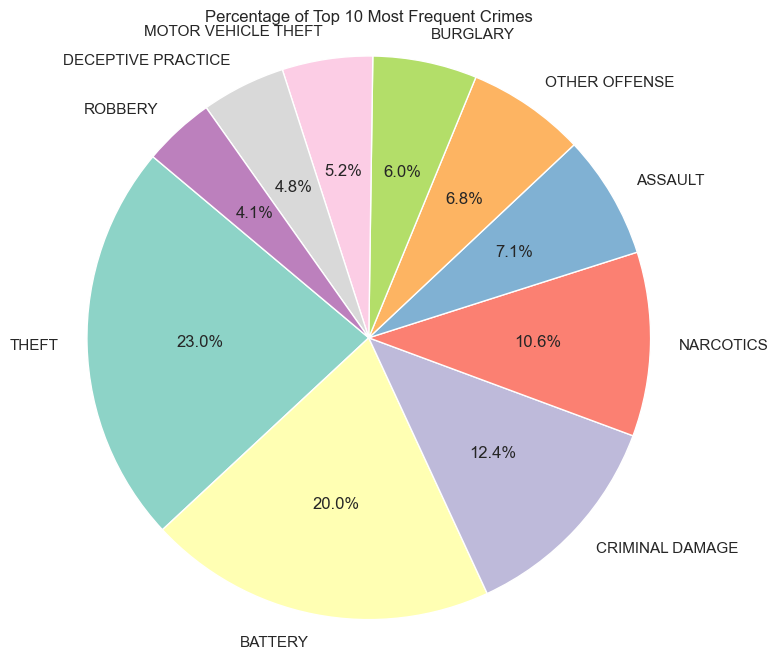

In [ ]:
# Get the top 10 most frequent crimes
top_10_crimes = crime_df_corr['Primary Type'].value_counts().nlargest(10)

# Calculate the total number of crimes
total_crimes = len(crime_df_corr)

# Calculate the percentage each crime represents
percentages = (top_10_crimes / total_crimes) * 100

# Create a pie chart to visualize the percentages
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=top_10_crimes.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.axis('equal')
plt.title('Percentage of Top 10 Most Frequent Crimes')
plt.show()


In [ ]:
# Get the top 10 occurrences of values in the 'Primary Type' column
top_10_occurrences = crime_df_corr['Primary Type'].value_counts().nlargest(10)

# Create a list of tuples containing the value and its occurrence count
top_10_list = list(zip(top_10_occurrences.index, top_10_occurrences.values))

# Print the list vertically
for item in top_10_list:
    print(f"{item[0]}: {item[1]}")



THEFT: 1626969
BATTERY: 1410866
CRIMINAL DAMAGE: 878910
NARCOTICS: 746149
ASSAULT: 501099
OTHER OFFENSE: 479025
BURGLARY: 422245
MOTOR VEHICLE THEFT: 366581
DECEPTIVE PRACTICE: 340752
ROBBERY: 289674


In [ ]:
crime_df_corr

Date                Primary Type Location Description  \
0       2018-09-01 00:01:00                       THEFT            RESIDENCE   
1       2016-05-01 00:25:00          DECEPTIVE PRACTICE                  NaN   
2       2018-07-31 13:30:00                   NARCOTICS               STREET   
3       2018-12-19 16:30:00             CRIMINAL DAMAGE               STREET   
4       2015-02-02 10:00:00          DECEPTIVE PRACTICE                OTHER   
...                     ...                         ...                  ...   
7846797 2022-01-01 00:01:00               OTHER OFFENSE            APARTMENT   
7846798 2022-12-22 12:00:00          DECEPTIVE PRACTICE                  NaN   
7846799 2021-04-01 00:00:00          DECEPTIVE PRACTICE            RESIDENCE   
7846800 2015-11-03 12:00:00  OFFENSE INVOLVING CHILDREN            RESIDENCE   
7846801 2021-12-19 14:30:00          DECEPTIVE PRACTICE                  NaN   

         Arrest  Domestic  District  Ward  Year      Month  Day  DayOfWeek  \
0         False      True       6.0   8.0  2018  September    1          5   
1         False     False       8.0  15.0  2016        May    1          6   
2          True     False       2.0   5.0  2018       July   31          1   
3         False     False      25.0  31.0  2018   December   19          2   
4         False     False       8.0  23.0  2015   February    2          0   
...         ...       ...       ...   ...   ...        ...  ...        ...   
7846797   False     False      19.0  46.0  2022    January    1          5   
7846798   False     False      19.0  44.0  2022   December   22          3   
7846799   False     False       6.0  17.0  2021      April    1          3   
7846800   False     False      19.0  47.0  2015   November    3          1   
7846801   False     False      14.0  26.0  2021   December   19          6   

         Time_of_Day      Time  Hour  Time of Day  
0                  0  00:01:00     0            0  
1                  0  00:25:00     0            0  
2                  1  13:30:00    13           13  
3                  1  16:30:00    16           16  
4                  0  10:00:00    10           10  
...              ...       ...   ...          ...  
7846797            0  00:01:00     0            0  
7846798            1  12:00:00    12           12  
7846799            0  00:00:00     0            0  
7846800            1  12:00:00    12           12  
7846801            1  14:30:00    14           14  

[7712492 rows x 15 columns]

In [ ]:
# Calculate the total number of unique districts
total_unique_districts = crime_df_corr['District'].nunique()

print("Total number of unique districts:", total_unique_districts)


Total number of unique districts: 24


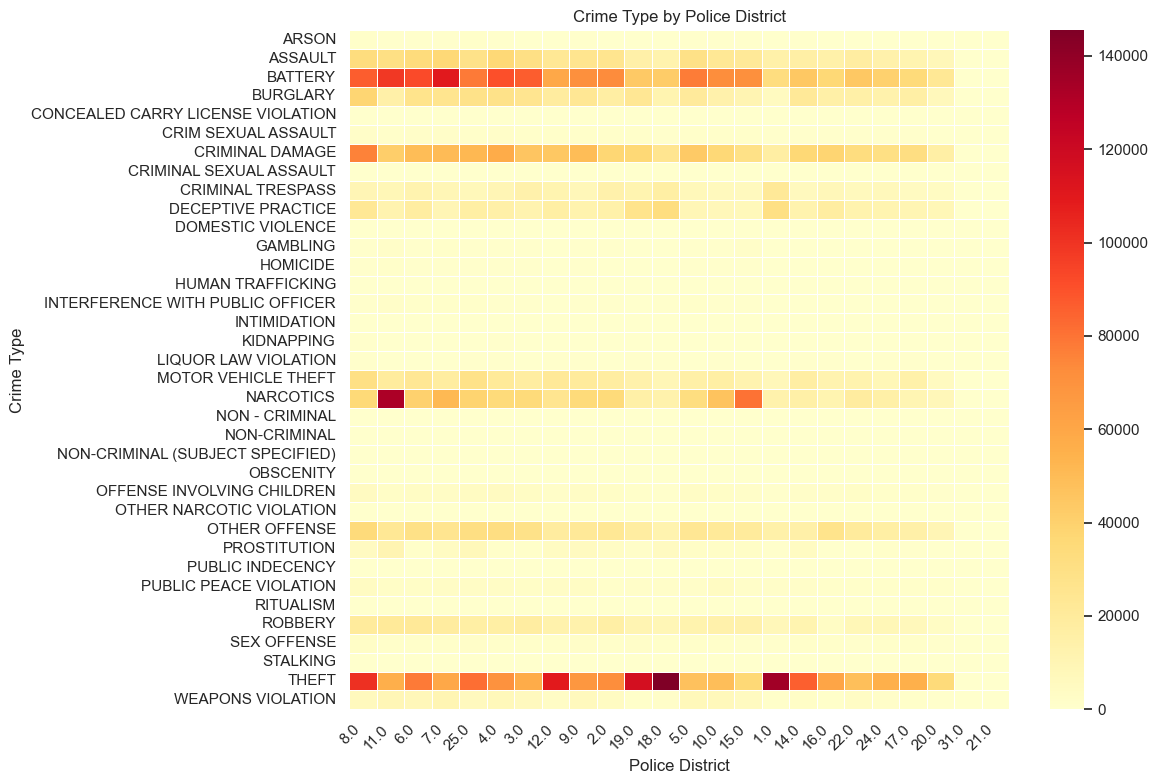

In [ ]:
# Pivot table to calculate the frequency of each Crime Type in each District
crime_by_district_type = crime_df_corr.pivot_table(index='Primary Type', columns='District', values='Date', aggfunc='count', fill_value=0)

# Sort the columns by the total number of crimes in each district
district_order = crime_by_district_type.sum(axis=0).sort_values(ascending=False).index
crime_by_district_type = crime_by_district_type[district_order]

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crime_by_district_type, cmap='YlOrRd', annot=False, fmt='d', linewidths=0.5)
plt.title('Crime Type by Police District')
plt.xlabel('Police District')
plt.ylabel('Crime Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [73]:
# Group by 'Primary Type' and calculate the total occurrences and total arrests
grouped = crime_df_corr.groupby('Primary Type')['Arrest'].agg([('Total Occurrences', 'count'), ('Total Arrests', 'sum')])

# Calculate the arrest rate
grouped['Arrest Rate'] = (grouped['Total Arrests'] / grouped['Total Occurrences']) * 100

# Reset index to convert the grouped result into a DataFrame
result_df = grouped.reset_index()

# Sort the DataFrame by 'Arrest Rate' in descending order
sorted_result_df = result_df.sort_values(by='Arrest Rate', ascending=False)

# Display the sorted result using tabulate
print(tabulate(sorted_result_df, headers='keys', tablefmt='psql'))


+----+-----------------------------------+---------------------+-----------------+---------------+
|    | Primary Type                      |   Total Occurrences |   Total Arrests |   Arrest Rate |
|----+-----------------------------------+---------------------+-----------------+---------------|
| 10 | DOMESTIC VIOLENCE                 |                   1 |               1 |     100       |
| 27 | PROSTITUTION                      |               69750 |           69478 |      99.61    |
| 19 | NARCOTICS                         |              746149 |          741674 |      99.4003  |
| 11 | GAMBLING                          |               14616 |           14509 |      99.2679  |
| 17 | LIQUOR LAW VIOLATION              |               14846 |           14719 |      99.1446  |
| 28 | PUBLIC INDECENCY                  |                 193 |             191 |      98.9637  |
|  4 | CONCEALED CARRY LICENSE VIOLATION |                1019 |             984 |      96.5653  |
| 14 | INT